In [82]:
# Import thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from pymongo import MongoClient
import os

In [83]:
# Kết nối MongoDB và lấy dữ liệu
client = MongoClient("mongodb://localhost:27017/")
db = client['metadata']
collection = db['ACB']
df = pd.DataFrame(list(collection.find({}, {"_id": 0})))

In [84]:
# Tiền xử lý dữ liệu
df['Ngay'] = pd.to_datetime(df['Ngay'])
df = df.sort_values(by='Ngay')
df['Momentum'] = (df['GiaDongCua'] - df['GiaDongCua'].shift(1)) / df['GiaDongCua'].shift(1)
df['SMA_20'] = df['GiaDongCua'].rolling(window=20).mean()
df['EMA_20'] = df['GiaDongCua'].ewm(span=20, adjust=False).mean()
df = df.dropna()

In [85]:
# Chỉ giữ các cột cần thiết
features = ['GiaDongCua', 'Momentum', 'SMA_20', 'EMA_20']
df = df[['Ngay'] + features]

In [86]:
# Chuyển đổi sang chỉ số thời gian
df1 = df.set_index('Ngay')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df1)

In [87]:
# Chia dữ liệu train/test
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [88]:
# Tạo cửa sổ thời gian
def create_dataset(data, time_step=50):
    x, y = [], []
    for i in range(time_step, len(data)):
        x.append(data[i-time_step:i])
        y.append(data[i, 0])  # Giá trị đầu tiên là mục tiêu
    return np.array(x), np.array(y)

In [89]:
x_train, y_train = create_dataset(train_data)
x_test, y_test = create_dataset(test_data)

In [90]:
# Xây dựng mô hình
def build_model():
    model = Sequential()
    model.add(LSTM(units=128, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
    model.add(LSTM(units=64))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    return model

In [91]:
model = build_model()

# Huấn luyện mô hình
checkpoint_path = "save_models/ACB_model.keras"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='loss', save_best_only=True, verbose=2)
model.fit(x_train, y_train, epochs=100, batch_size=32, callbacks=[checkpoint], verbose=2)

Epoch 1/100


C:\Users\TRUONG\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: loss improved from inf to 0.02401, saving model to save_models/ACB_model.keras
111/111 - 7s - 61ms/step - loss: 0.0240
Epoch 2/100

Epoch 2: loss improved from 0.02401 to 0.01602, saving model to save_models/ACB_model.keras
111/111 - 4s - 34ms/step - loss: 0.0160
Epoch 3/100

Epoch 3: loss improved from 0.01602 to 0.01440, saving model to save_models/ACB_model.keras
111/111 - 4s - 34ms/step - loss: 0.0144
Epoch 4/100

Epoch 4: loss improved from 0.01440 to 0.01229, saving model to save_models/ACB_model.keras
111/111 - 4s - 35ms/step - loss: 0.0123
Epoch 5/100

Epoch 5: loss improved from 0.01229 to 0.01199, saving model to save_models/ACB_model.keras
111/111 - 4s - 36ms/step - loss: 0.0120
Epoch 6/100

Epoch 6: loss improved from 0.01199 to 0.01098, saving model to save_models/ACB_model.keras
111/111 - 4s - 36ms/step - loss: 0.0110
Epoch 7/100

Epoch 7: loss improved from 0.01098 to 0.01068, saving model to save_models/ACB_model.keras
111/111 - 4s - 37ms/step - loss: 0.0107
E

In [92]:
# Dự đoán và đánh giá mô hình
model = load_model(checkpoint_path)
y_train_predict = model.predict(x_train)
y_test_predict = model.predict(x_test)

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [95]:
# Đưa dữ liệu dự đoán trở lại thang đo gốc
y_train_actual = scaler.inverse_transform(
    np.concatenate([y_train.reshape(-1, 1), np.zeros((y_train.shape[0], len(features)-1))], axis=1)
)[:, 0]  # Chỉ lấy cột đầu tiên (Giá đóng cửa)

y_train_predict_actual = scaler.inverse_transform(
    np.concatenate([y_train_predict, np.zeros((y_train_predict.shape[0], len(features)-1))], axis=1)
)[:, 0]  # Chỉ lấy cột đầu tiên (Giá đóng cửa)

y_test_actual = scaler.inverse_transform(
    np.concatenate([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], len(features)-1))], axis=1)
)[:, 0]  # Chỉ lấy cột đầu tiên (Giá đóng cửa)

y_test_predict_actual = scaler.inverse_transform(
    np.concatenate([y_test_predict, np.zeros((y_test_predict.shape[0], len(features)-1))], axis=1)
)[:, 0]  # Chỉ lấy cột đầu tiên (Giá đóng cửa)

In [99]:
# Rolling Forecast để dự đoán giá trong tương lai
future_days = 5
rolling_input = test_data[-50:]  # 50 giá trị cuối của tập test
future_predictions = []

for _ in range(future_days):
    # Dự đoán giá trị tiếp theo
    prediction = model.predict(rolling_input.reshape(1, 50, len(features)), verbose=0)
    future_predictions.append(prediction[0, 0])
    
    # Reshape prediction thành (1, len(features)) và thêm vào rolling_input
    prediction_reshaped = np.zeros((1, len(features)))  # Tạo một mảng toàn số 0 có kích thước phù hợp
    prediction_reshaped[0, 0] = prediction[0, 0]  # Gán giá trị dự đoán vào vị trí đầu tiên
    
    # Cập nhật rolling_input để sử dụng cho lần dự đoán tiếp theo
    rolling_input = np.append(rolling_input[1:], prediction_reshaped, axis=0)

# Chuyển đổi về thang đo gốc
if len(features) > 1:  # Nếu có nhiều đặc trưng, thêm cột giả
    future_predictions_actual = scaler.inverse_transform(
        np.concatenate(
            [np.array(future_predictions).reshape(-1, 1),  # Giá trị dự đoán
             np.zeros((len(future_predictions), len(features) - 1))  # Các cột giả
            ], axis=1)
    )[:, 0]  # Chỉ lấy cột đầu tiên (Giá đóng cửa)
else:  # Nếu chỉ có một đặc trưng, chuyển đổi trực tiếp
    future_predictions_actual = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))[:, 0]

# Lấy ngày cuối trong DataFrame
last_date = pd.to_datetime(df['Ngay'].iloc[-1])  # Đảm bảo giá trị là Timestamp

# Tạo DataFrame cho các ngày dự báo
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=future_days)
predicted_df = pd.DataFrame({'Ngay': future_dates, 'GiaDongCua': future_predictions_actual})

# Hiển thị kết quả
print(predicted_df)


        Ngay  GiaDongCua
0 2024-12-07   25.903076
1 2024-12-08   19.463468
2 2024-12-09   14.366538
3 2024-12-10   10.046593
4 2024-12-11    6.044475


In [ ]:
# Vẽ biểu đồ
plt.figure(figsize=(15, 6))
plt.plot(df['Ngay'], df['GiaDongCua'], label='Thực tế', color='blue')
plt.plot(predicted_df['Ngay'], predicted_df['GiaDongCua'], label='Dự báo', color='orange')
plt.xlabel('Ngày')
plt.ylabel('Giá đóng cửa')
plt.title('Dự báo giá đóng cửa')
plt.legend()
plt.show()

In [ ]:
# Vẽ biểu đồ so sánh thực tế và dự đoán trên tập test
plt.figure(figsize=(12, 6))
plt.plot(df['Ngay'][len(train_data):], y_test, label='Thực tế', color='blue')
plt.plot(df['Ngay'][len(train_data):], rolling_predictions, label='Dự đoán (Rolling Forecast)', color='orange')
plt.title('Rolling Forecast trên tập Test')
plt.xlabel('Thời gian')
plt.ylabel('Giá trị')
plt.legend()
plt.show()

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
MAE trên tập test: 0.4266891987679454
MAPE trên tập test: 0.016656226325177437


In [30]:
days_to_predict = 5
rolling_window = train_data[-50:, :]

predicted_prices = []
for _ in range(days_to_predict):
    x_input = rolling_window.reshape(1, rolling_window.shape[0], rolling_window.shape[1])
    y_predicted = final_model.predict(x_input)
    y_predicted_unscaled = sc.inverse_transform(np.hstack([y_predicted, np.zeros((1, len(features) - 1))]))[:, 0]

    predicted_prices.append(y_predicted_unscaled[0])
    new_row = np.hstack([y_predicted, np.zeros((1, len(features) - 1))])  # Bổ sung các đặc trưng giả
    rolling_window = np.append(rolling_window[1:], new_row, axis=0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


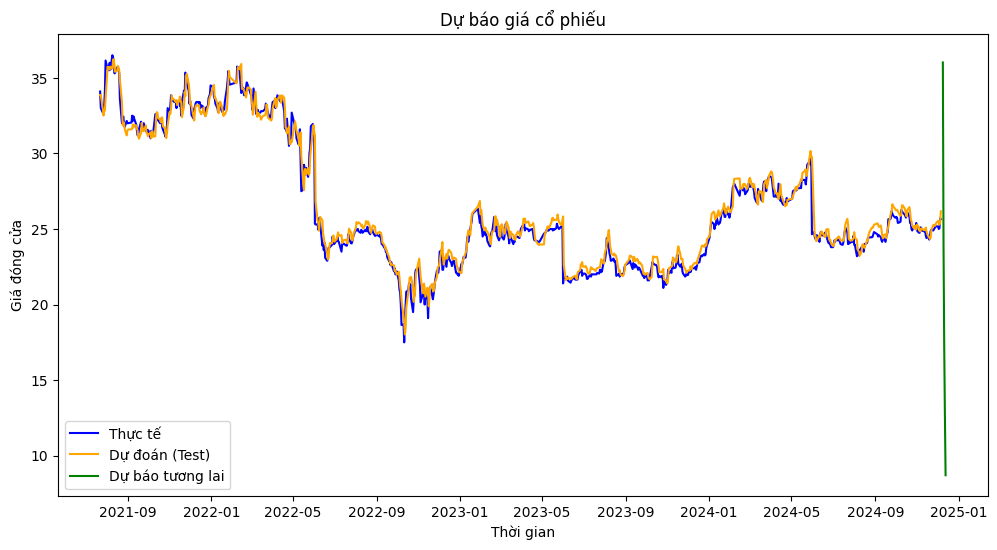

In [31]:
# Dự báo trên dữ liệu thực
plt.figure(figsize=(12, 6))
plt.plot(df['Ngay'][train_size + 50:], y_test_actual, label='Thực tế', color='blue')
plt.plot(df['Ngay'][train_size + 50:], y_pred_test, label='Dự đoán (Test)', color='orange')

# Dự báo tương lai
future_dates = pd.date_range(df['Ngay'].iloc[-1], periods=days_to_predict + 1, freq='B')[1:]
plt.plot(future_dates, predicted_prices, label='Dự báo tương lai', color='green')

plt.title('Dự báo giá cổ phiếu')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa')
plt.legend()
plt.show()


In [33]:
# Kiểm tra chiều dài của predicted_dates và predicted_prices
if len(predicted_prices) == len(predicted_prices):
    # Tạo DataFrame nếu chiều dài khớp
    df_predicted = pd.DataFrame({
        'Ngày': future_dates,
        'Giá dự đoán': predicted_prices
    })
    print(df_predicted)
else:
    print(f"Chiều dài không khớp: {len(predicted_prices)} ngày, {len(predicted_prices)} giá")


        Ngày  Giá dự đoán
0 2024-12-09    36.022429
1 2024-12-10    23.902694
2 2024-12-11    17.217814
3 2024-12-12    12.704157
4 2024-12-13     8.706970


In [36]:
import pandas as pd #đọc dữ liệu
import numpy as np #xử lý dữ liệu
import matplotlib.pyplot as plt #vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler #chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint #lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model #tải mô hình

#các lớp để xây dựng mô hình
from keras.models import Sequential #đầu vào
from keras.layers import LSTM #học phụ thuộc
from keras.layers import Dropout #tránh học tủ
from keras.layers import Dense #đầu ra

#kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score #đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error #đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error #đo % sai số tuyệt đối trung bình

from pymongo import MongoClient

In [37]:
from pymongo import MongoClient

# Kết nối đến MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['metadata']  # Thay 'ten_database' bằng tên database
collection = db['ACB']  # Thay 'ten_collection' bằng tên collection

# Chuyển dữ liệu thành DataFrame
df = pd.DataFrame(list(collection.find({}, {"_id": 0})))
print(df)


            Ngay  GiaDieuChinh  GiaDongCua  KhoiLuongKhopLenh  GiaTriKhopLenh  \
0     2006-11-21          5.72      135.00              56500    7.371056e+09   
1     2006-11-22          5.72      135.00              62300    8.390530e+09   
2     2006-11-23          6.06      143.00              69900    9.676600e+09   
3     2006-11-27          6.02      142.00              42400    6.225280e+09   
4     2006-11-28          6.02      142.00              19800    2.835600e+09   
...          ...           ...         ...                ...             ...   
4487  2024-12-02         25.15       25.15            2487700    6.263600e+10   
4488  2024-12-03         25.00       25.00            6127300    1.535330e+11   
4489  2024-12-04         25.05       25.05            4616000    1.152110e+11   
4490  2024-12-05         25.70       25.70            8267100    2.099700e+11   
4491  2024-12-06         25.65       25.65            6049500    1.548370e+11   

      KLThoaThuan   GtThoaT

In [38]:
# Kiểm tra dữ liệu
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4492 entries, 0 to 4491
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ngay               4492 non-null   object 
 1   GiaDieuChinh       4492 non-null   float64
 2   GiaDongCua         4492 non-null   float64
 3   KhoiLuongKhopLenh  4492 non-null   int64  
 4   GiaTriKhopLenh     4492 non-null   float64
 5   KLThoaThuan        4492 non-null   int64  
 6   GtThoaThuan        4492 non-null   float64
 7   GiaMoCua           4492 non-null   float64
 8   GiaCaoNhat         4492 non-null   float64
 9   GiaThapNhat        4492 non-null   float64
 10  ThayDoi_GiaTri     4492 non-null   float64
 11  ThayDoi_PhanTram   4492 non-null   float64
dtypes: float64(9), int64(2), object(1)
memory usage: 421.2+ KB


GiaDieuChinh   GiaDongCua  KhoiLuongKhopLenh  GiaTriKhopLenh  \
count   4492.000000  4492.000000       4.492000e+03    4.492000e+03   
mean       8.368609    36.617787       2.591560e+06    7.769825e+10   
std        6.166108    38.143962       3.770013e+06    1.114383e+11   
min        2.210000    14.500000       1.400000e+03    0.000000e+00   
25%        3.720000    20.600000       2.260432e+05    7.182130e+09   
50%        5.645000    25.000000       9.701000e+05    3.178346e+10   
75%       10.100000    33.400000       3.580223e+06    1.058680e+11   
max       26.250000   292.000000       3.515600e+07    1.246488e+12   

        KLThoaThuan   GtThoaThuan     GiaMoCua   GiaCaoNhat  GiaThapNhat  \
count  4.492000e+03  4.492000e+03  4492.000000  4492.000000  4492.000000   
mean   5.527472e+05  1.511988e+10    36.728773    37.267420    36.012411   
std    5.002772e+06  1.417810e+11    38.602375    39.347111    37.140117   
min    0.000000e+00  0.000000e+00    14.400000    14.600000    14.200000   
25%    0.000000e+00  0.000000e+00    20.600000    20.900000    20.337500   
50%    8.600000e+01  1.542500e+06    25.000000    25.225000    24.700000   
75%    9.198050e+04  2.581500e+09    33.400000    33.800000    33.000000   
max    2.052889e+08  5.963642e+12   300.000000   304.000000   284.000000   

       ThayDoi_GiaTri  ThayDoi_PhanTram  
count     4492.000000       4492.000000  
mean         0.027070          0.084564  
std          1.856129          2.134666  
min        -26.100000        -19.670000  
25%         -0.200000         -0.692500  
50%          0.000000          0.000000  
75%          0.200000          0.790000  
max         25.400000          9.990000

In [39]:
# Xử lý thời gian và sắp xếp dữ liệu
df['Ngay'] = pd.to_datetime(df['Ngay'], format='%Y-%m-%d')
df = df.sort_values(by='Ngay')

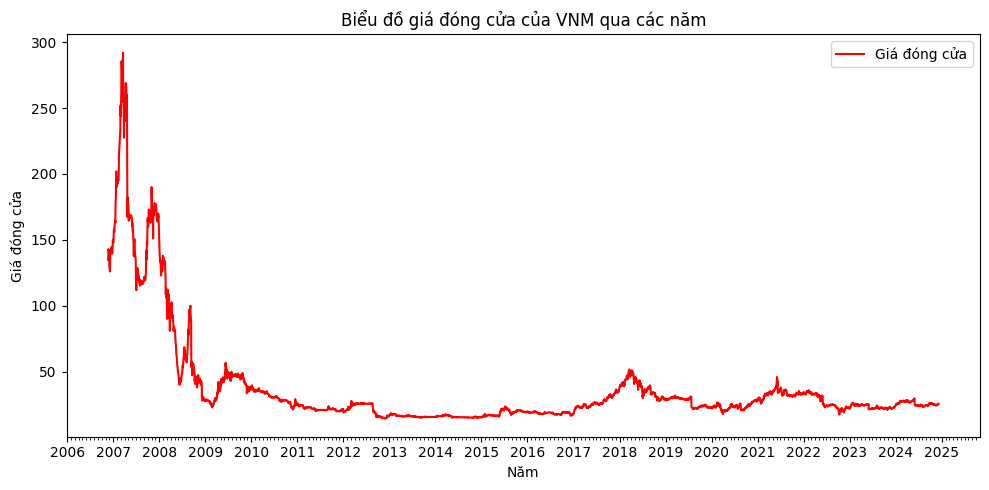

In [40]:
from matplotlib.dates import YearLocator, DateFormatter, MonthLocator # Thêm MonthLocator vào để sửa lỗi

# Lấy thông tin năm từ cột "Ngày"
df['Nam'] = df['Ngay'].dt.year

# Tạo đồ thị giá đóng cửa qua các năm
plt.figure(figsize=(10, 5))
plt.plot(df['Ngay'], df['GiaDongCua'], label='Giá đóng cửa', color='red')
plt.xlabel('Năm')
plt.ylabel('Giá đóng cửa')
plt.title('Biểu đồ giá đóng cửa của VNM qua các năm')
plt.legend(loc='best')

# Định dạng đồ thị hiển thị các ngày tháng theo năm-tháng
years = YearLocator()
yearsFmt = DateFormatter('%Y')
months = MonthLocator()  # Thêm dòng này để khai báo MonthLocator
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(yearsFmt)
plt.gca().xaxis.set_minor_locator(months)

plt.tight_layout()
plt.show()

In [41]:
# Chuyển đổi sang chỉ số thời gian
df1 = pd.DataFrame(df, columns=['Ngay', 'GiaDongCua'])
df1.index = df1['Ngay']
df1.drop('Ngay', axis=1, inplace=True)

In [42]:
df1

GiaDongCua
Ngay                  
2006-11-21      135.00
2006-11-22      135.00
2006-11-23      143.00
2006-11-27      142.00
2006-11-28      142.00
...                ...
2024-12-02       25.15
2024-12-03       25.00
2024-12-04       25.05
2024-12-05       25.70
2024-12-06       25.65

[4492 rows x 1 columns]

In [43]:
# Chia tập dữ liệu
data = df1.values
train_data = data[:int(len(df) * 0.8)]
test_data = data[int(len(df) * 0.8):]

In [44]:
data

array([[135.  ],
       [135.  ],
       [143.  ],
       ...,
       [ 25.05],
       [ 25.7 ],
       [ 25.65]])

In [45]:
# Chuẩn hóa dữ liệu
sc = MinMaxScaler(feature_range=(0, 1))
sc_train = sc.fit_transform(data)

In [46]:
# Tạo cửa sổ thời gian cho tập train
x_train, y_train = [], []
for i in range(50, len(train_data)):
    x_train.append(sc_train[i - 50:i, 0])  # 50 giá trị trước đó
    y_train.append(sc_train[i, 0])  # Giá trị tiếp theo
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [47]:
save_model_path = "models/ACB_model.keras"
# Tải mô hình tốt nhất
final_model = load_model(save_model_path)

In [48]:
# Dự đoán trên tập train
y_train_predict = final_model.predict(x_train)
y_train_predict = sc.inverse_transform(y_train_predict)
y_train = sc.inverse_transform(y_train.reshape(-1, 1))

111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step


In [49]:
#xử lý dữ liệu test
test = df1[len(train_data)-50:].values
test = test.reshape(-1,1)
sc_test = sc.transform(test)

x_test = []
for i in range(50,test.shape[0]):
  x_test.append(sc_test[i-50:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

#dữ liệu test
y_test = data[1500:] #giá thực
y_test_predict = final_model.predict(x_test)
y_test_predict = sc.inverse_transform(y_test_predict) #giá dự đoán

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


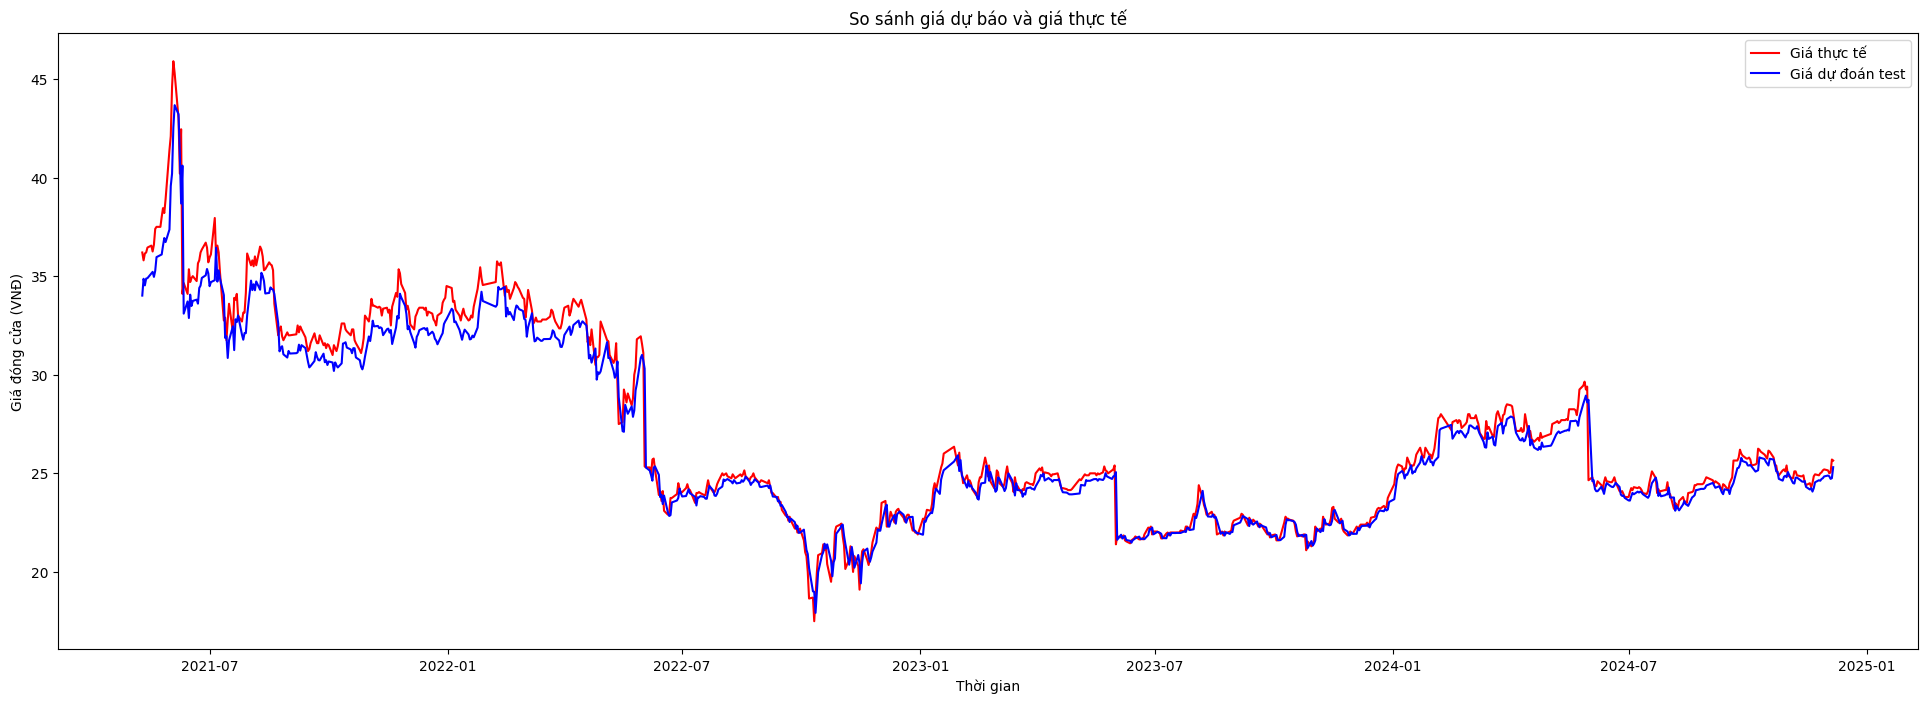

In [54]:
# Chọn dữ liệu cho test_data1
num_test_predictions = len(y_test_predict)
test_data1 = df.iloc[-num_test_predictions:].copy()
plt.figure(figsize=(24, 8))
if 'Ngay' in test_data1.columns:
    plt.plot(test_data1['Ngay'], test_data1['GiaDongCua'], label='Giá thực tế', color='red')
else:
    raise KeyError("Cột 'Ngày' không tồn tại trong test_data1.")

test_data1 = test_data1.copy()
test_data1['Dự đoán'] = y_test_predict.flatten()
plt.plot(test_data1['Ngay'], test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')
plt.title('So sánh giá dự báo và giá thực tế')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (VNĐ)')
plt.legend()
plt.show()


In [55]:
#r2
print('Độ phù hợp tập train:',r2_score(y_train,y_train_predict))
#mae
print('Sai số tuyệt đối trung bình trên tập train (VNĐ):',mean_absolute_error(y_train,y_train_predict))
#mae
print('Phần trăm sai số tuyệt đối trung bình tập train:',mean_absolute_percentage_error(y_train,y_train_predict))

Độ phù hợp tập train: 0.9872292583229992
Sai số tuyệt đối trung bình trên tập train (VNĐ): 1.8051785307283152
Phần trăm sai số tuyệt đối trung bình tập train: 0.0313366808494979


In [56]:
train_data1

GiaDongCua     Dự đoán
Ngay                              
2007-02-08      194.80  181.034164
2007-02-09      194.90  177.578583
2007-02-12      195.00  178.941925
2007-02-13      199.00  178.466263
2007-02-14      209.00  183.255371
...                ...         ...
2021-04-29       34.65   32.710732
2021-05-04       34.45   33.488022
2021-05-05       35.30   33.300949
2021-05-06       34.80   34.083065
2021-05-07       35.20   33.628731

[3543 rows x 2 columns]

In [58]:
y_test = data[-len(y_test_predict):]

In [59]:
#r2
print('Độ phù hợp tập test:',r2_score(y_test,y_test_predict))
#mae
print('Sai số tuyệt đối trung bình trên tập test (VNĐ):',mean_absolute_error(y_test,y_test_predict))
#mae
print('Phần trăm sai số tuyệt đối trung bình tập test:',mean_absolute_percentage_error(y_test,y_test_predict))

Độ phù hợp tập test: 0.9680668390805639
Sai số tuyệt đối trung bình trên tập test (VNĐ): 0.5998041778836022
Phần trăm sai số tuyệt đối trung bình tập test: 0.02058701547745753


--- Đang xử lý collection: ACB ---


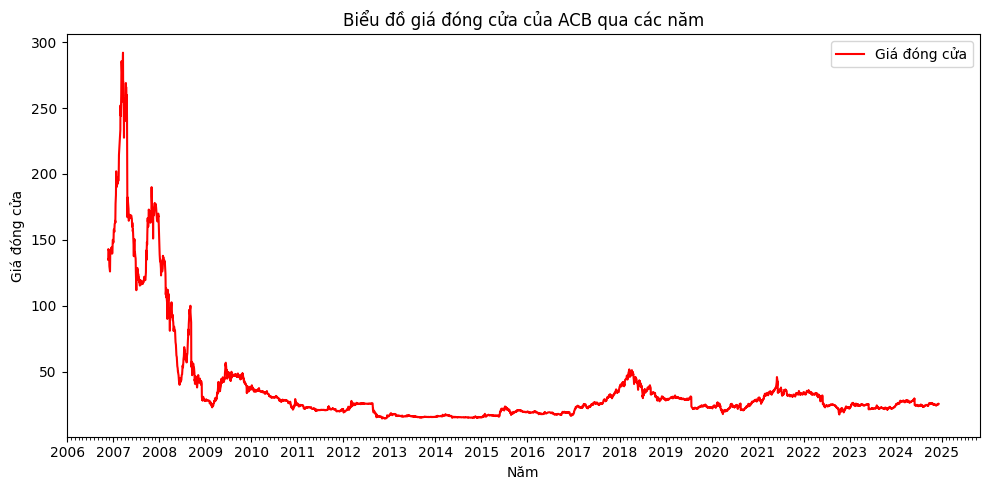

111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


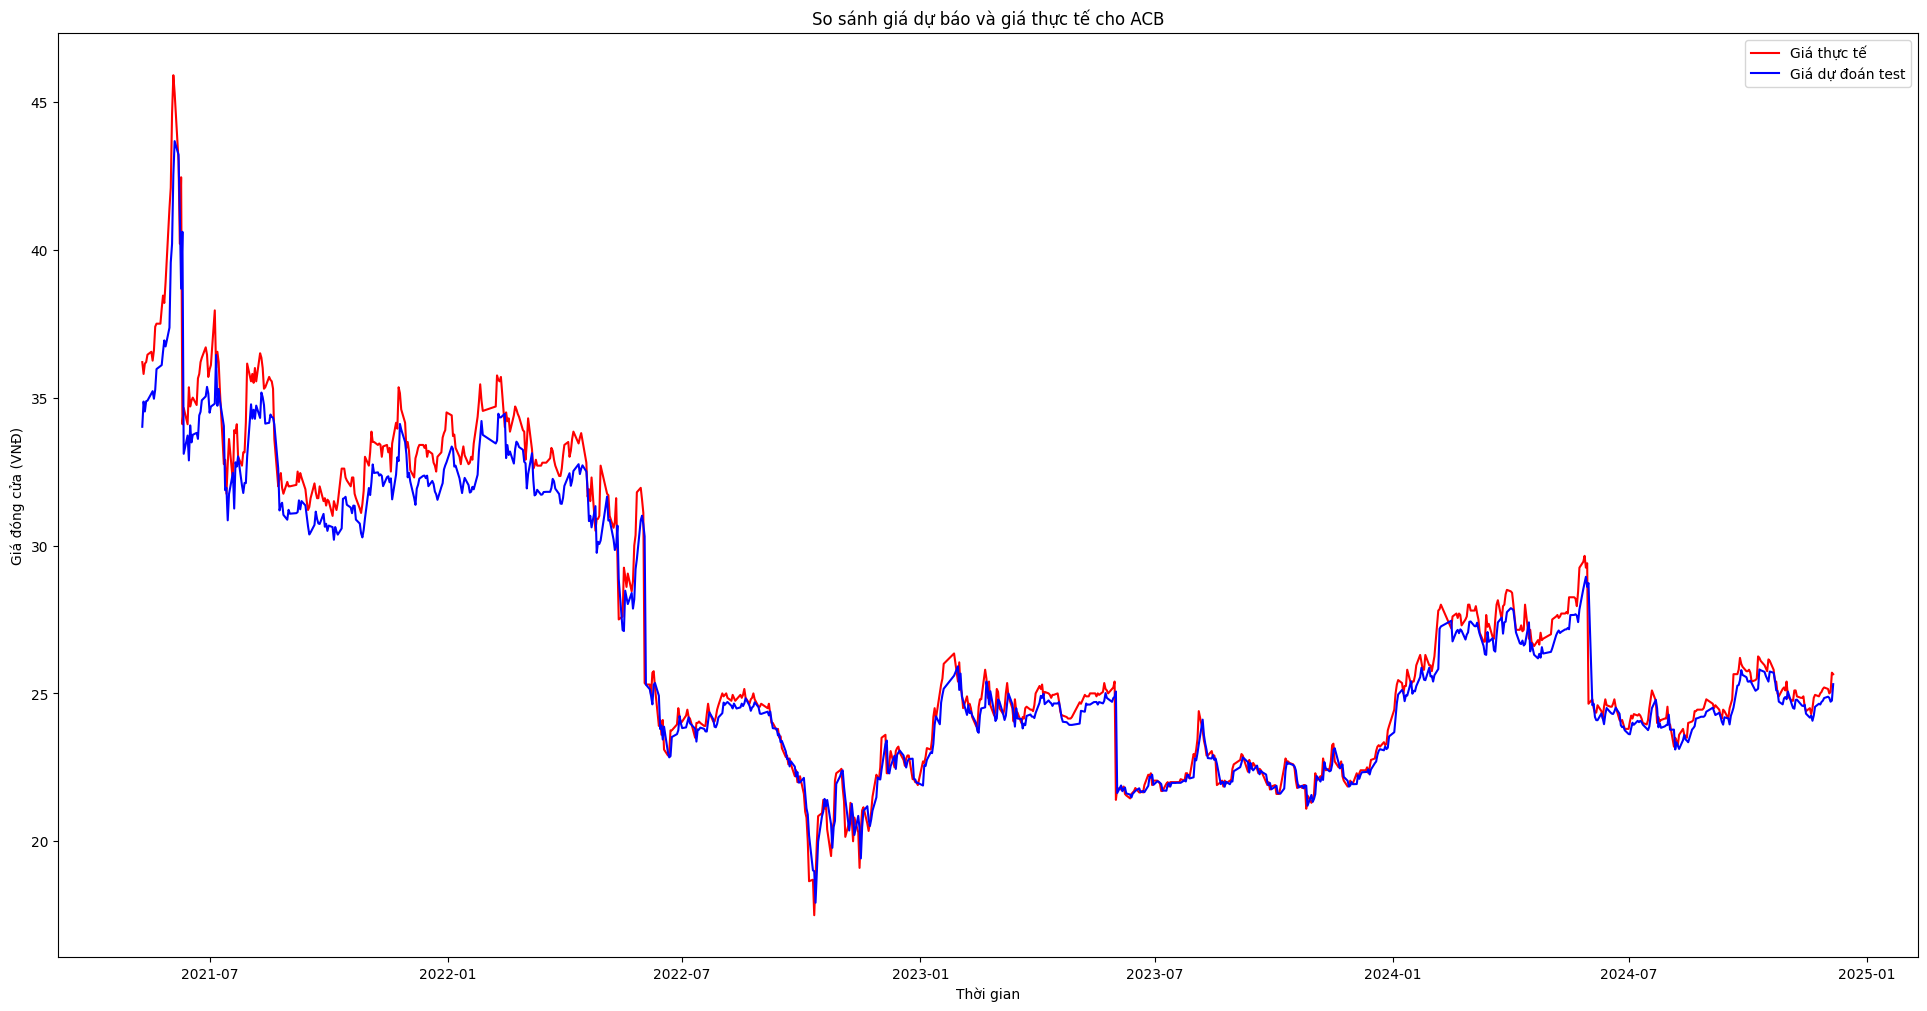

--- Kết quả cho collection: ACB ---
Độ phù hợp tập test (R2): 0.9680668390805639
Sai số tuyệt đối trung bình trên tập test (VNĐ): 0.5998041778836022
Phần trăm sai số tuyệt đối trung bình trên tập test: 0.02058701547745753
----------------------------------------------------
--- Đang xử lý collection: BCM ---


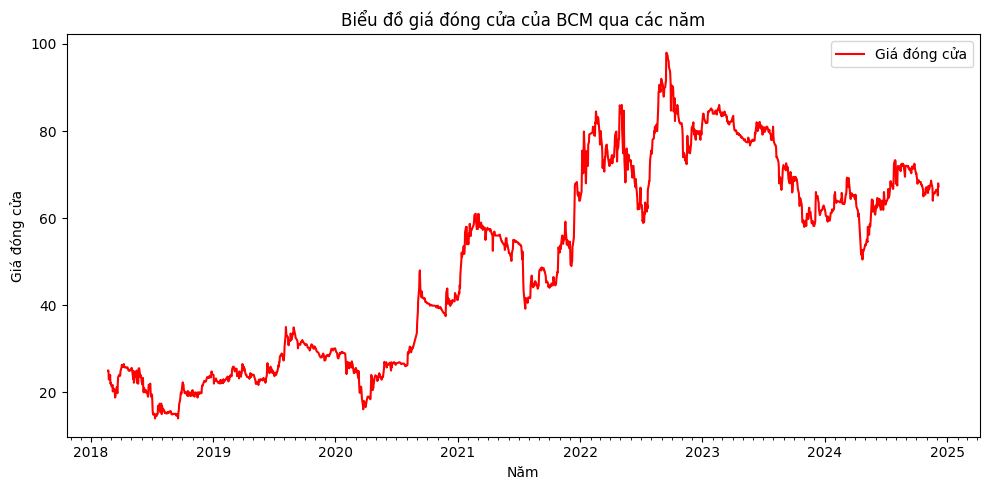

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


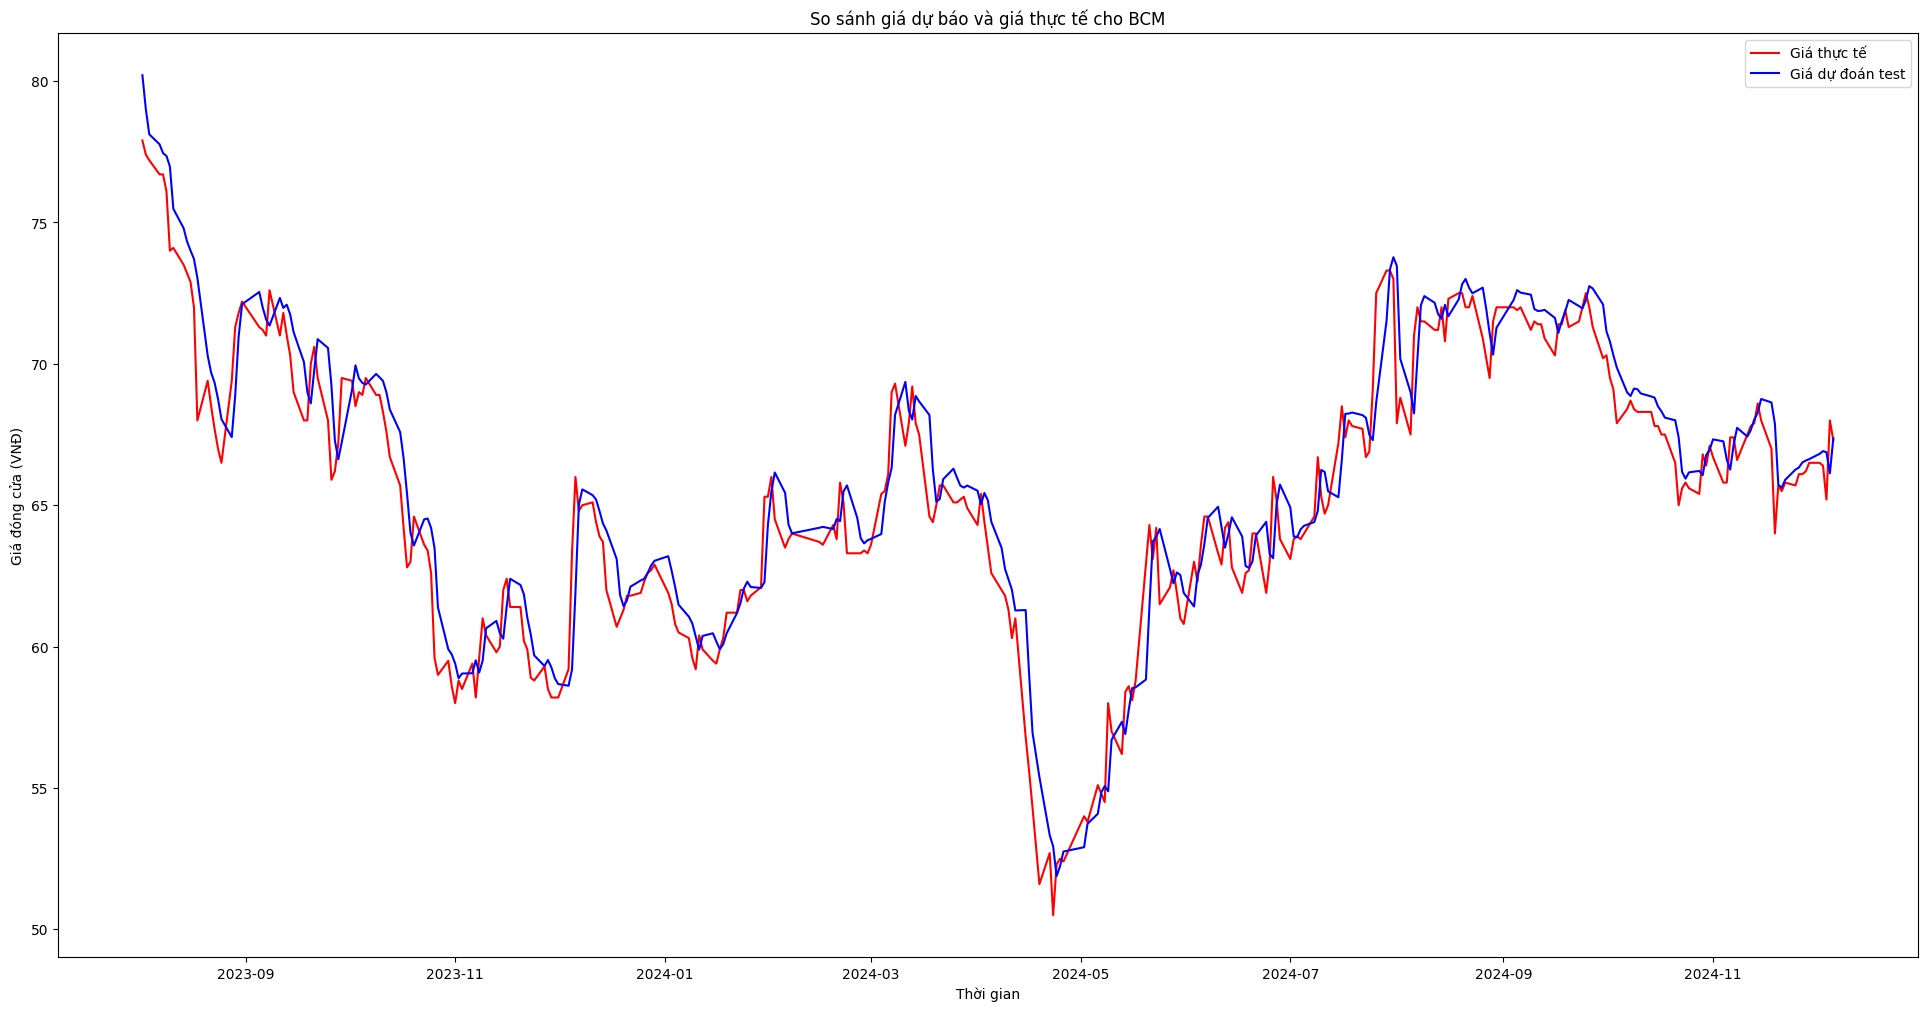

--- Kết quả cho collection: BCM ---
Độ phù hợp tập test (R2): 0.9187890990688472
Sai số tuyệt đối trung bình trên tập test (VNĐ): 1.062493367603043
Phần trăm sai số tuyệt đối trung bình trên tập test: 0.01637052342998386
----------------------------------------------------
--- Đang xử lý collection: BID ---


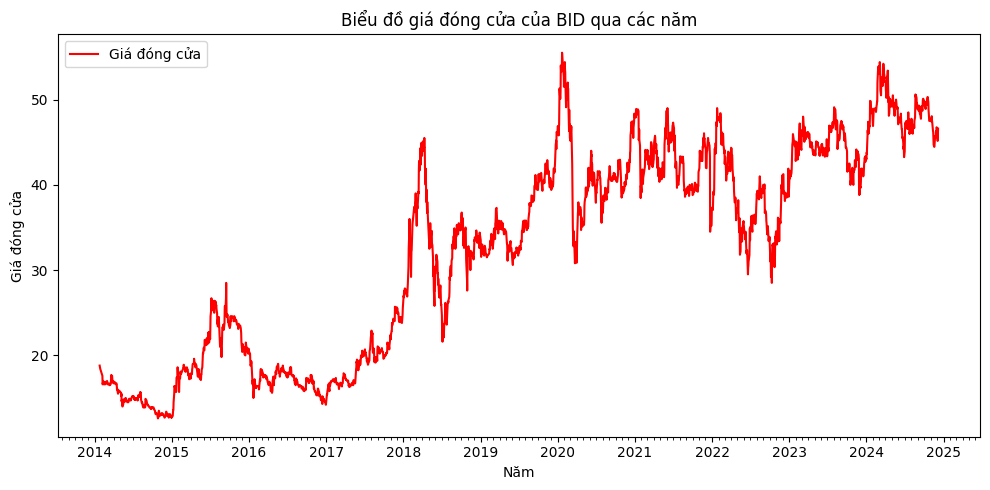

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


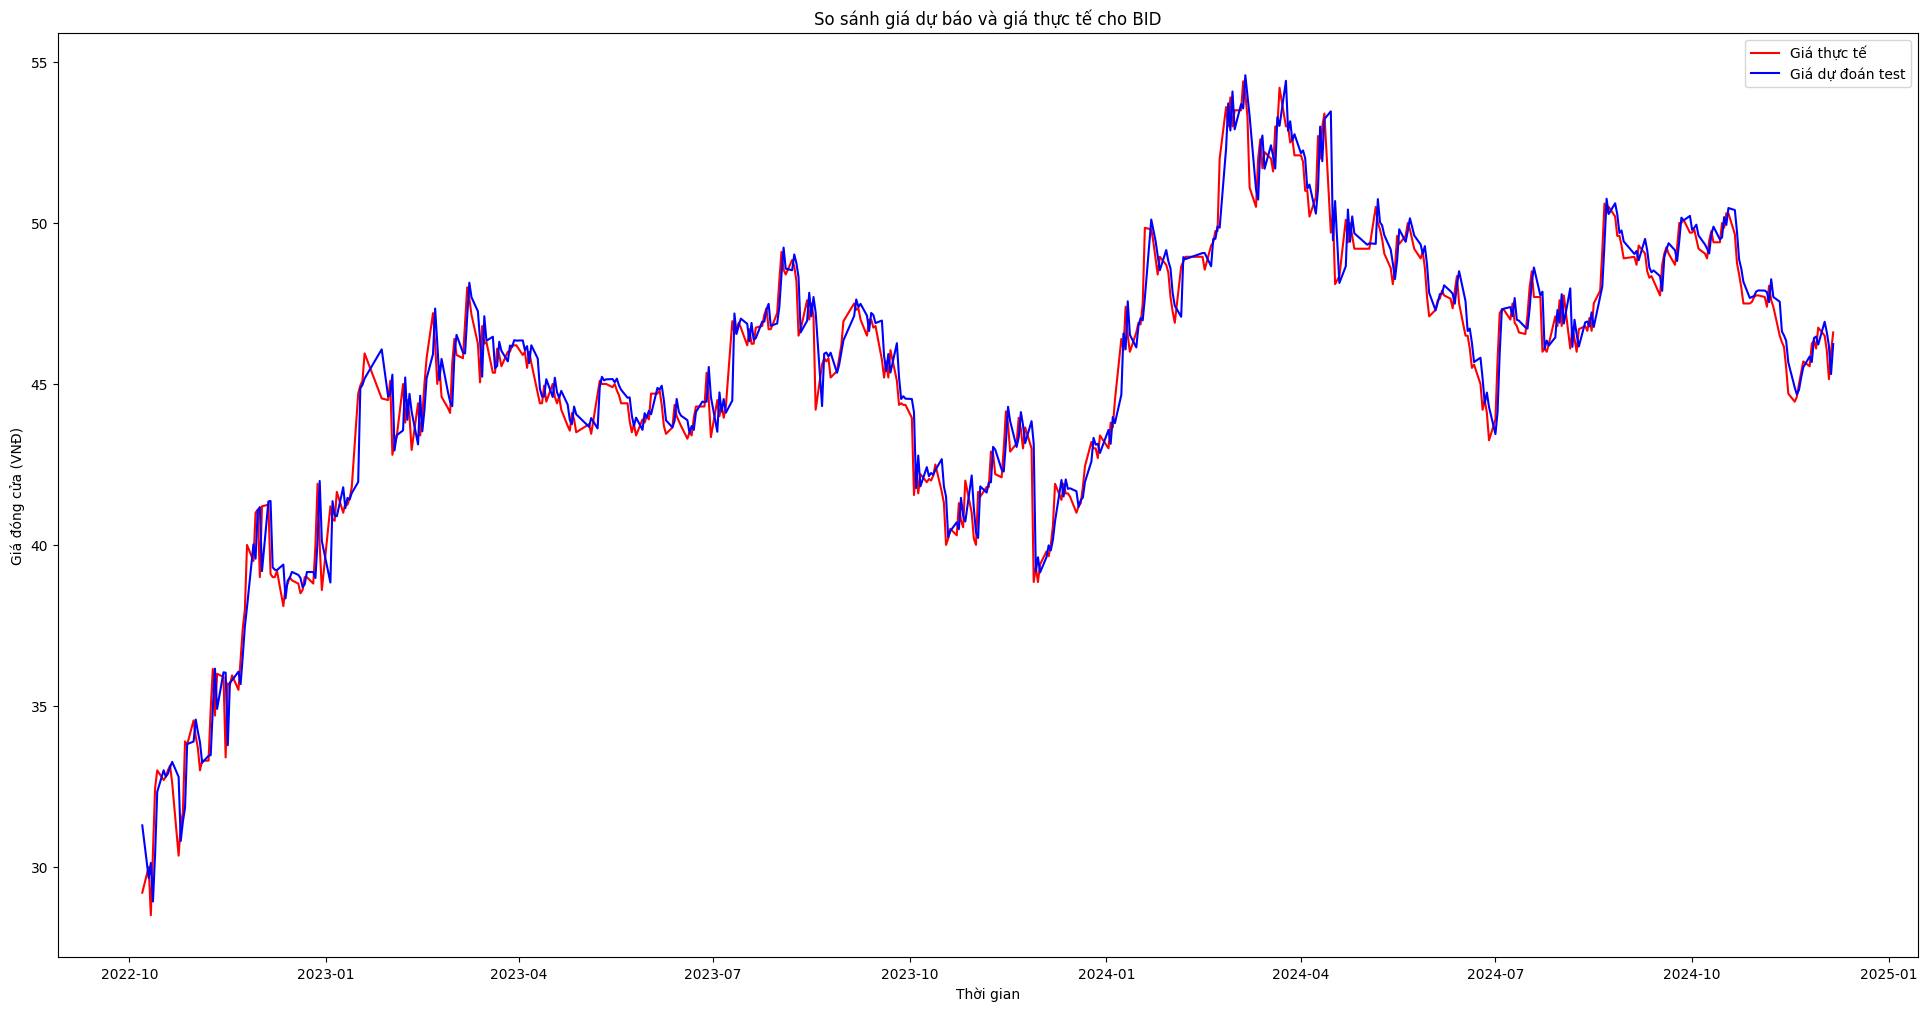

--- Kết quả cho collection: BID ---
Độ phù hợp tập test (R2): 0.9667236071082356
Sai số tuyệt đối trung bình trên tập test (VNĐ): 0.5982962192092811
Phần trăm sai số tuyệt đối trung bình trên tập test: 0.013597032682796783
----------------------------------------------------
--- Đang xử lý collection: BVH ---


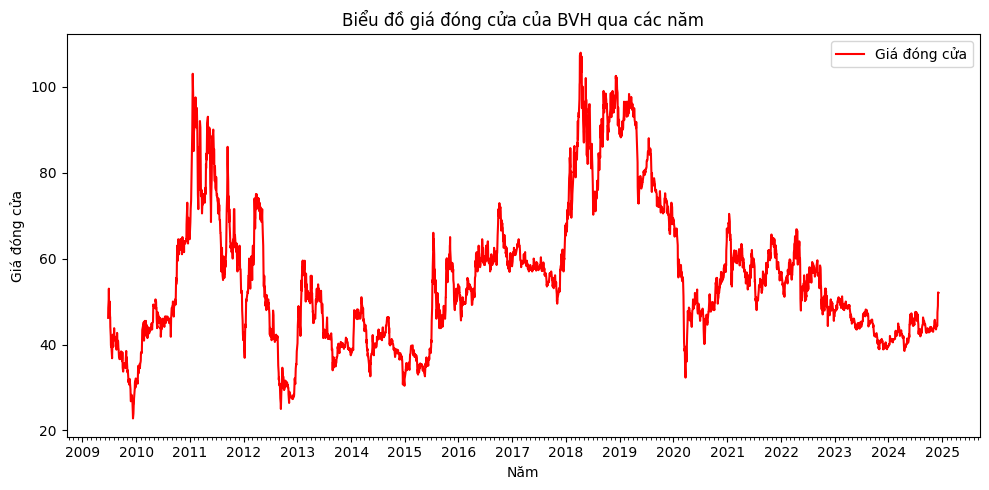

95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


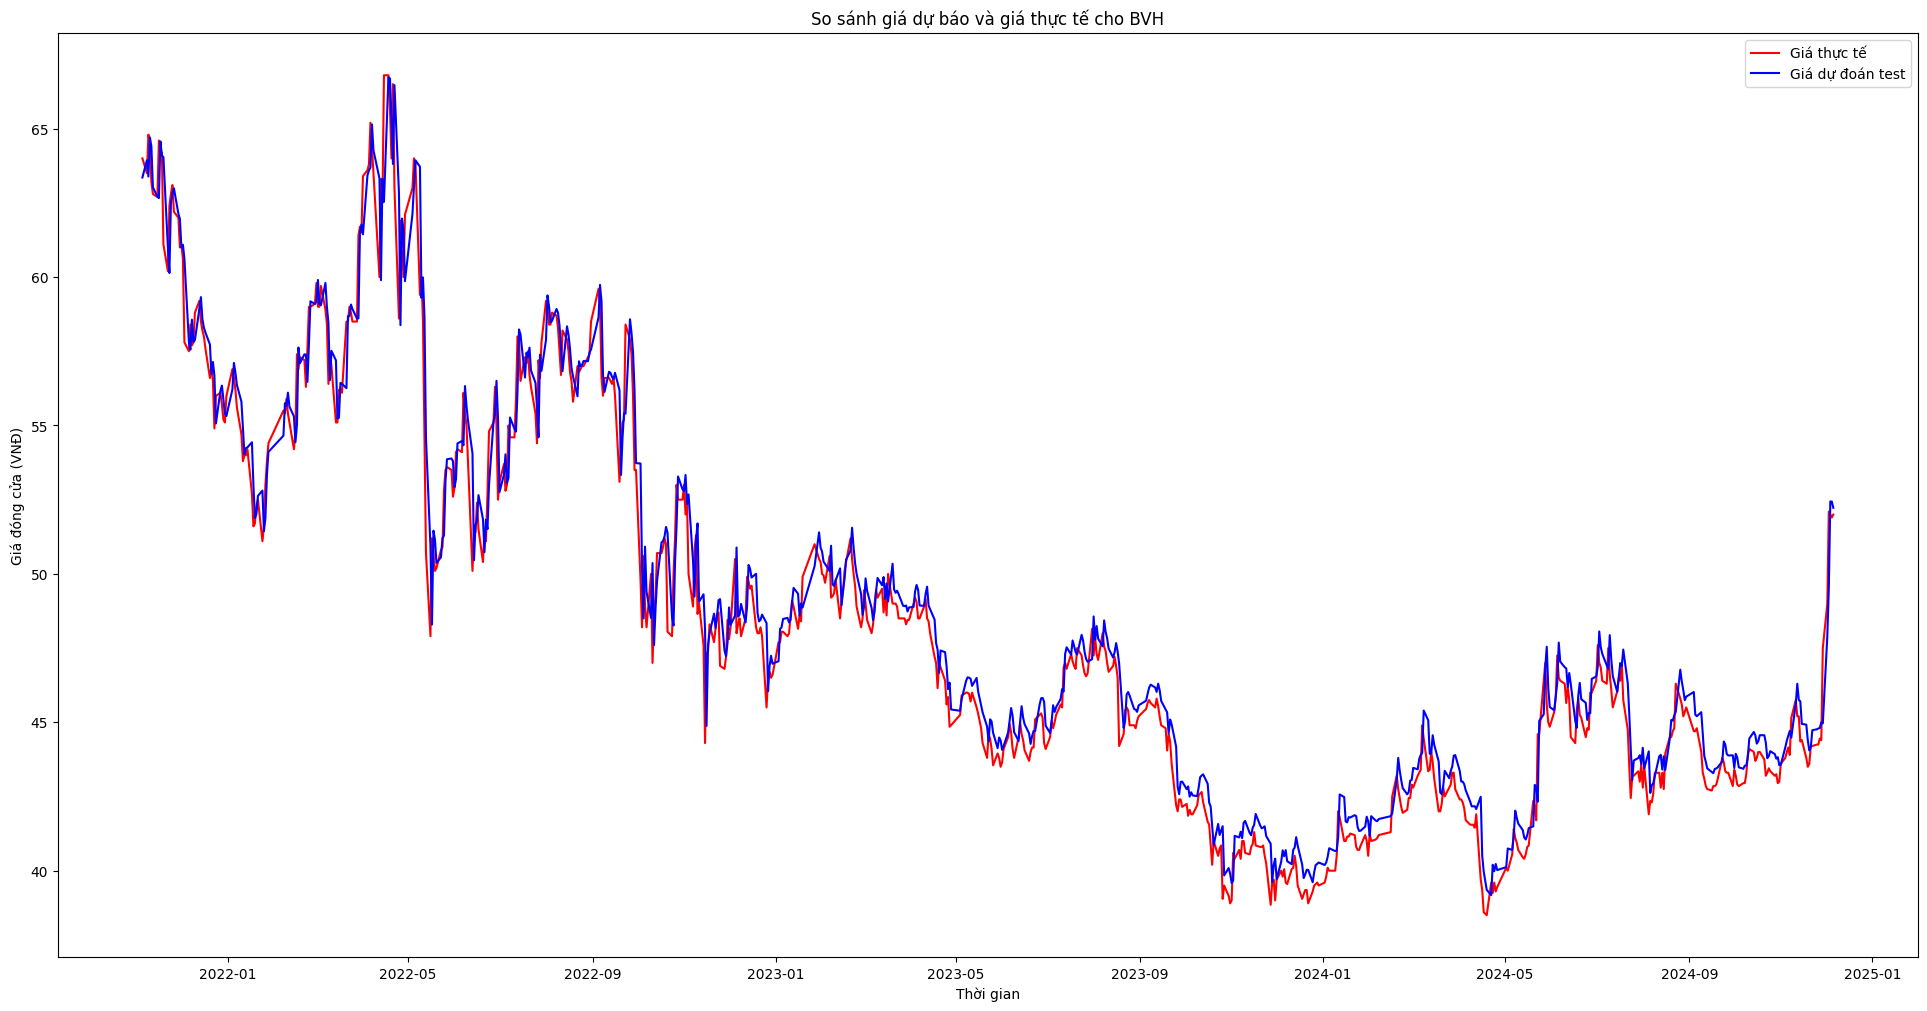

--- Kết quả cho collection: BVH ---
Độ phù hợp tập test (R2): 0.9741673921878955
Sai số tuyệt đối trung bình trên tập test (VNĐ): 0.790800522522605
Phần trăm sai số tuyệt đối trung bình trên tập test: 0.016363542911982033
----------------------------------------------------
--- Đang xử lý collection: CTG ---


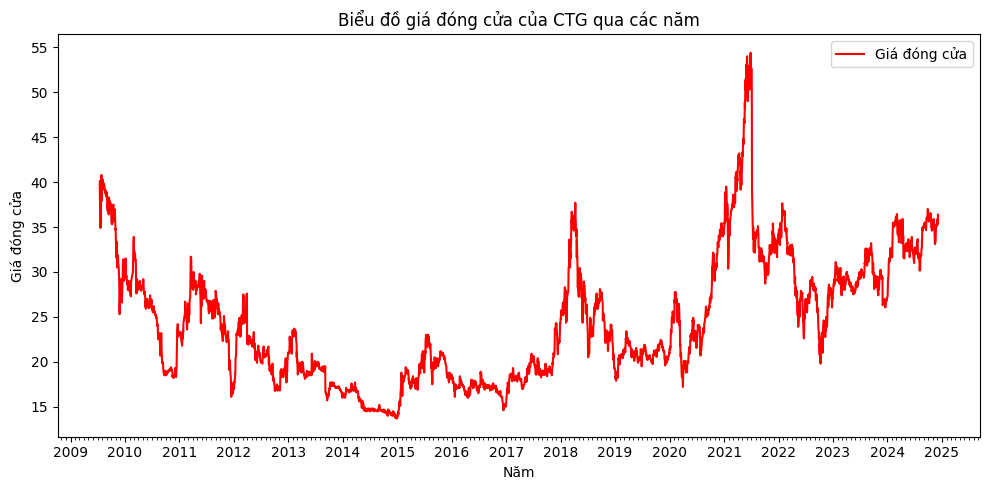

95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


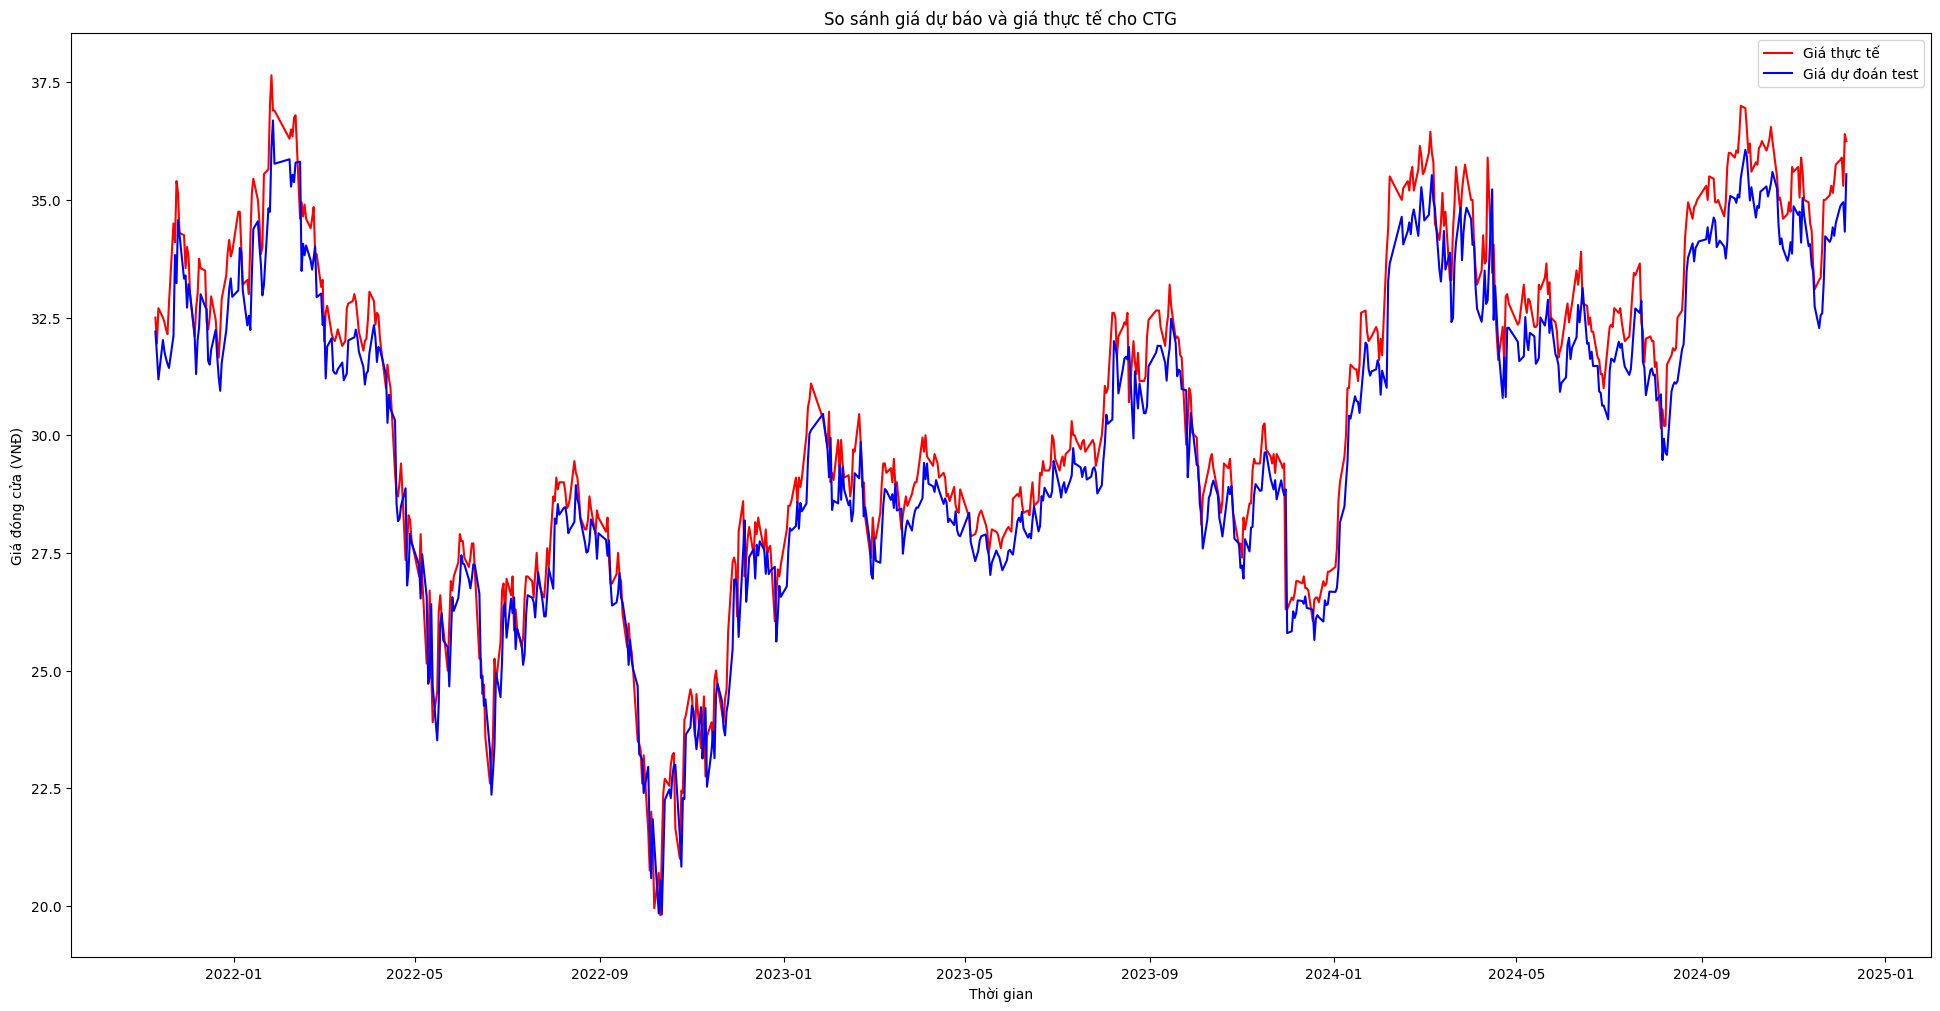

--- Kết quả cho collection: CTG ---
Độ phù hợp tập test (R2): 0.9385041681751997
Sai số tuyệt đối trung bình trên tập test (VNĐ): 0.7428988854813792
Phần trăm sai số tuyệt đối trung bình trên tập test: 0.02432856775364035
----------------------------------------------------


In [66]:
import pandas as pd  # Đọc dữ liệu
import numpy as np  # Xử lý dữ liệu
import matplotlib.pyplot as plt  # Vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler  # Chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint  # Lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model  # Tải mô hình

# Các lớp để xây dựng mô hình
from keras.models import Sequential  # Đầu vào
from keras.layers import LSTM  # Học phụ thuộc
from keras.layers import Dropout  # Tránh học tủ
from keras.layers import Dense  # Đầu ra

# Kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score  # Đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error  # Đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error  # Đo % sai số tuyệt đối trung bình

from pymongo import MongoClient

# Kết nối đến MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['metadata']  # Thay 'metadata' bằng tên database

# Danh sách các collections cần xử lý
collections = ["ACB", "BCM", "BID", "BVH", "CTG"]  # Thay các tên collections cần xử lý tại đây

for collection_name in collections:
    print(f"--- Đang xử lý collection: {collection_name} ---")
    
    # Lấy dữ liệu từ MongoDB
    collection = db[collection_name]
    df = pd.DataFrame(list(collection.find({}, {"_id": 0})))
    
    if df.empty:
        print(f"Collection {collection_name} không có dữ liệu.")
        continue

    # Xử lý thời gian và sắp xếp dữ liệu
    df['Ngay'] = pd.to_datetime(df['Ngay'], format='%Y-%m-%d')
    df = df.sort_values(by='Ngay')

    # Lấy thông tin năm từ cột "Ngày"
    df['Nam'] = df['Ngay'].dt.year

    # Tạo đồ thị giá đóng cửa qua các năm
    plt.figure(figsize=(10, 5))
    plt.plot(df['Ngay'], df['GiaDongCua'], label='Giá đóng cửa', color='red')
    plt.xlabel('Năm')
    plt.ylabel('Giá đóng cửa')
    plt.title(f'Biểu đồ giá đóng cửa của {collection_name} qua các năm')
    plt.legend(loc='best')

    from matplotlib.dates import YearLocator, DateFormatter, MonthLocator
    years = YearLocator()
    yearsFmt = DateFormatter('%Y')
    months = MonthLocator()
    plt.gca().xaxis.set_major_locator(years)
    plt.gca().xaxis.set_major_formatter(yearsFmt)
    plt.gca().xaxis.set_minor_locator(months)
    plt.tight_layout()
    plt.show()

    # Chuyển đổi sang chỉ số thời gian
    df1 = pd.DataFrame(df, columns=['Ngay', 'GiaDongCua'])
    df1.index = df1['Ngay']
    df1.drop('Ngay', axis=1, inplace=True)

    # Chia tập dữ liệu
    data = df1.values
    train_data = data[:int(len(df) * 0.8)]
    test_data = data[int(len(df) * 0.8):]

    # Chuẩn hóa dữ liệu
    sc = MinMaxScaler(feature_range=(0, 1))
    sc_train = sc.fit_transform(train_data)

    # Tạo cửa sổ thời gian cho tập train
    x_train, y_train = [], []
    for i in range(50, len(train_data)):
        x_train.append(sc_train[i - 50:i, 0])  # 50 giá trị trước đó
        y_train.append(sc_train[i, 0])  # Giá trị tiếp theo
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # Tải mô hình tốt nhất
    save_model_path = f"models/{collection_name}_model.keras"
    final_model = load_model(save_model_path)

    # Dự đoán trên tập train
    y_train_predict = final_model.predict(x_train)
    y_train_predict = sc.inverse_transform(y_train_predict)
    y_train = sc.inverse_transform(y_train.reshape(-1, 1))

    # Xử lý dữ liệu test
    test = df1[len(train_data) - 50:].values
    test = test.reshape(-1, 1)
    sc_test = sc.transform(test)

    x_test = []
    for i in range(50, test.shape[0]):
        x_test.append(sc_test[i - 50:i, 0])
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    # Dự đoán trên tập test
    y_test = data[-len(x_test):]  # Giá trị thực
    y_test_predict = final_model.predict(x_test)
    y_test_predict = sc.inverse_transform(y_test_predict)  # Giá dự đoán

    # So sánh giá dự báo và giá thực tế
    num_test_predictions = len(y_test_predict)
    test_data1 = df.iloc[-num_test_predictions:].copy()
    plt.figure(figsize=(24, 12))
    if 'Ngay' in test_data1.columns:
        plt.plot(test_data1['Ngay'], test_data1['GiaDongCua'], label='Giá thực tế', color='red')
    else:
        raise KeyError("Cột 'Ngay' không tồn tại trong test_data1.")

    test_data1['Dự đoán'] = y_test_predict.flatten()
    plt.plot(test_data1['Ngay'], test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')
    plt.title(f'So sánh giá dự báo và giá thực tế cho {collection_name}')
    plt.xlabel('Thời gian')
    plt.ylabel('Giá đóng cửa (VNĐ)')
    plt.legend()
    plt.show()

    # Đánh giá mô hình
    r2 = r2_score(y_test, y_test_predict)
    mae = mean_absolute_error(y_test, y_test_predict)
    mape = mean_absolute_percentage_error(y_test, y_test_predict)
    
    print(f"--- Kết quả cho collection: {collection_name} ---")
    print('Độ phù hợp tập test (R2):', r2)
    print('Sai số tuyệt đối trung bình trên tập test (VNĐ):', mae)
    print('Phần trăm sai số tuyệt đối trung bình trên tập test:', mape)
    print("----------------------------------------------------")


--- Đang xử lý collection: FPT ---


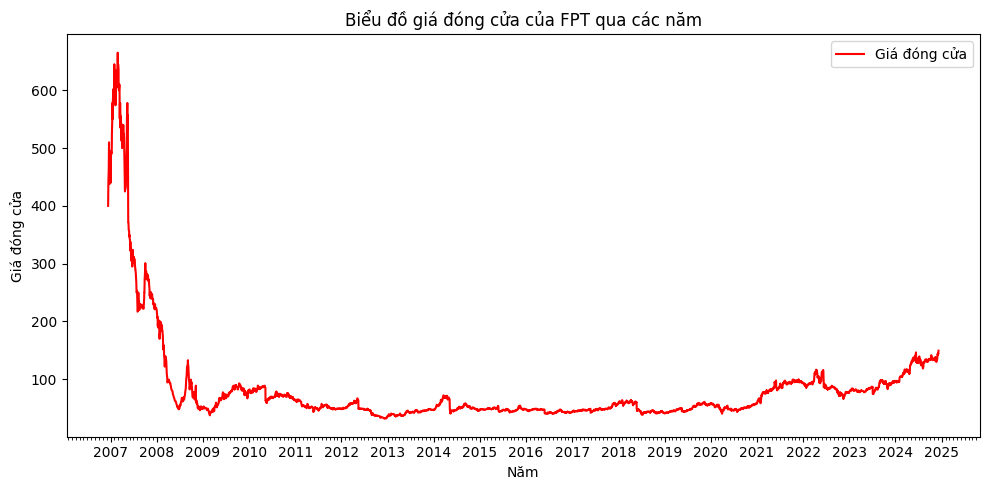

111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


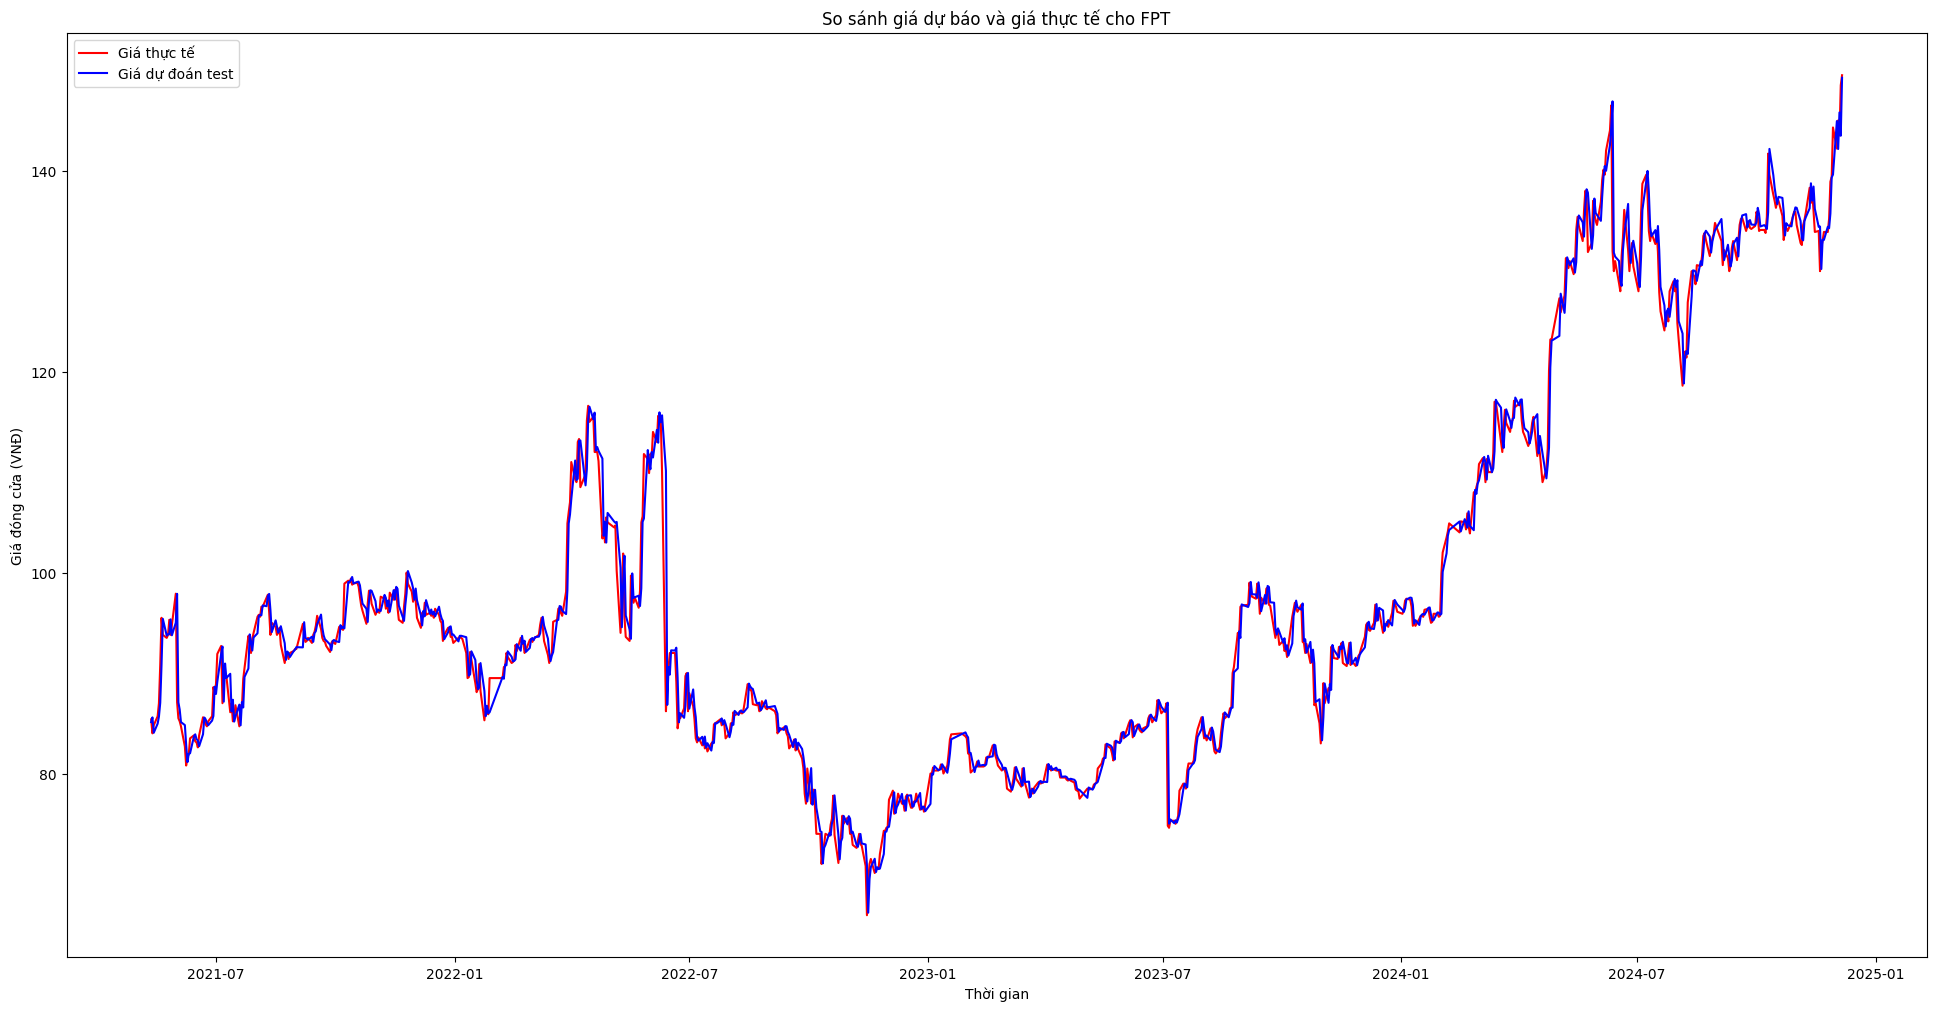

--- Kết quả cho collection: FPT ---
Độ phù hợp tập test (R2): 0.9892750846630338
Sai số tuyệt đối trung bình trên tập test (VNĐ): 1.1953361638812319
Phần trăm sai số tuyệt đối trung bình trên tập test: 0.012145793409974714
----------------------------------------------------
--- Đang xử lý collection: GAS ---


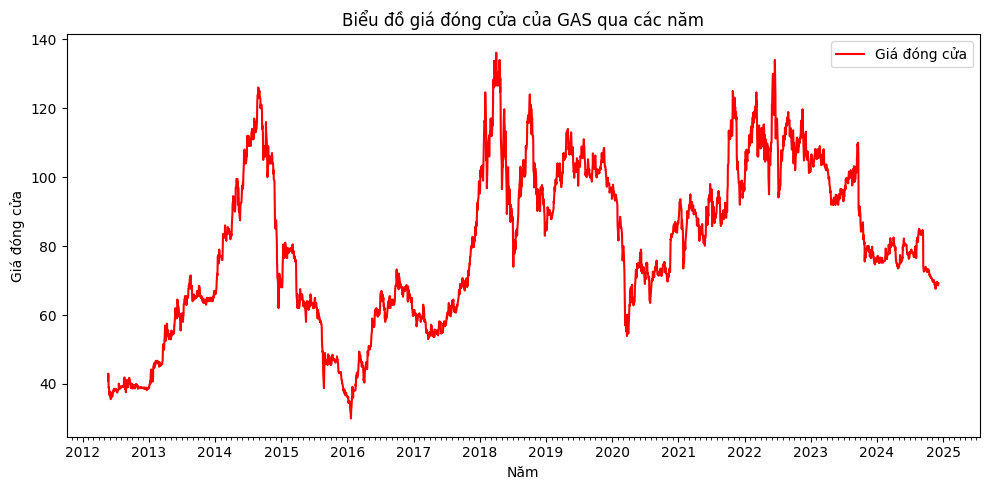

77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


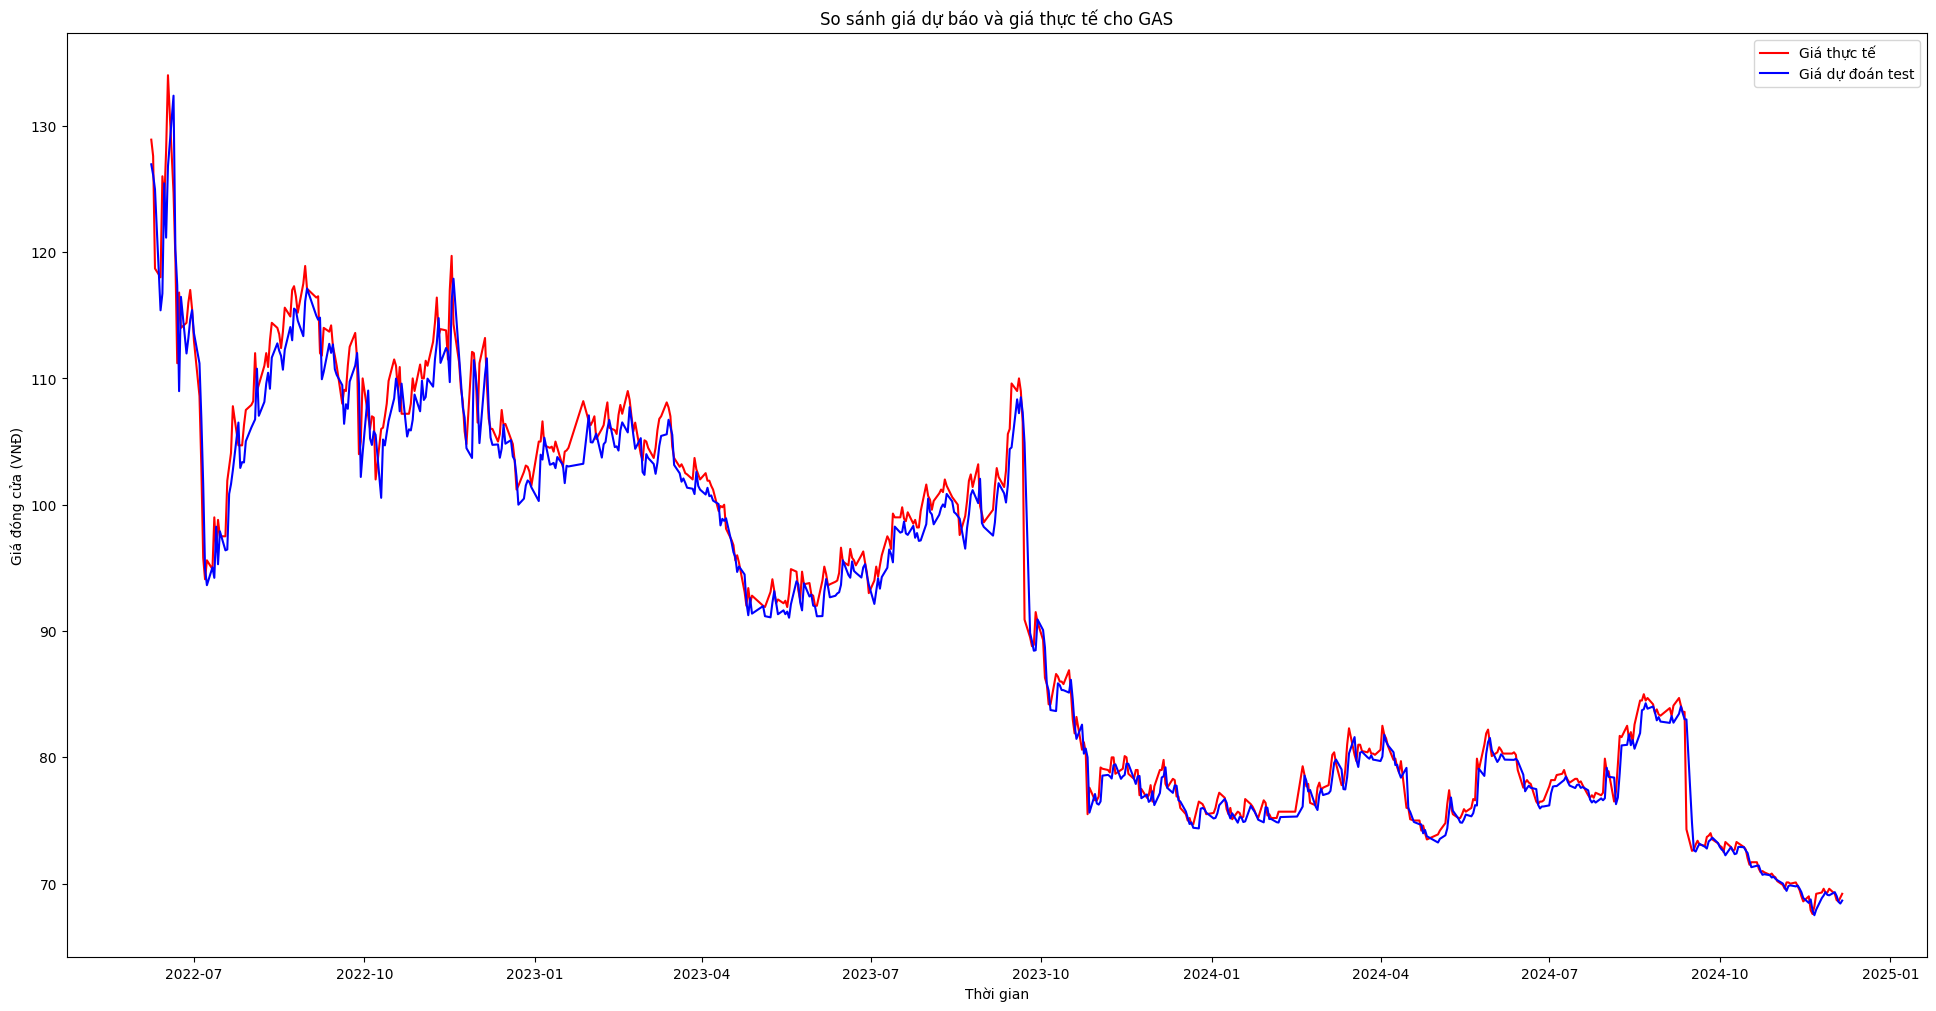

--- Kết quả cho collection: GAS ---
Độ phù hợp tập test (R2): 0.9829727133167786
Sai số tuyệt đối trung bình trên tập test (VNĐ): 1.2965269489652793
Phần trăm sai số tuyệt đối trung bình trên tập test: 0.013355428523320891
----------------------------------------------------
--- Đang xử lý collection: GVR ---


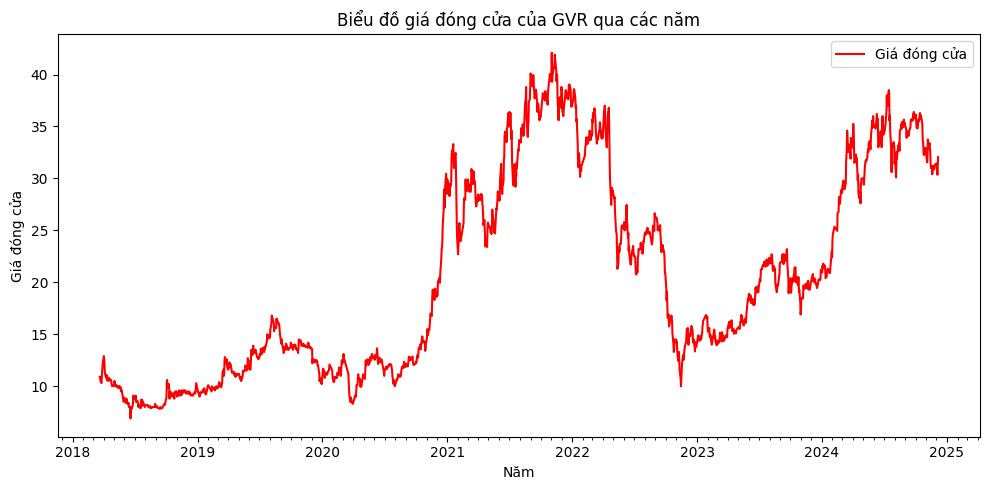

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


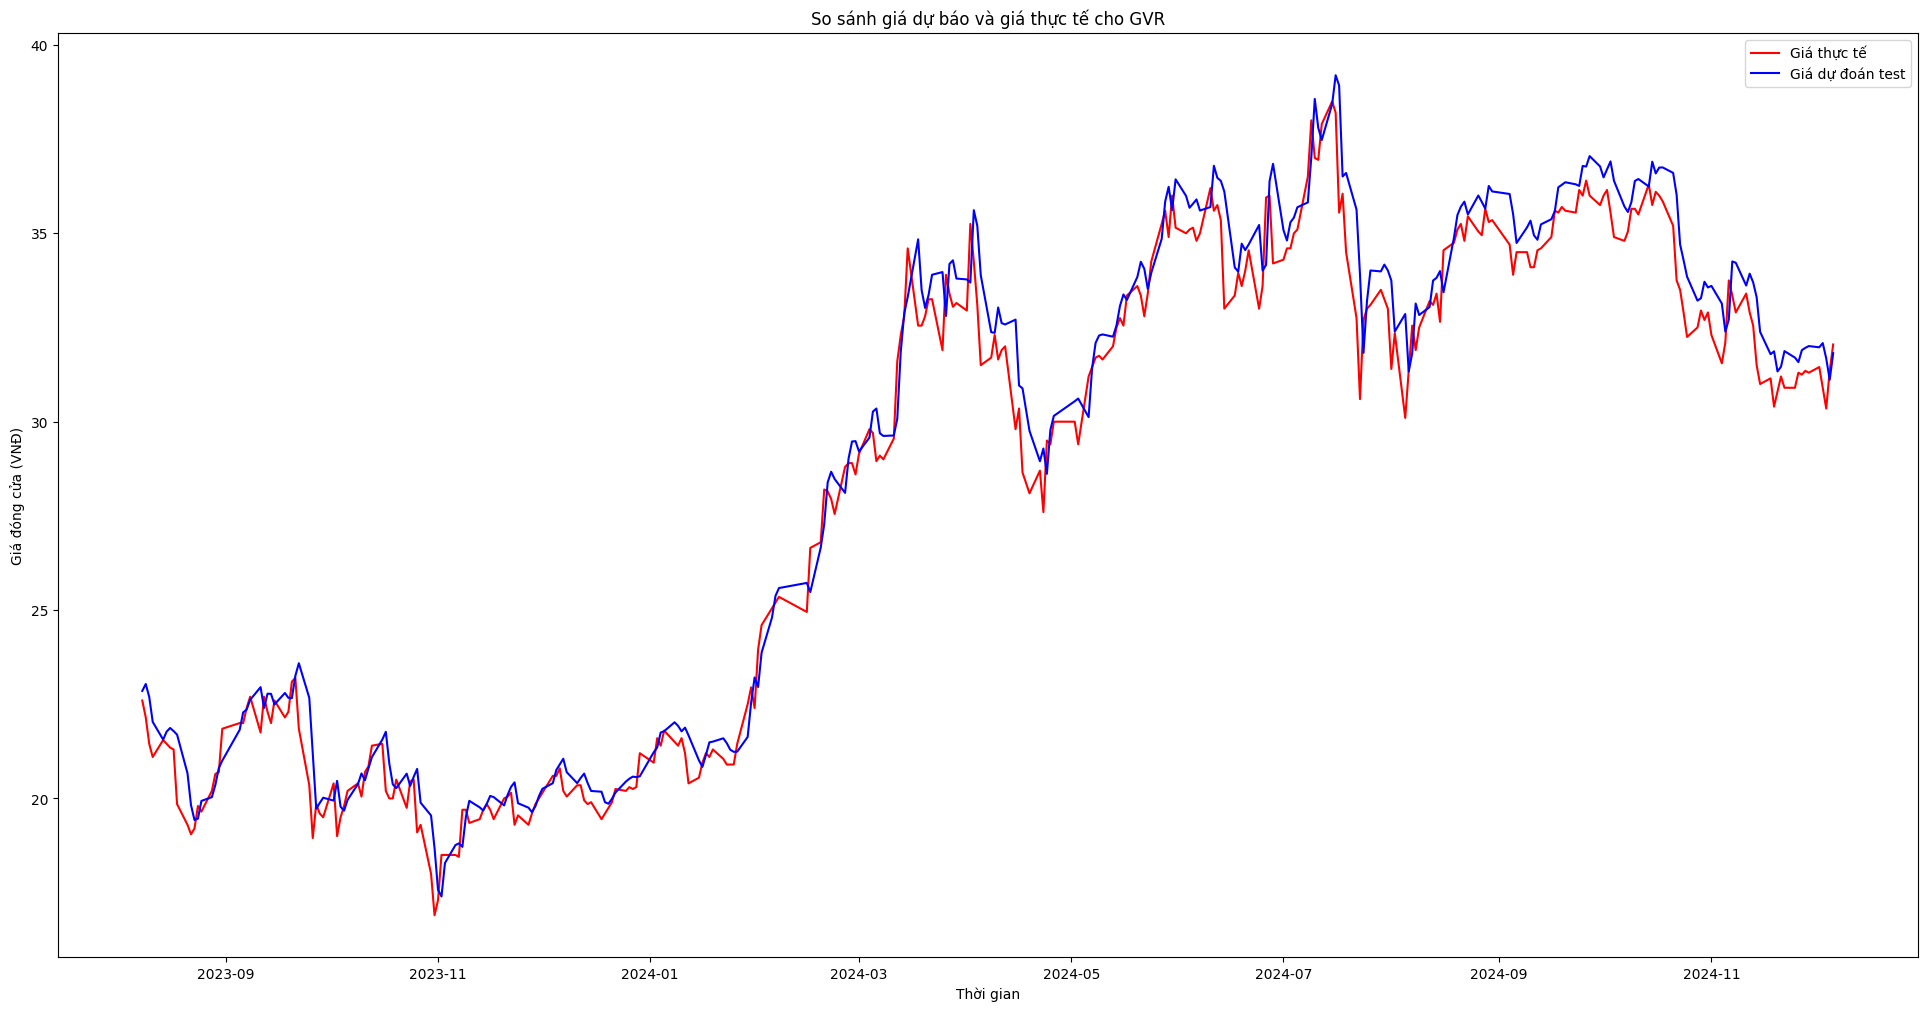

--- Kết quả cho collection: GVR ---
Độ phù hợp tập test (R2): 0.977798463386726
Sai số tuyệt đối trung bình trên tập test (VNĐ): 0.7201041492063609
Phần trăm sai số tuyệt đối trung bình trên tập test: 0.02552288599218311
----------------------------------------------------
--- Đang xử lý collection: HDB ---


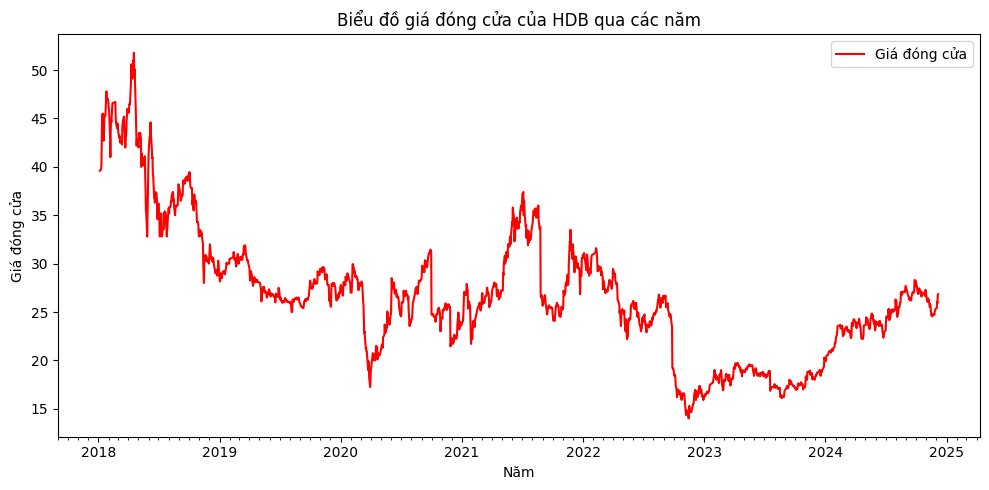

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


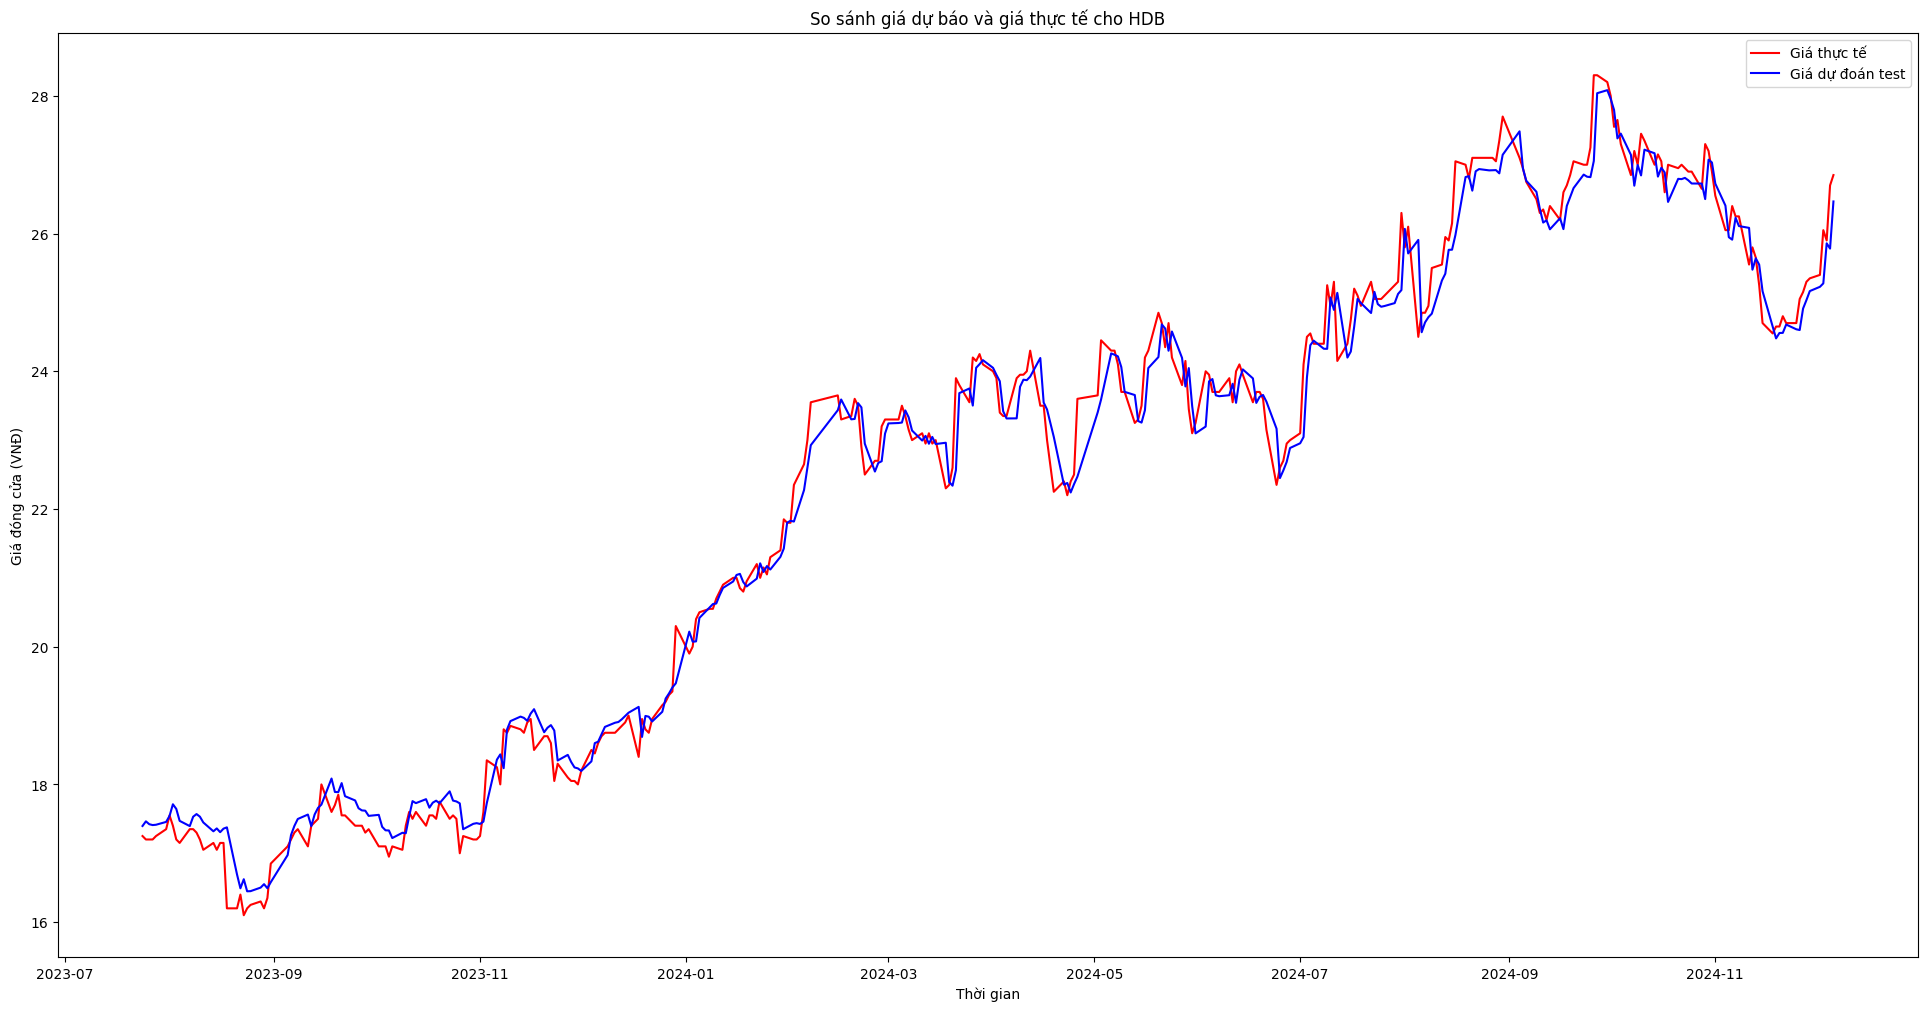

--- Kết quả cho collection: HDB ---
Độ phù hợp tập test (R2): 0.9899157359596429
Sai số tuyệt đối trung bình trên tập test (VNĐ): 0.2629902635695617
Phần trăm sai số tuyệt đối trung bình trên tập test: 0.011935962749149601
----------------------------------------------------
--- Đang xử lý collection: HPG ---


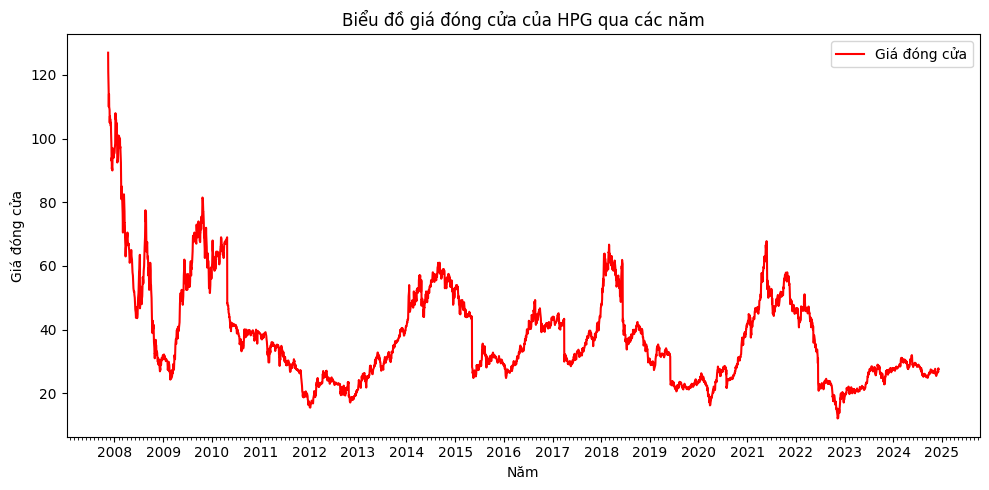

105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


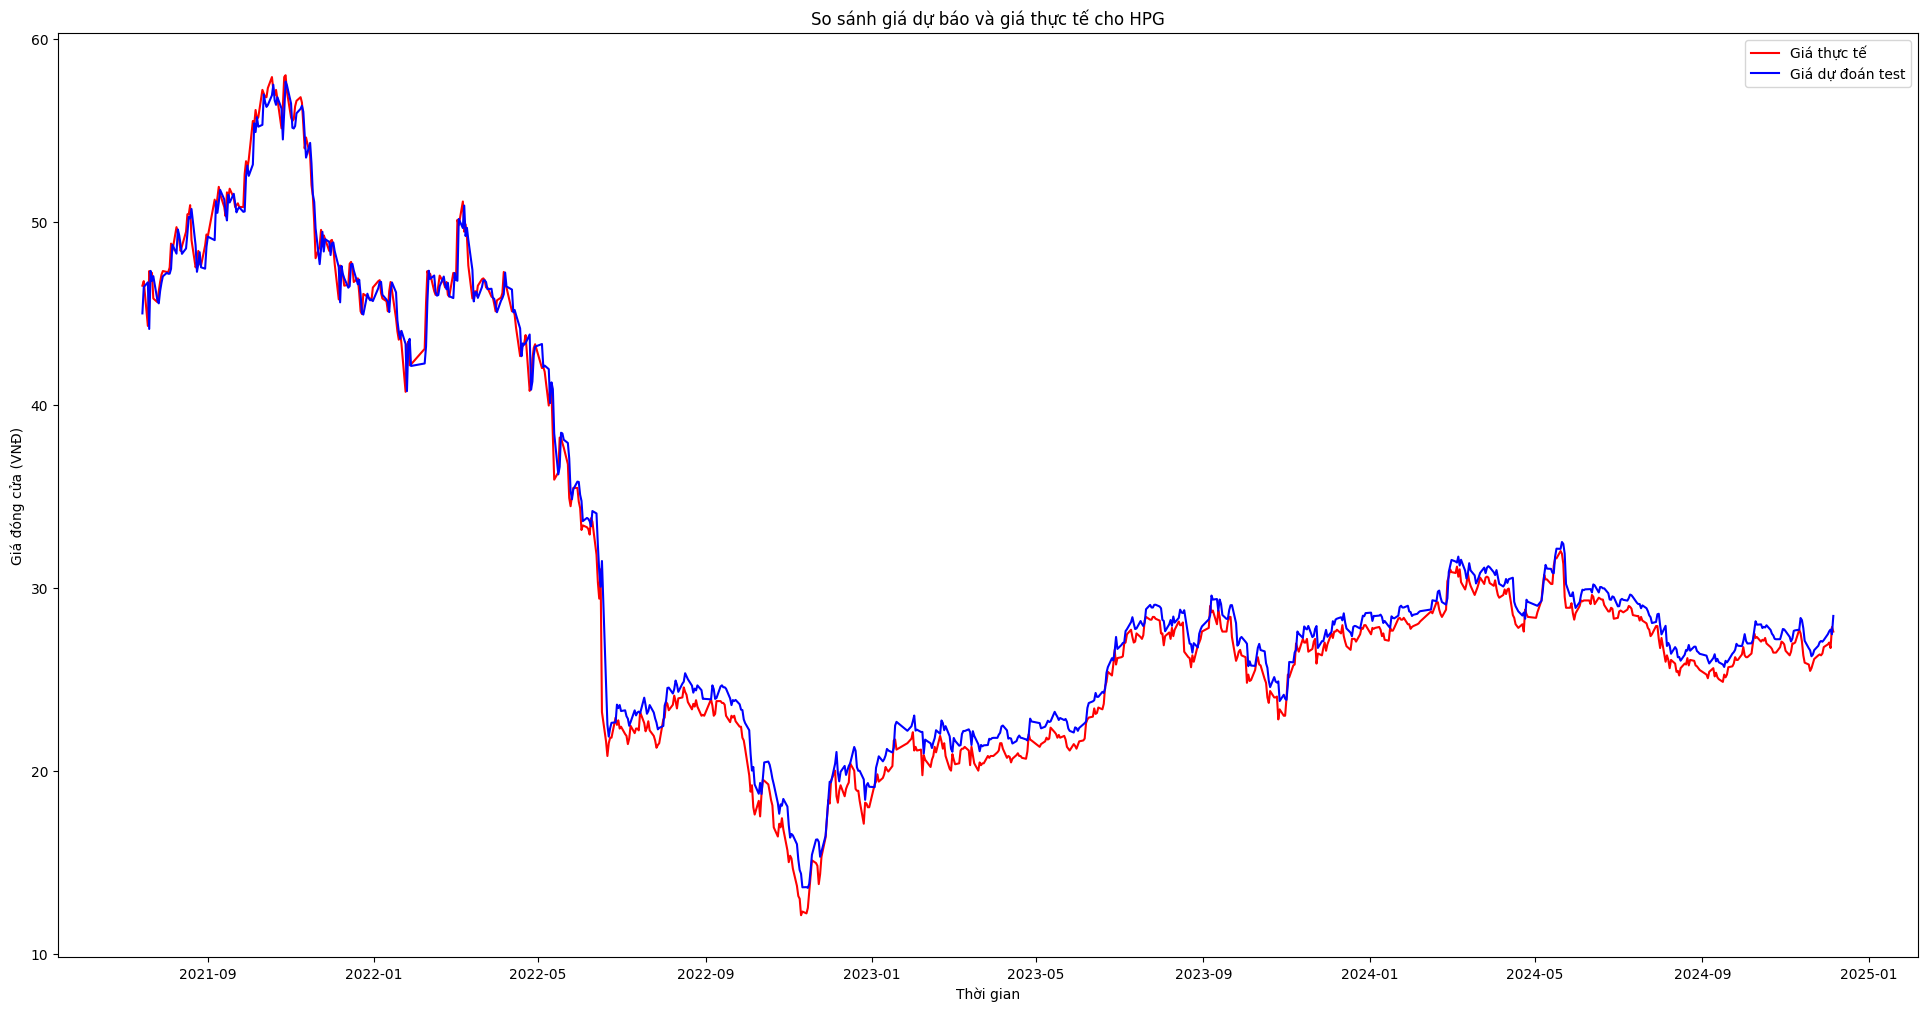

--- Kết quả cho collection: HPG ---
Độ phù hợp tập test (R2): 0.9914277312372209
Sai số tuyệt đối trung bình trên tập test (VNĐ): 0.8107476432791327
Phần trăm sai số tuyệt đối trung bình trên tập test: 0.031193646005672343
----------------------------------------------------


In [67]:
import pandas as pd  # Đọc dữ liệu
import numpy as np  # Xử lý dữ liệu
import matplotlib.pyplot as plt  # Vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler  # Chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint  # Lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model  # Tải mô hình

# Các lớp để xây dựng mô hình
from keras.models import Sequential  # Đầu vào
from keras.layers import LSTM  # Học phụ thuộc
from keras.layers import Dropout  # Tránh học tủ
from keras.layers import Dense  # Đầu ra

# Kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score  # Đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error  # Đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error  # Đo % sai số tuyệt đối trung bình

from pymongo import MongoClient

# Kết nối đến MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['metadata']  # Thay 'metadata' bằng tên database

# Danh sách các collections cần xử lý
collections = ["FPT", "GAS", "GVR", "HDB", "HPG"]  # Thay các tên collections cần xử lý tại đây

for collection_name in collections:
    print(f"--- Đang xử lý collection: {collection_name} ---")
    
    # Lấy dữ liệu từ MongoDB
    collection = db[collection_name]
    df = pd.DataFrame(list(collection.find({}, {"_id": 0})))
    
    if df.empty:
        print(f"Collection {collection_name} không có dữ liệu.")
        continue

    # Xử lý thời gian và sắp xếp dữ liệu
    df['Ngay'] = pd.to_datetime(df['Ngay'], format='%Y-%m-%d')
    df = df.sort_values(by='Ngay')

    # Lấy thông tin năm từ cột "Ngày"
    df['Nam'] = df['Ngay'].dt.year

    # Tạo đồ thị giá đóng cửa qua các năm
    plt.figure(figsize=(10, 5))
    plt.plot(df['Ngay'], df['GiaDongCua'], label='Giá đóng cửa', color='red')
    plt.xlabel('Năm')
    plt.ylabel('Giá đóng cửa')
    plt.title(f'Biểu đồ giá đóng cửa của {collection_name} qua các năm')
    plt.legend(loc='best')

    from matplotlib.dates import YearLocator, DateFormatter, MonthLocator
    years = YearLocator()
    yearsFmt = DateFormatter('%Y')
    months = MonthLocator()
    plt.gca().xaxis.set_major_locator(years)
    plt.gca().xaxis.set_major_formatter(yearsFmt)
    plt.gca().xaxis.set_minor_locator(months)
    plt.tight_layout()
    plt.show()

    # Chuyển đổi sang chỉ số thời gian
    df1 = pd.DataFrame(df, columns=['Ngay', 'GiaDongCua'])
    df1.index = df1['Ngay']
    df1.drop('Ngay', axis=1, inplace=True)

    # Chia tập dữ liệu
    data = df1.values
    train_data = data[:int(len(df) * 0.8)]
    test_data = data[int(len(df) * 0.8):]

    # Chuẩn hóa dữ liệu
    sc = MinMaxScaler(feature_range=(0, 1))
    sc_train = sc.fit_transform(train_data)

    # Tạo cửa sổ thời gian cho tập train
    x_train, y_train = [], []
    for i in range(50, len(train_data)):
        x_train.append(sc_train[i - 50:i, 0])  # 50 giá trị trước đó
        y_train.append(sc_train[i, 0])  # Giá trị tiếp theo
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # Tải mô hình tốt nhất
    save_model_path = f"models/{collection_name}_model.keras"
    final_model = load_model(save_model_path)

    # Dự đoán trên tập train
    y_train_predict = final_model.predict(x_train)
    y_train_predict = sc.inverse_transform(y_train_predict)
    y_train = sc.inverse_transform(y_train.reshape(-1, 1))

    # Xử lý dữ liệu test
    test = df1[len(train_data) - 50:].values
    test = test.reshape(-1, 1)
    sc_test = sc.transform(test)

    x_test = []
    for i in range(50, test.shape[0]):
        x_test.append(sc_test[i - 50:i, 0])
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    # Dự đoán trên tập test
    y_test = data[-len(x_test):]  # Giá trị thực
    y_test_predict = final_model.predict(x_test)
    y_test_predict = sc.inverse_transform(y_test_predict)  # Giá dự đoán

    # So sánh giá dự báo và giá thực tế
    num_test_predictions = len(y_test_predict)
    test_data1 = df.iloc[-num_test_predictions:].copy()
    plt.figure(figsize=(24, 12))
    if 'Ngay' in test_data1.columns:
        plt.plot(test_data1['Ngay'], test_data1['GiaDongCua'], label='Giá thực tế', color='red')
    else:
        raise KeyError("Cột 'Ngay' không tồn tại trong test_data1.")

    test_data1['Dự đoán'] = y_test_predict.flatten()
    plt.plot(test_data1['Ngay'], test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')
    plt.title(f'So sánh giá dự báo và giá thực tế cho {collection_name}')
    plt.xlabel('Thời gian')
    plt.ylabel('Giá đóng cửa (VNĐ)')
    plt.legend()
    plt.show()

    # Đánh giá mô hình
    r2 = r2_score(y_test, y_test_predict)
    mae = mean_absolute_error(y_test, y_test_predict)
    mape = mean_absolute_percentage_error(y_test, y_test_predict)
    
    print(f"--- Kết quả cho collection: {collection_name} ---")
    print('Độ phù hợp tập test (R2):', r2)
    print('Sai số tuyệt đối trung bình trên tập test (VNĐ):', mae)
    print('Phần trăm sai số tuyệt đối trung bình trên tập test:', mape)
    print("----------------------------------------------------")

--- Đang xử lý collection: MBB ---


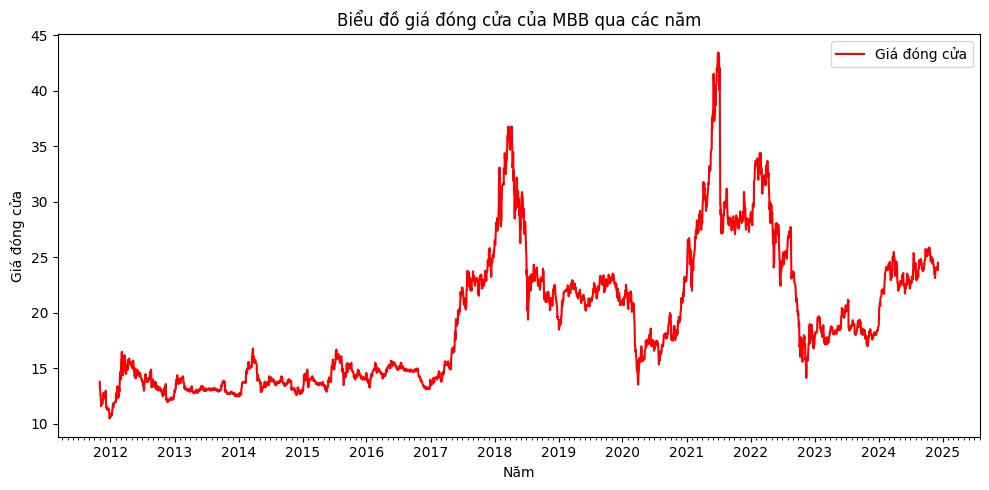

81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


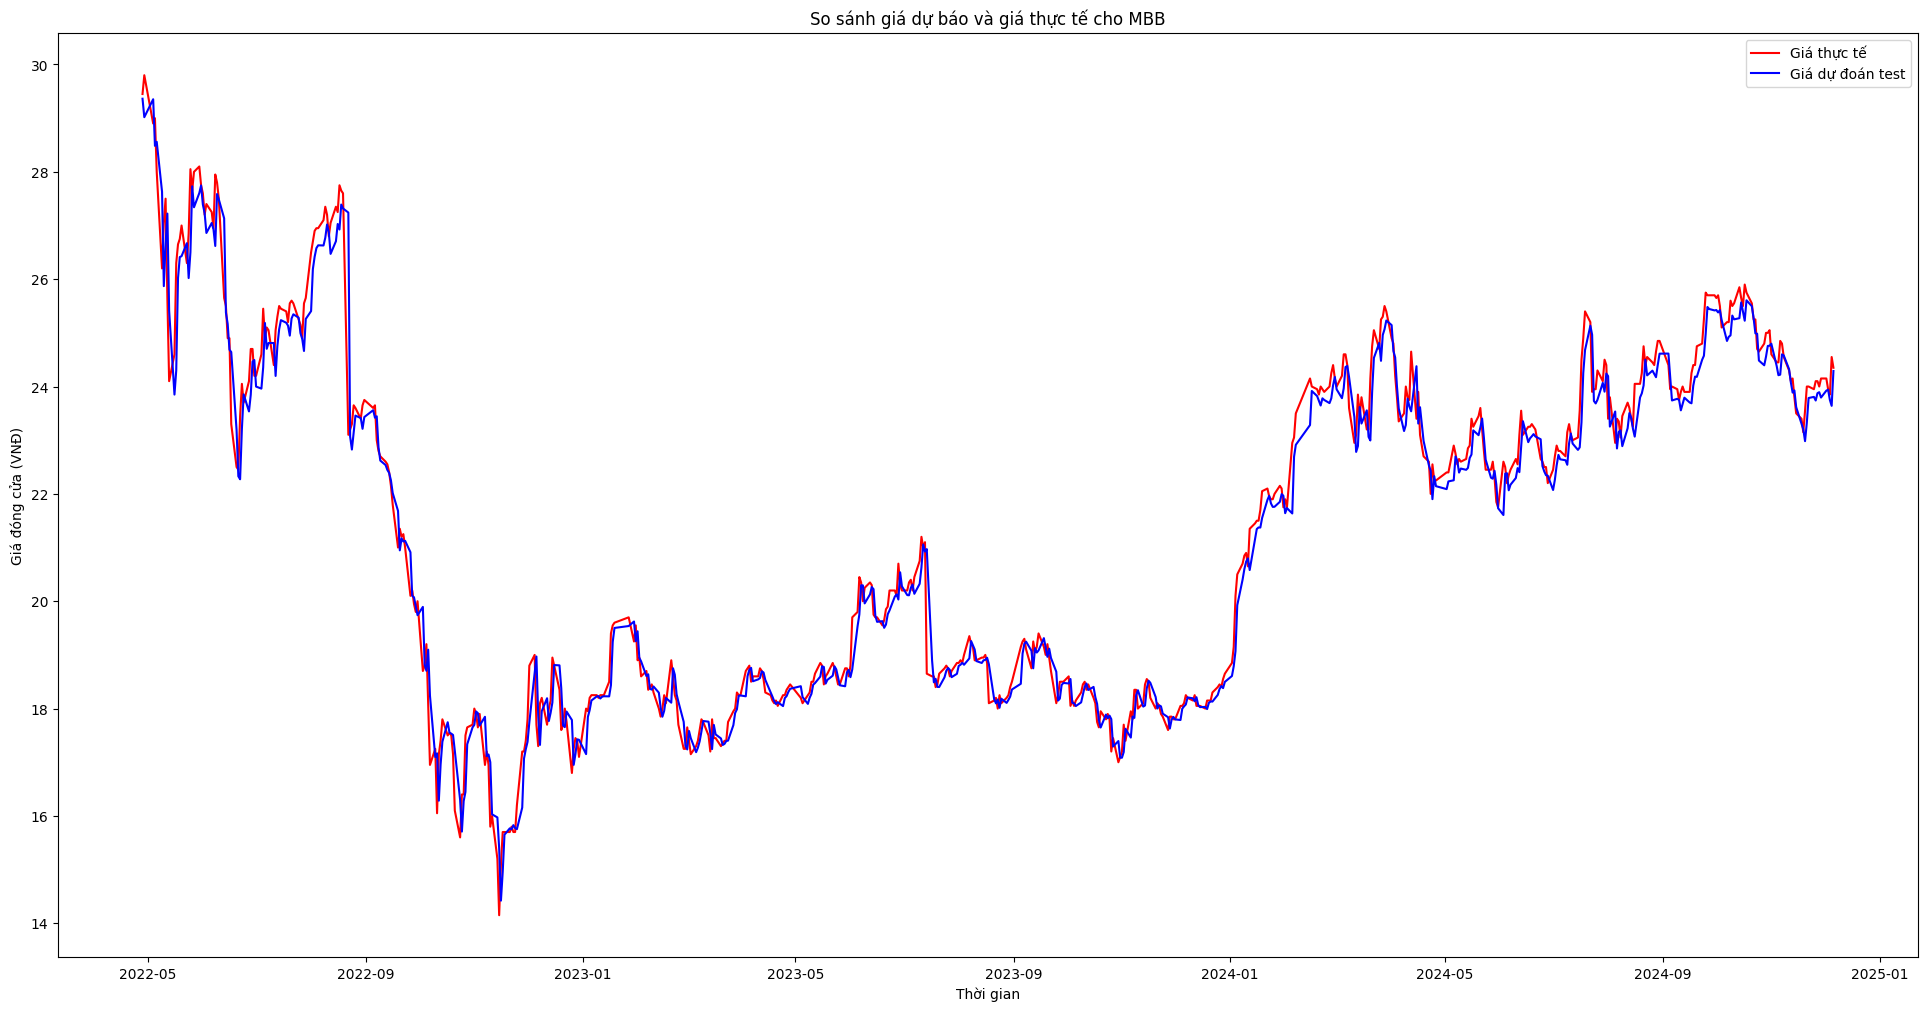

--- Kết quả cho collection: MBB ---
Độ phù hợp tập test (R2): 0.9793338843664684
Sai số tuyệt đối trung bình trên tập test (VNĐ): 0.31713484436501066
Phần trăm sai số tuyệt đối trung bình trên tập test: 0.01481596844404205
----------------------------------------------------
--- Đang xử lý collection: MSN ---


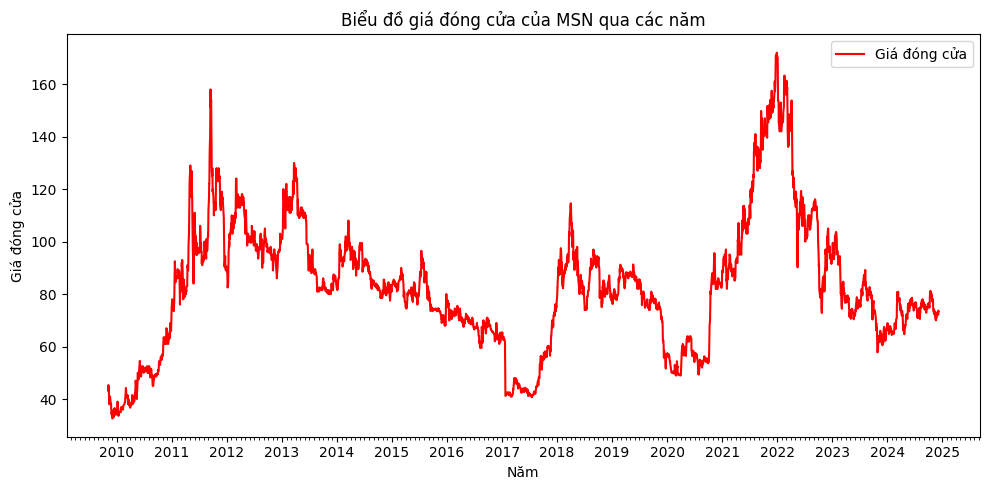

93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


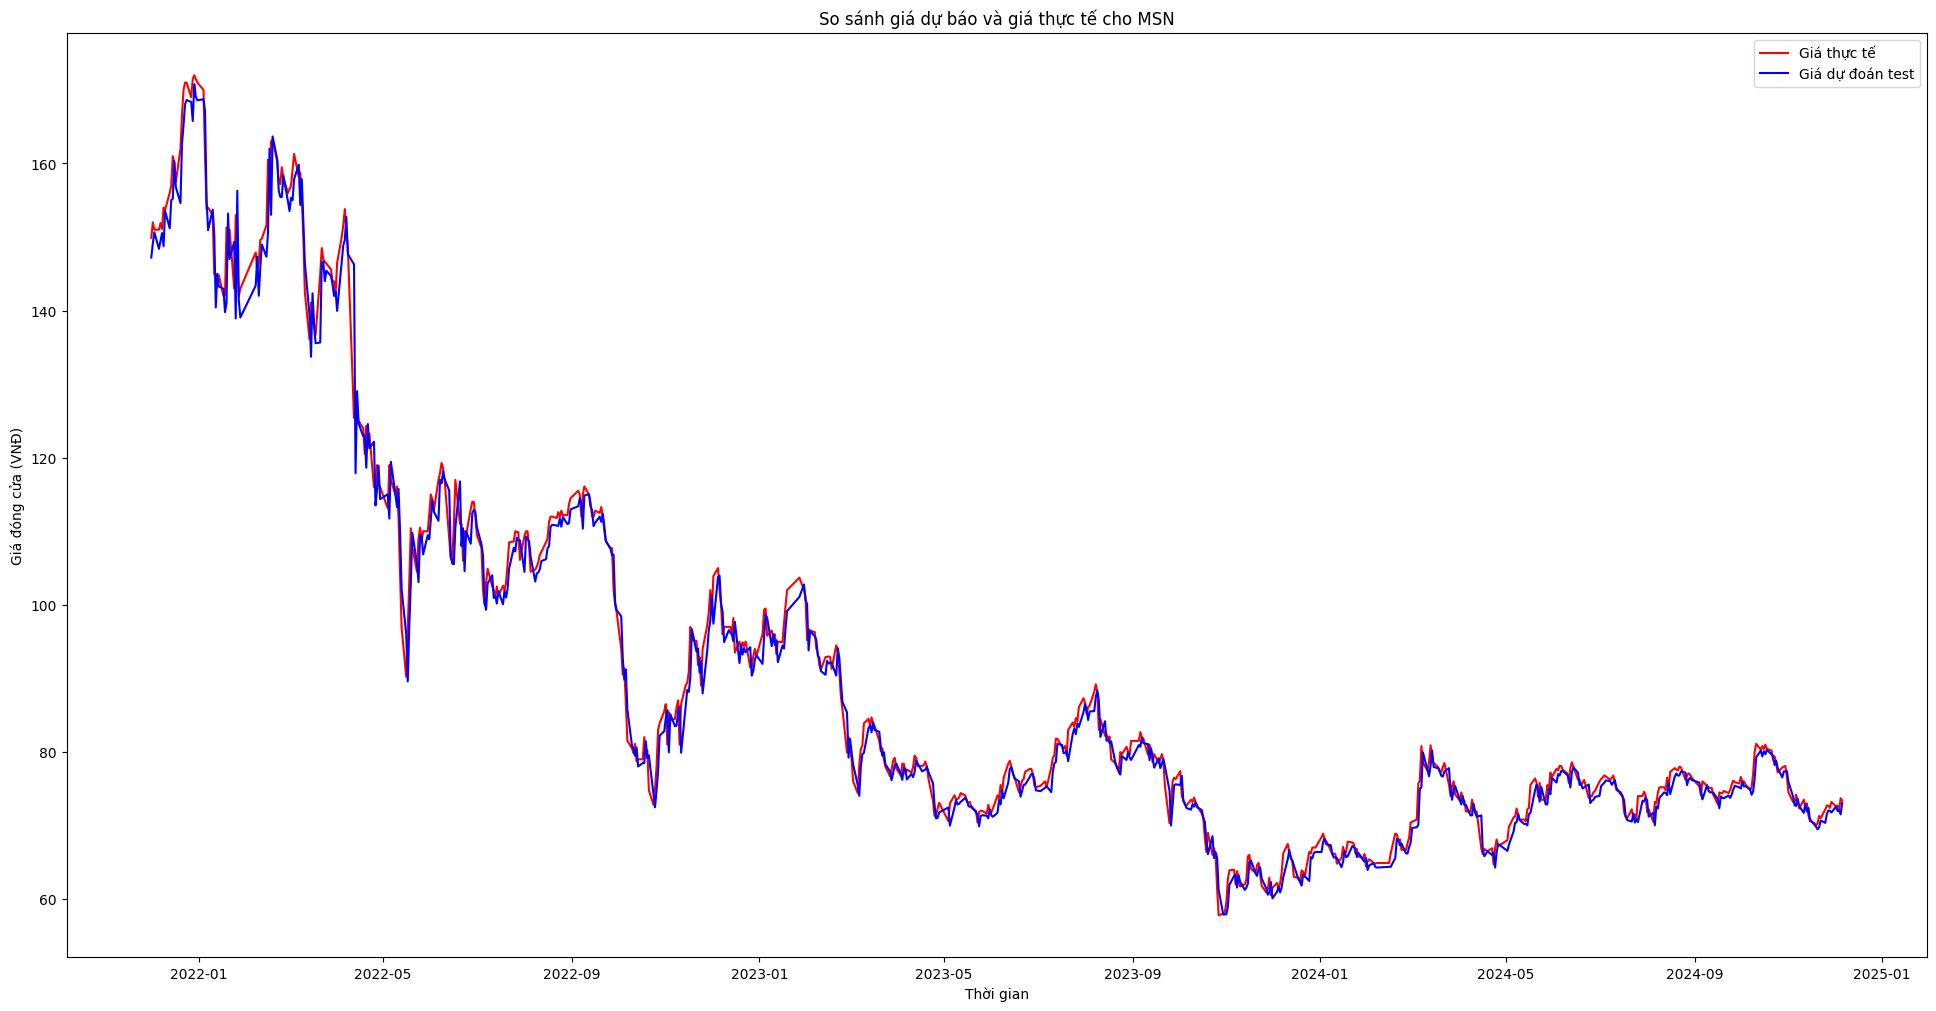

--- Kết quả cho collection: MSN ---
Độ phù hợp tập test (R2): 0.9911477954568212
Sai số tuyệt đối trung bình trên tập test (VNĐ): 1.7276570378311118
Phần trăm sai số tuyệt đối trung bình trên tập test: 0.01835291932829498
----------------------------------------------------
--- Đang xử lý collection: MWG ---


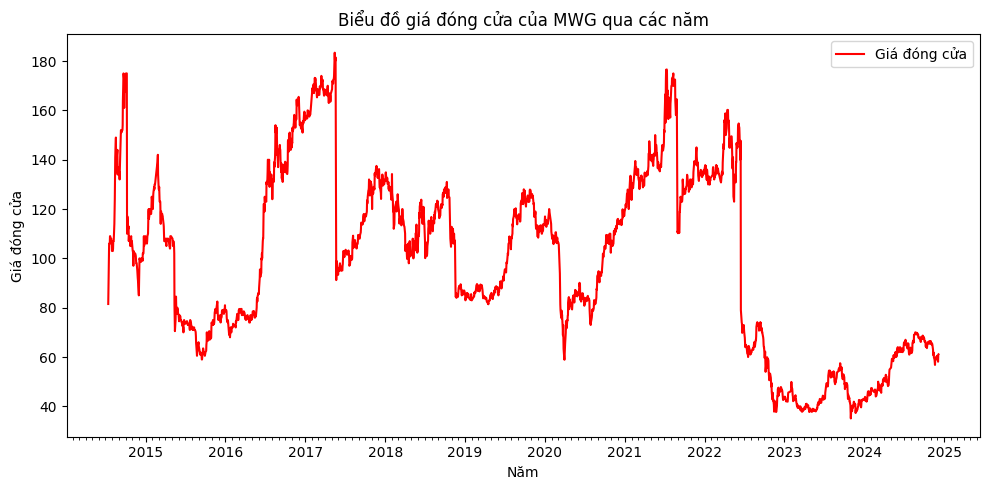

64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


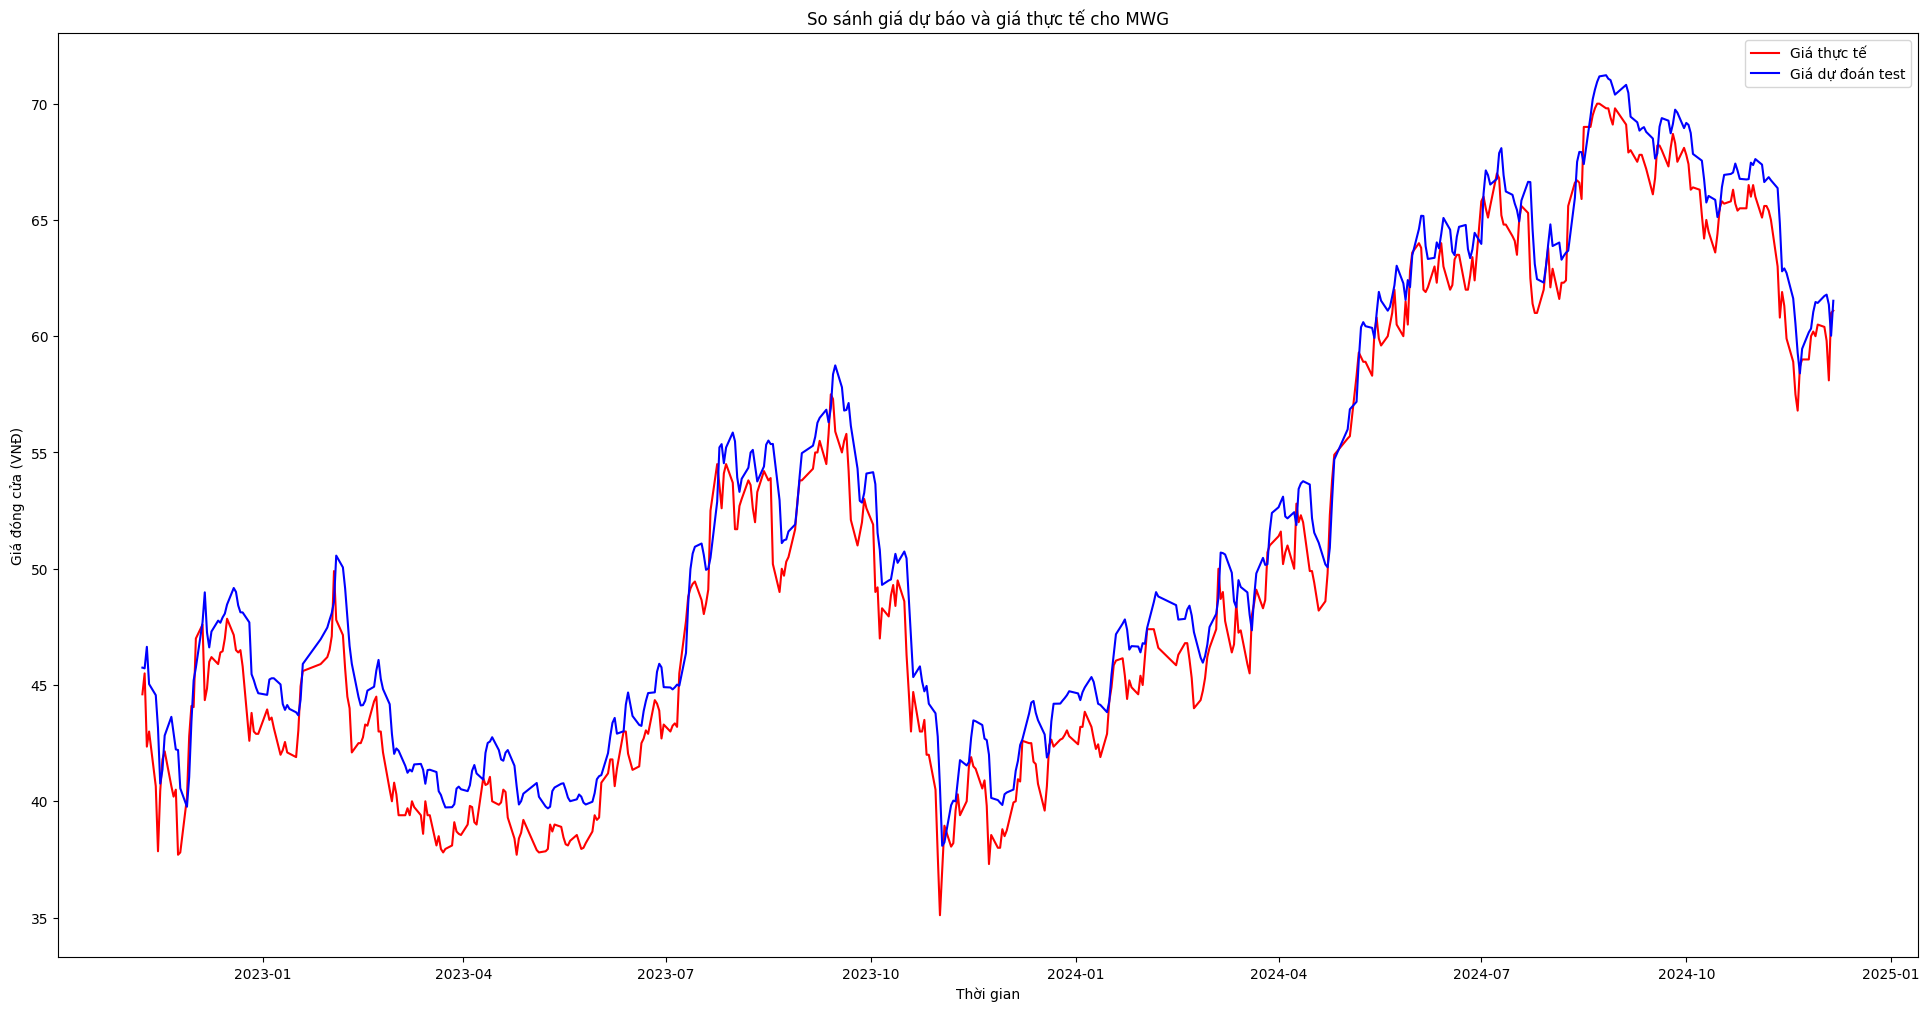

--- Kết quả cho collection: MWG ---
Độ phù hợp tập test (R2): 0.9625500419613608
Sai số tuyệt đối trung bình trên tập test (VNĐ): 1.6457706488025394
Phần trăm sai số tuyệt đối trung bình trên tập test: 0.034830590734308844
----------------------------------------------------
--- Đang xử lý collection: PLX ---


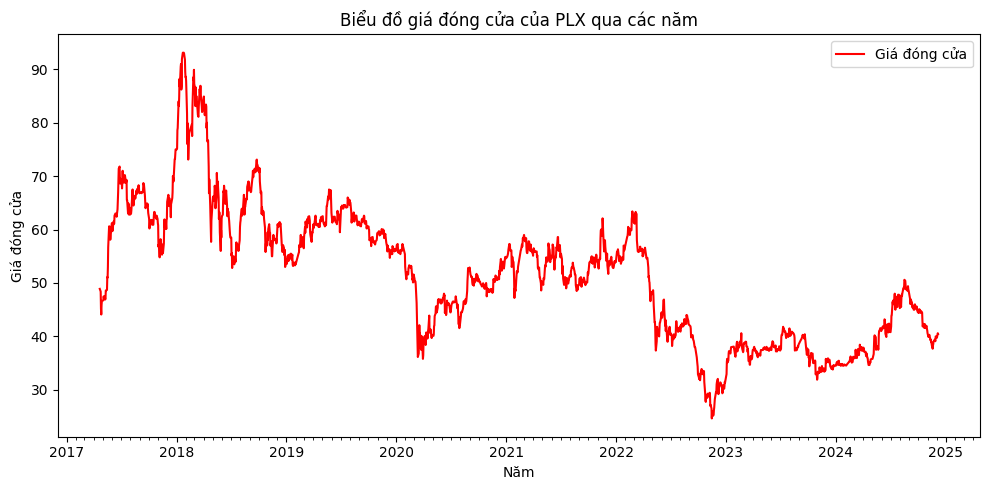

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


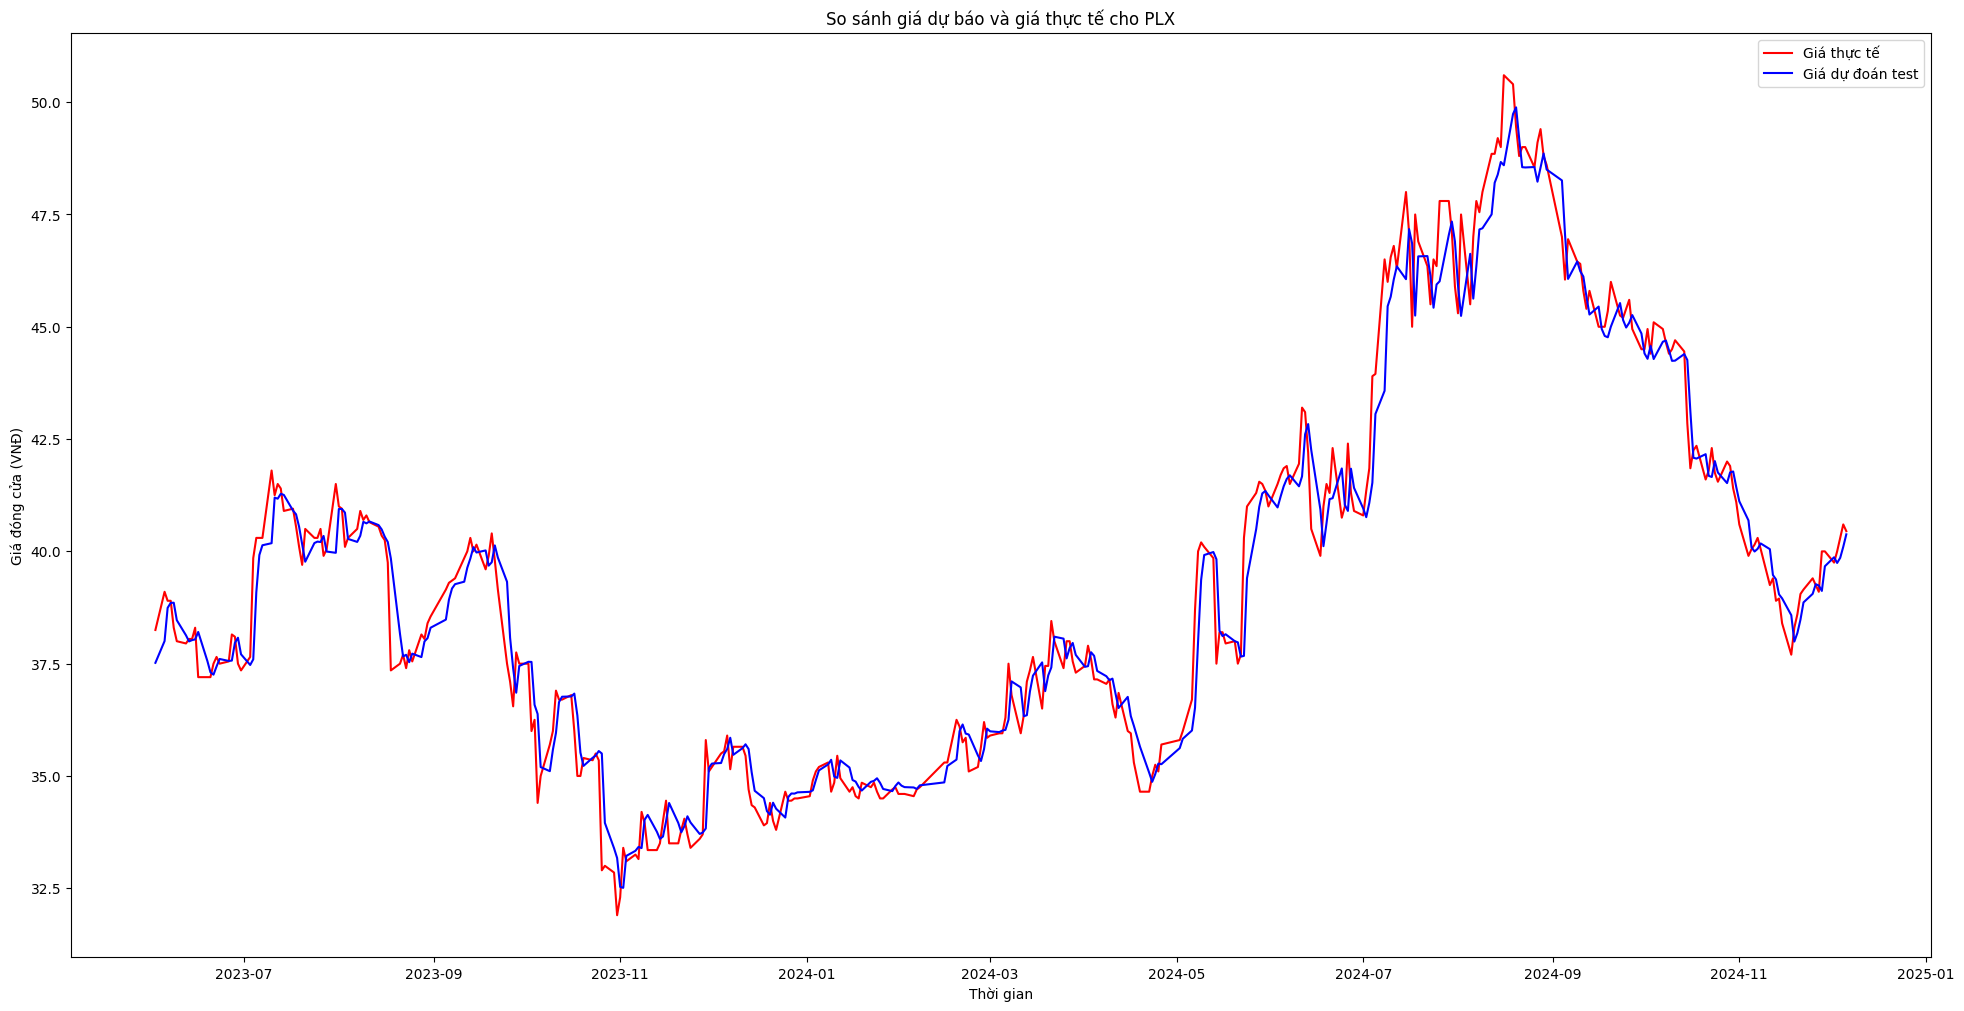

--- Kết quả cho collection: PLX ---
Độ phù hợp tập test (R2): 0.9714668500879899
Sai số tuyệt đối trung bình trên tập test (VNĐ): 0.5004306793212889
Phần trăm sai số tuyệt đối trung bình trên tập test: 0.012584580694005514
----------------------------------------------------
--- Đang xử lý collection: POW ---


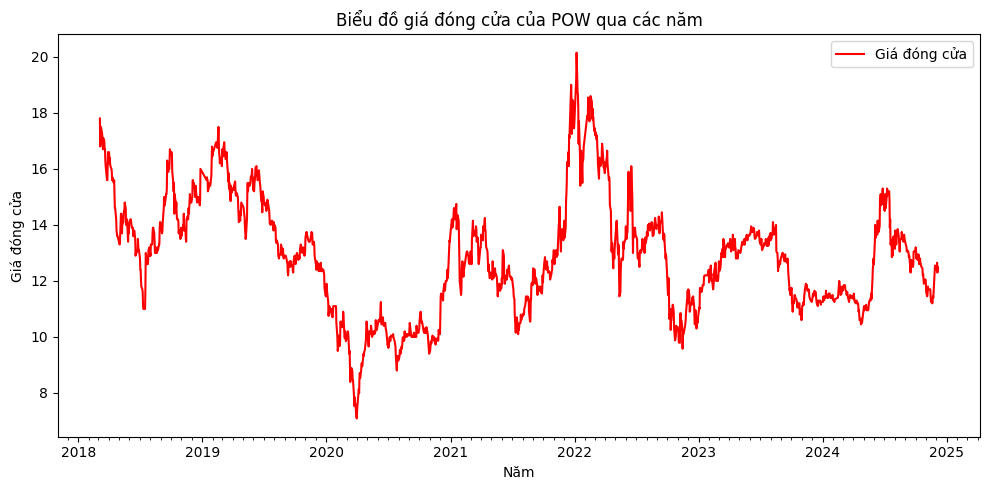

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


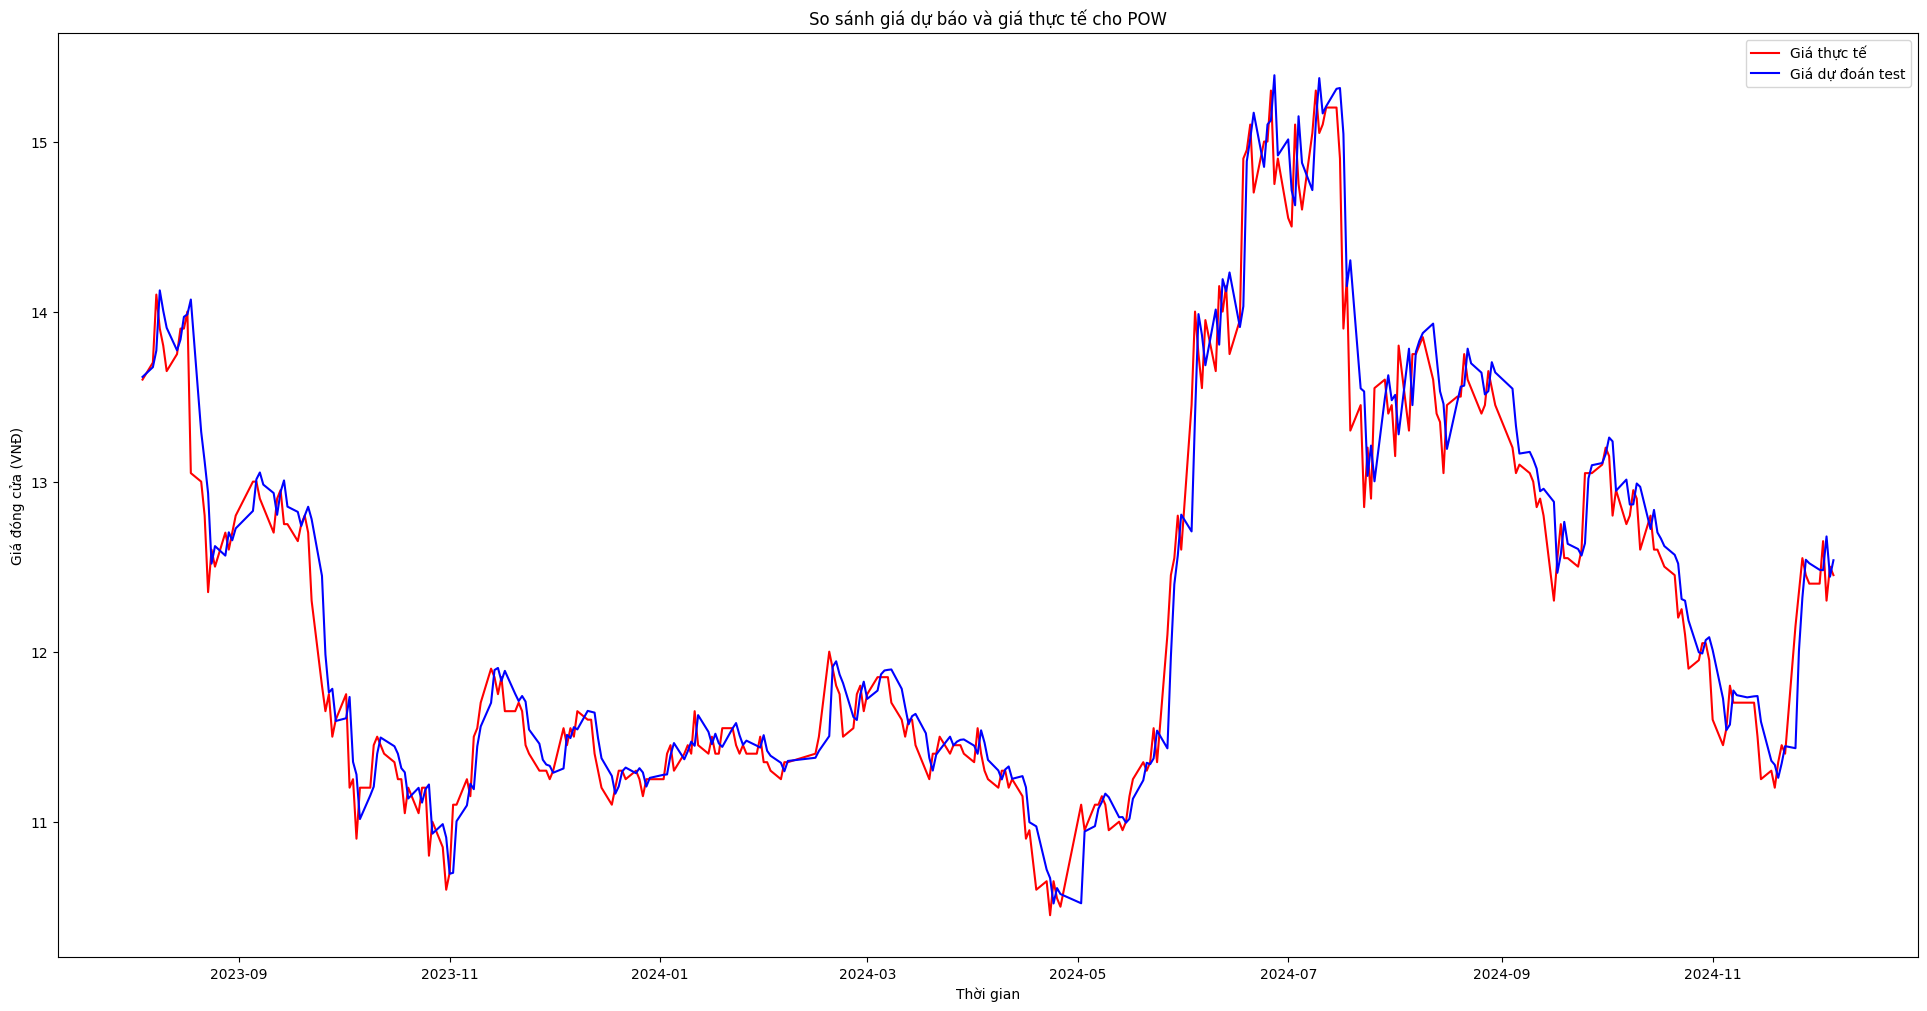

--- Kết quả cho collection: POW ---
Độ phù hợp tập test (R2): 0.9550096014196133
Sai số tuyệt đối trung bình trên tập test (VNĐ): 0.16817916507890737
Phần trăm sai số tuyệt đối trung bình trên tập test: 0.013479253053782487
----------------------------------------------------


In [68]:
import pandas as pd  # Đọc dữ liệu
import numpy as np  # Xử lý dữ liệu
import matplotlib.pyplot as plt  # Vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler  # Chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint  # Lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model  # Tải mô hình

# Các lớp để xây dựng mô hình
from keras.models import Sequential  # Đầu vào
from keras.layers import LSTM  # Học phụ thuộc
from keras.layers import Dropout  # Tránh học tủ
from keras.layers import Dense  # Đầu ra

# Kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score  # Đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error  # Đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error  # Đo % sai số tuyệt đối trung bình

from pymongo import MongoClient

# Kết nối đến MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['metadata']  # Thay 'metadata' bằng tên database

# Danh sách các collections cần xử lý
collections = ["MBB", "MSN", "MWG", "PLX", "POW"]  # Thay các tên collections cần xử lý tại đây

for collection_name in collections:
    print(f"--- Đang xử lý collection: {collection_name} ---")
    
    # Lấy dữ liệu từ MongoDB
    collection = db[collection_name]
    df = pd.DataFrame(list(collection.find({}, {"_id": 0})))
    
    if df.empty:
        print(f"Collection {collection_name} không có dữ liệu.")
        continue

    # Xử lý thời gian và sắp xếp dữ liệu
    df['Ngay'] = pd.to_datetime(df['Ngay'], format='%Y-%m-%d')
    df = df.sort_values(by='Ngay')

    # Lấy thông tin năm từ cột "Ngày"
    df['Nam'] = df['Ngay'].dt.year

    # Tạo đồ thị giá đóng cửa qua các năm
    plt.figure(figsize=(10, 5))
    plt.plot(df['Ngay'], df['GiaDongCua'], label='Giá đóng cửa', color='red')
    plt.xlabel('Năm')
    plt.ylabel('Giá đóng cửa')
    plt.title(f'Biểu đồ giá đóng cửa của {collection_name} qua các năm')
    plt.legend(loc='best')

    from matplotlib.dates import YearLocator, DateFormatter, MonthLocator
    years = YearLocator()
    yearsFmt = DateFormatter('%Y')
    months = MonthLocator()
    plt.gca().xaxis.set_major_locator(years)
    plt.gca().xaxis.set_major_formatter(yearsFmt)
    plt.gca().xaxis.set_minor_locator(months)
    plt.tight_layout()
    plt.show()

    # Chuyển đổi sang chỉ số thời gian
    df1 = pd.DataFrame(df, columns=['Ngay', 'GiaDongCua'])
    df1.index = df1['Ngay']
    df1.drop('Ngay', axis=1, inplace=True)

    # Chia tập dữ liệu
    data = df1.values
    train_data = data[:int(len(df) * 0.8)]
    test_data = data[int(len(df) * 0.8):]

    # Chuẩn hóa dữ liệu
    sc = MinMaxScaler(feature_range=(0, 1))
    sc_train = sc.fit_transform(train_data)

    # Tạo cửa sổ thời gian cho tập train
    x_train, y_train = [], []
    for i in range(50, len(train_data)):
        x_train.append(sc_train[i - 50:i, 0])  # 50 giá trị trước đó
        y_train.append(sc_train[i, 0])  # Giá trị tiếp theo
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # Tải mô hình tốt nhất
    save_model_path = f"models/{collection_name}_model.keras"
    final_model = load_model(save_model_path)

    # Dự đoán trên tập train
    y_train_predict = final_model.predict(x_train)
    y_train_predict = sc.inverse_transform(y_train_predict)
    y_train = sc.inverse_transform(y_train.reshape(-1, 1))

    # Xử lý dữ liệu test
    test = df1[len(train_data) - 50:].values
    test = test.reshape(-1, 1)
    sc_test = sc.transform(test)

    x_test = []
    for i in range(50, test.shape[0]):
        x_test.append(sc_test[i - 50:i, 0])
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    # Dự đoán trên tập test
    y_test = data[-len(x_test):]  # Giá trị thực
    y_test_predict = final_model.predict(x_test)
    y_test_predict = sc.inverse_transform(y_test_predict)  # Giá dự đoán

    # So sánh giá dự báo và giá thực tế
    num_test_predictions = len(y_test_predict)
    test_data1 = df.iloc[-num_test_predictions:].copy()
    plt.figure(figsize=(24, 12))
    if 'Ngay' in test_data1.columns:
        plt.plot(test_data1['Ngay'], test_data1['GiaDongCua'], label='Giá thực tế', color='red')
    else:
        raise KeyError("Cột 'Ngay' không tồn tại trong test_data1.")

    test_data1['Dự đoán'] = y_test_predict.flatten()
    plt.plot(test_data1['Ngay'], test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')
    plt.title(f'So sánh giá dự báo và giá thực tế cho {collection_name}')
    plt.xlabel('Thời gian')
    plt.ylabel('Giá đóng cửa (VNĐ)')
    plt.legend()
    plt.show()

    # Đánh giá mô hình
    r2 = r2_score(y_test, y_test_predict)
    mae = mean_absolute_error(y_test, y_test_predict)
    mape = mean_absolute_percentage_error(y_test, y_test_predict)
    
    print(f"--- Kết quả cho collection: {collection_name} ---")
    print('Độ phù hợp tập test (R2):', r2)
    print('Sai số tuyệt đối trung bình trên tập test (VNĐ):', mae)
    print('Phần trăm sai số tuyệt đối trung bình trên tập test:', mape)
    print("----------------------------------------------------")

--- Đang xử lý collection: SAB ---


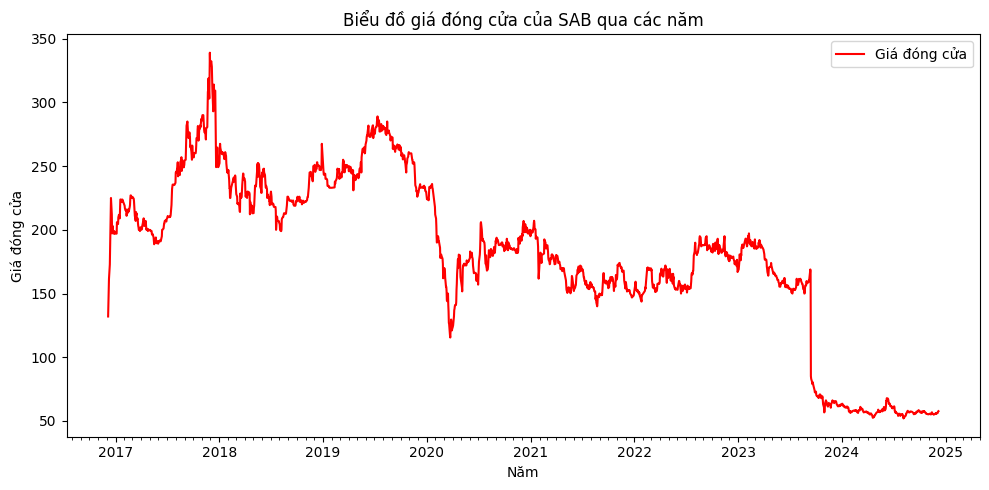

49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


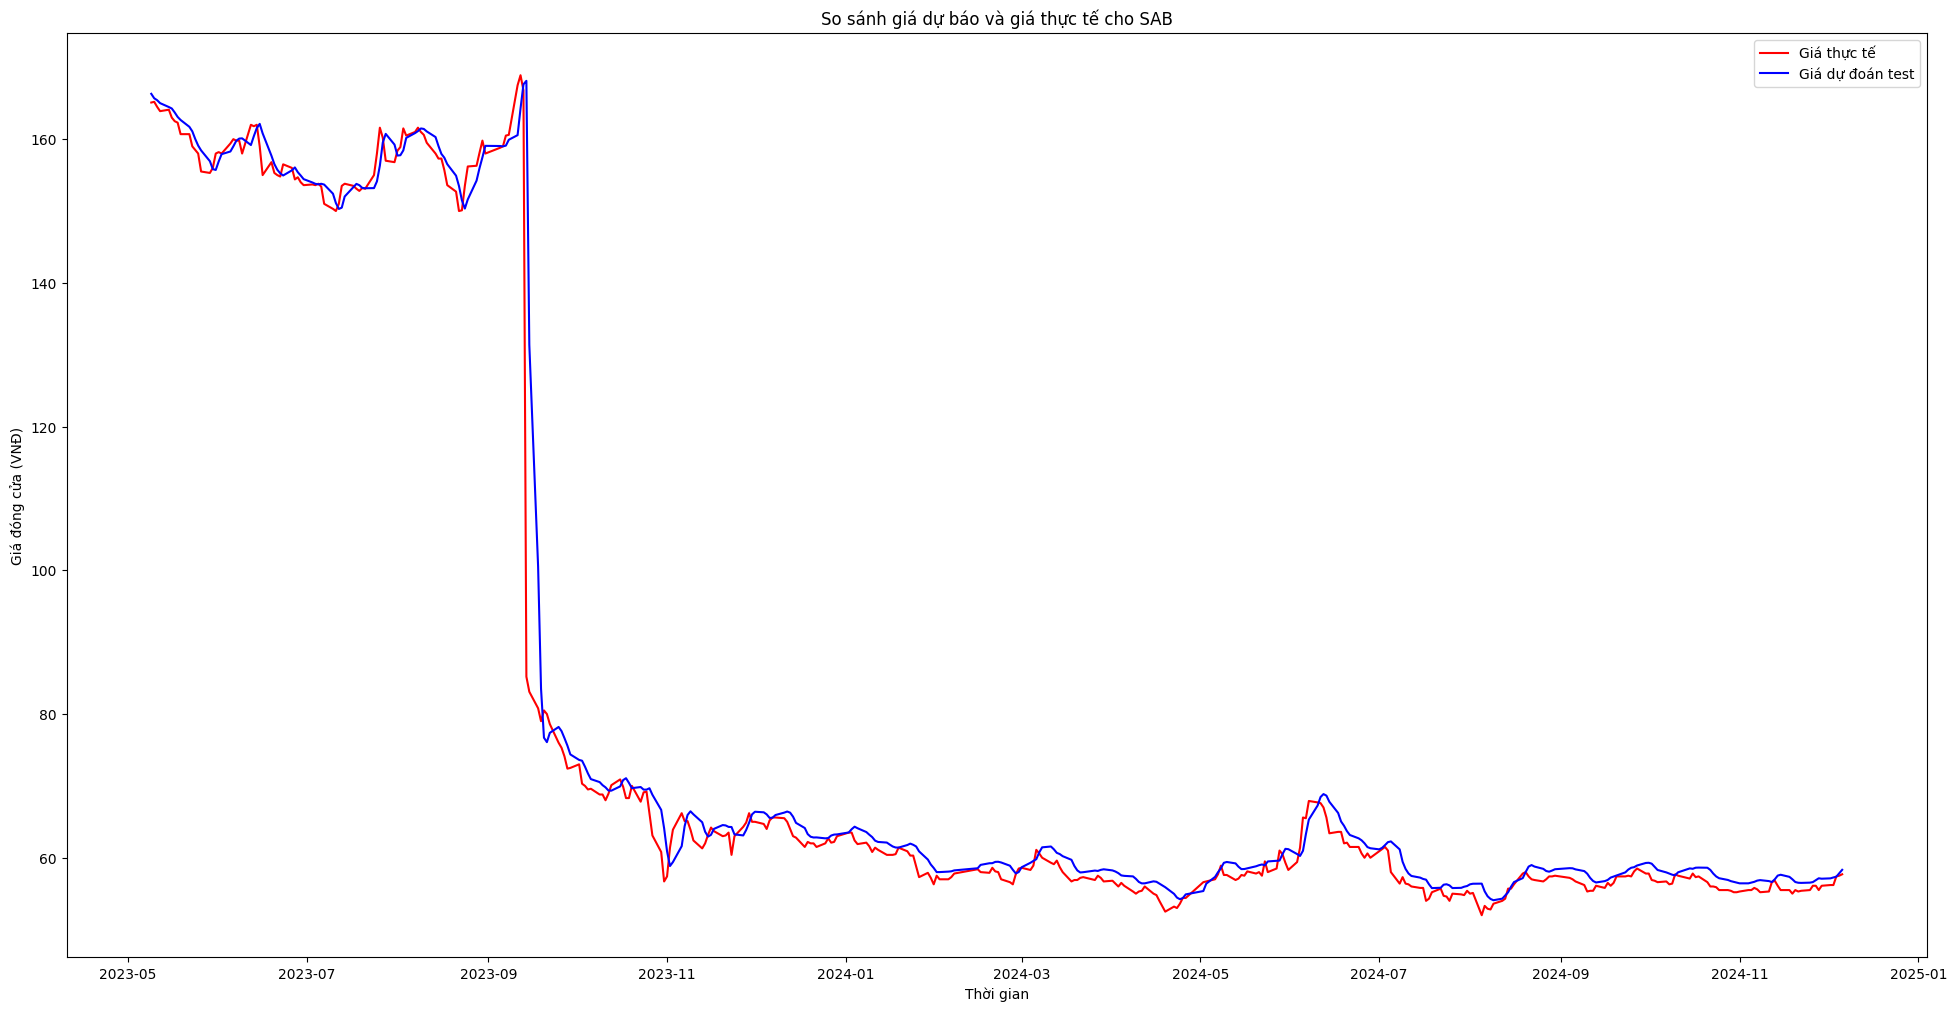

--- Kết quả cho collection: SAB ---
Độ phù hợp tập test (R2): 0.9837981335595936
Sai số tuyệt đối trung bình trên tập test (VNĐ): 1.8569708461761476
Phần trăm sai số tuyệt đối trung bình trên tập test: 0.025639684733832643
----------------------------------------------------
--- Đang xử lý collection: SHB ---


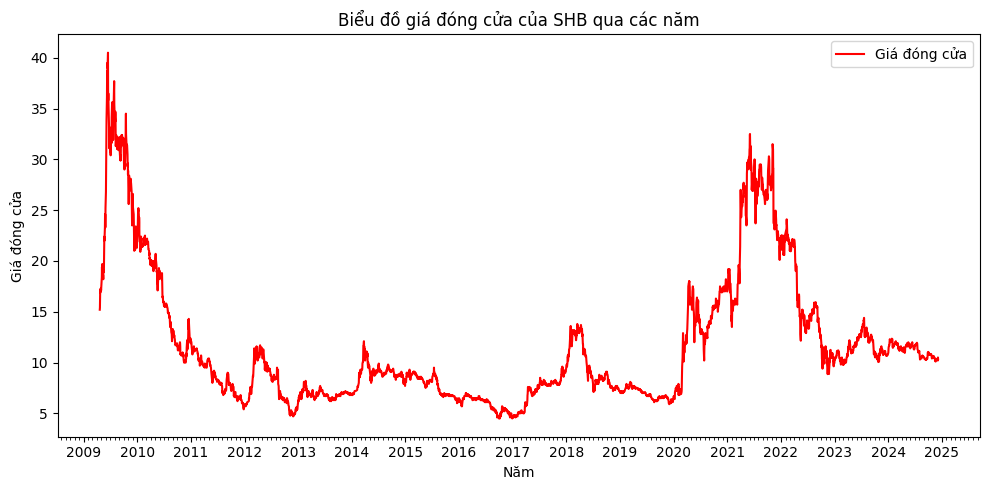

97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


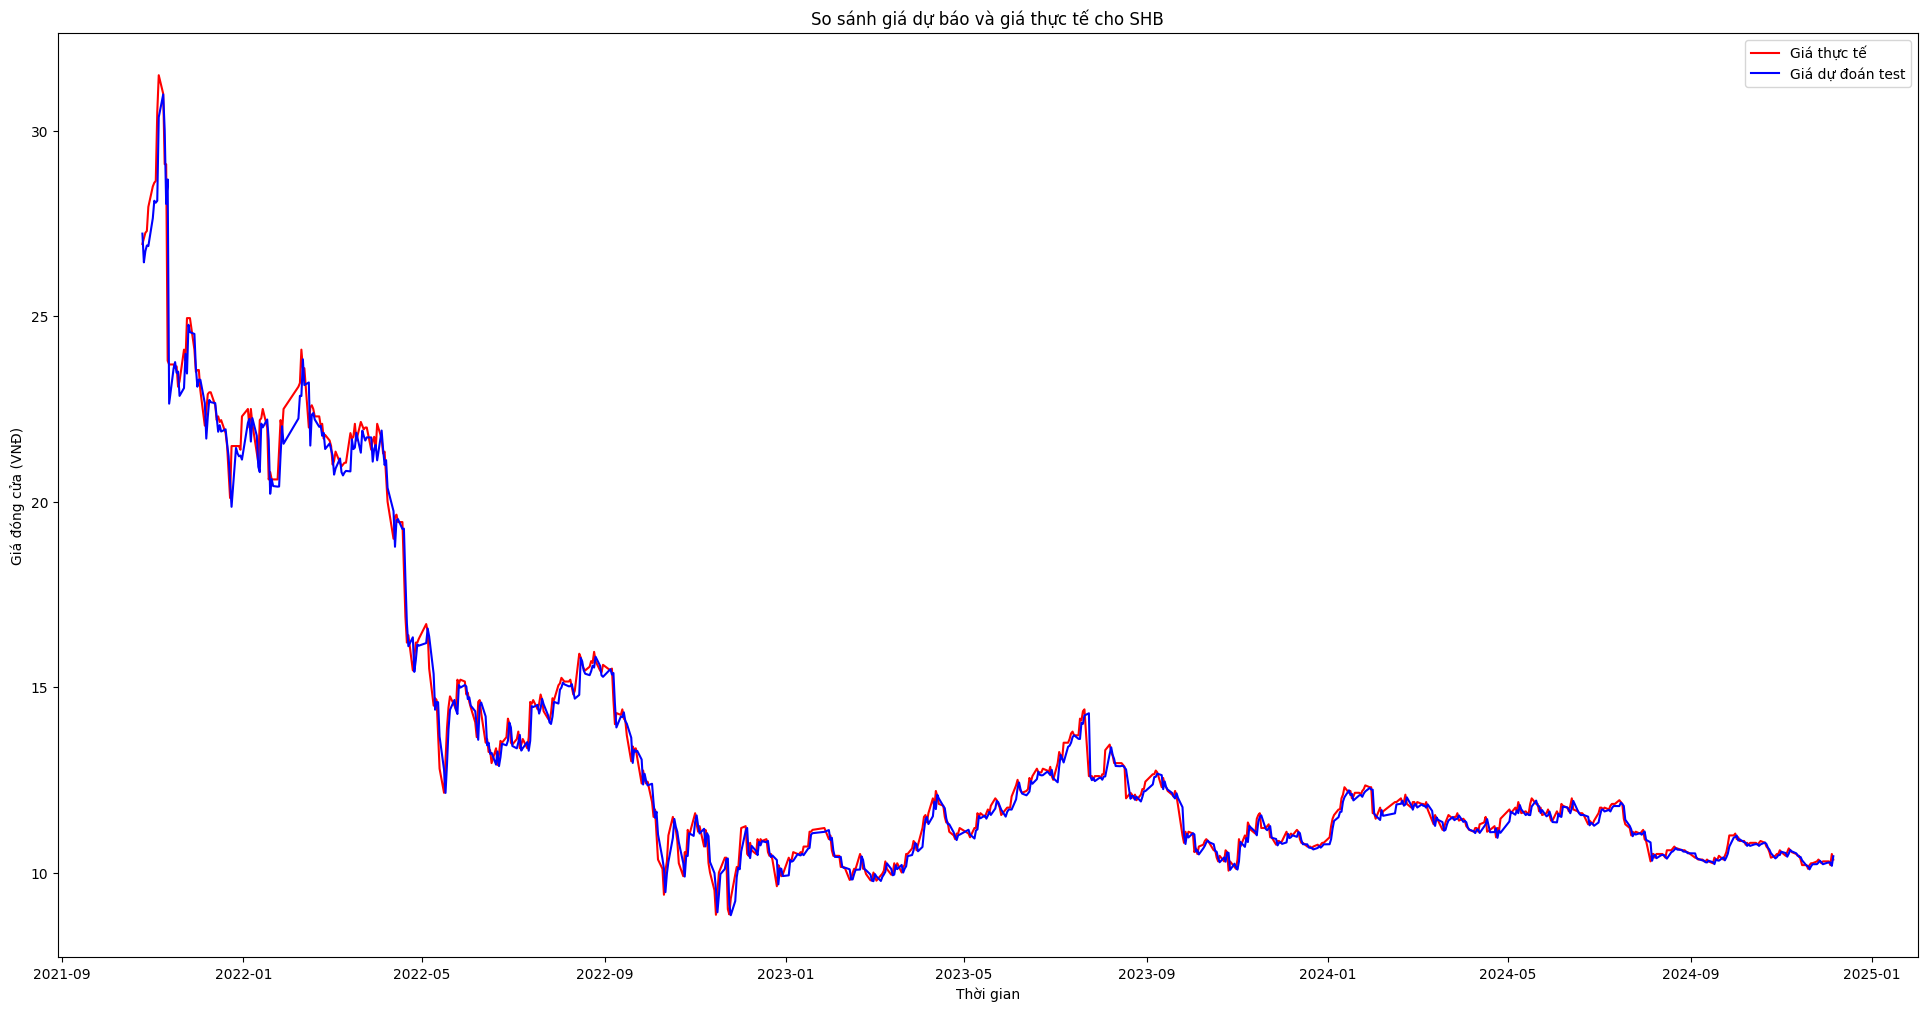

--- Kết quả cho collection: SHB ---
Độ phù hợp tập test (R2): 0.9916483112323424
Sai số tuyệt đối trung bình trên tập test (VNĐ): 0.23421003749520156
Phần trăm sai số tuyệt đối trung bình trên tập test: 0.016584893098209038
----------------------------------------------------
--- Đang xử lý collection: SSB ---


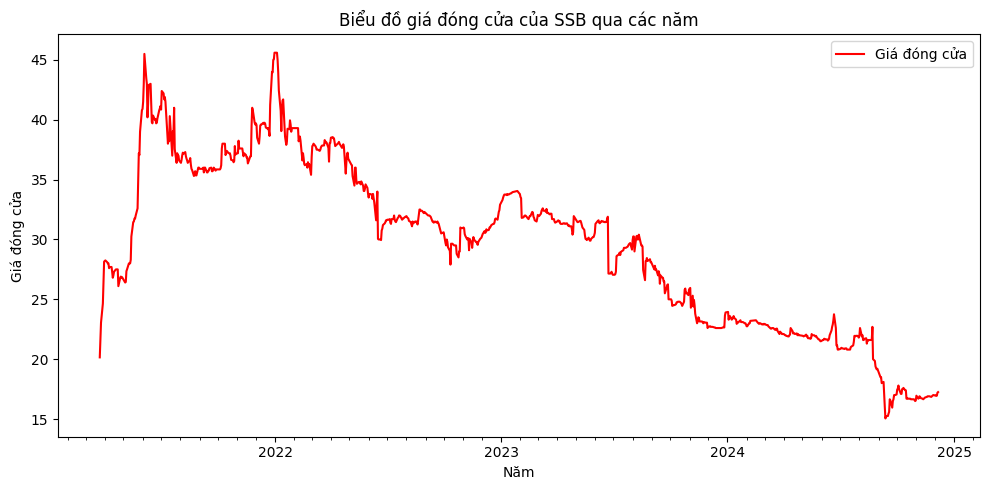

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


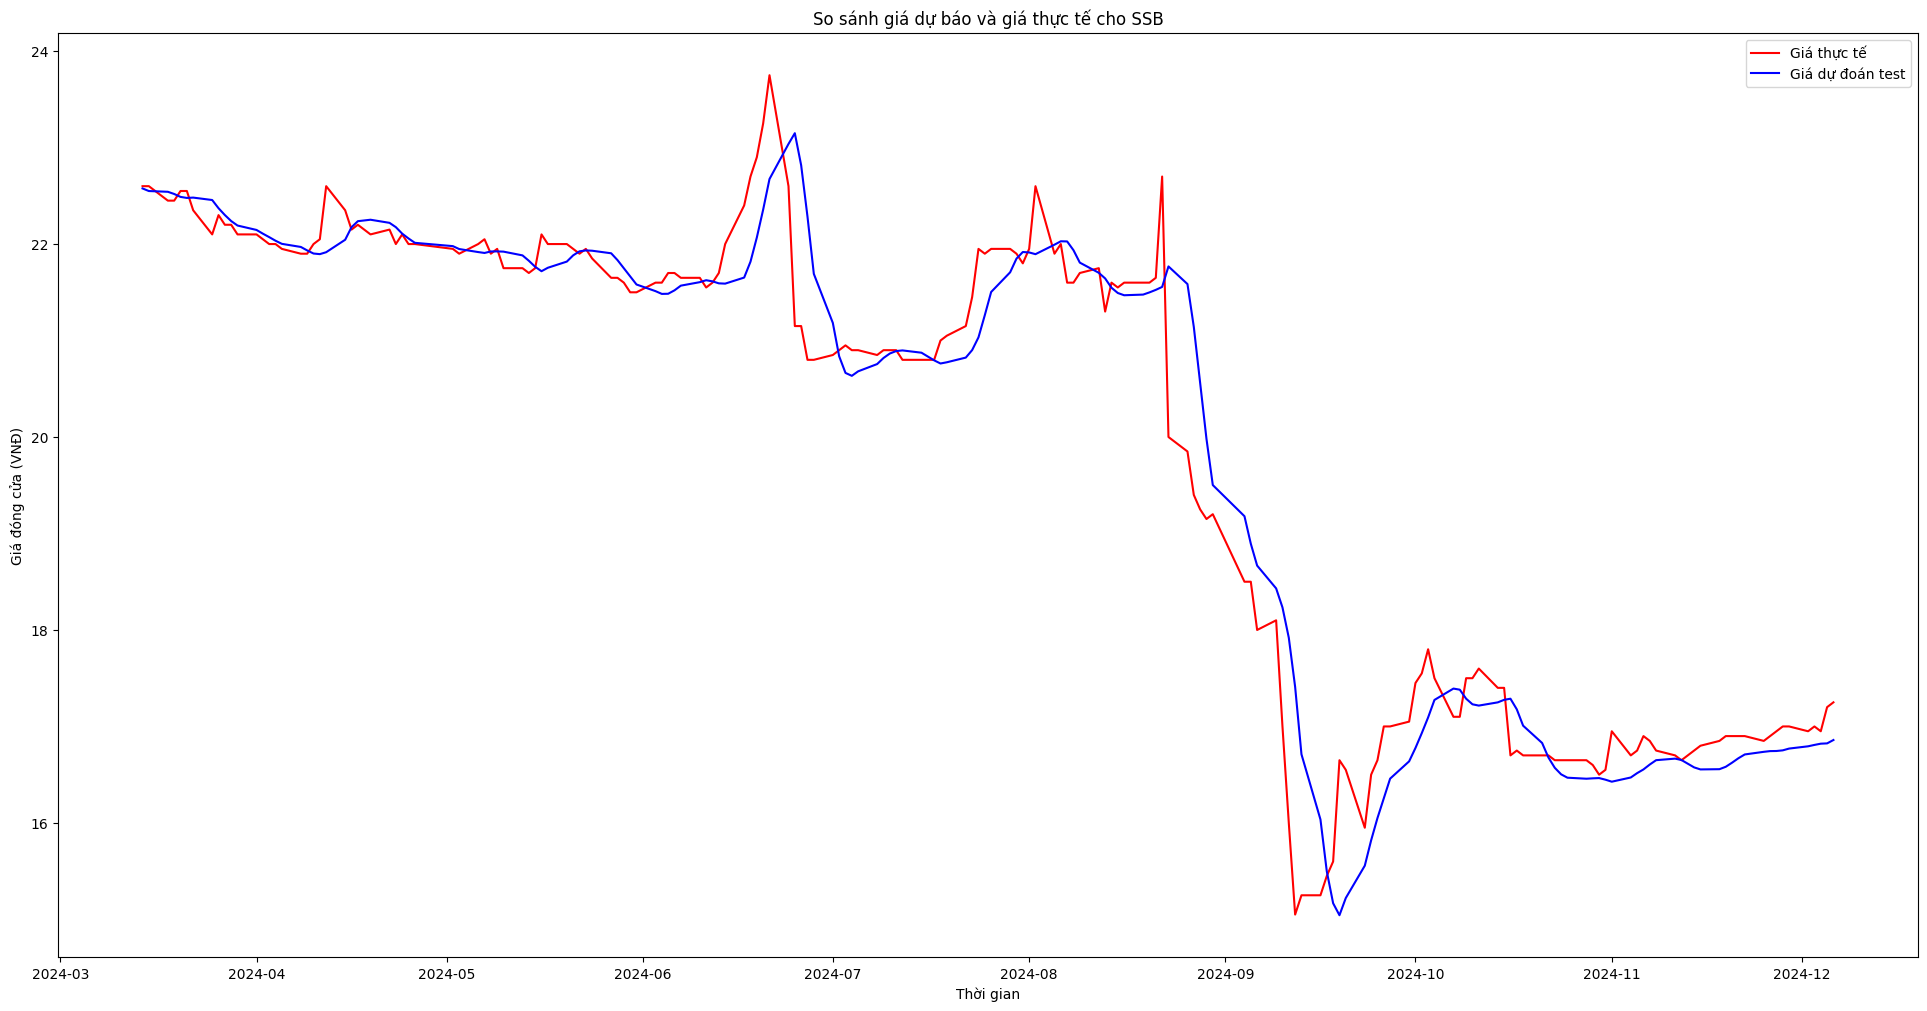

--- Kết quả cho collection: SSB ---
Độ phù hợp tập test (R2): 0.9477229319660148
Sai số tuyệt đối trung bình trên tập test (VNĐ): 0.3427058968492733
Phần trăm sai số tuyệt đối trung bình trên tập test: 0.01812720661927982
----------------------------------------------------
--- Đang xử lý collection: SSI ---


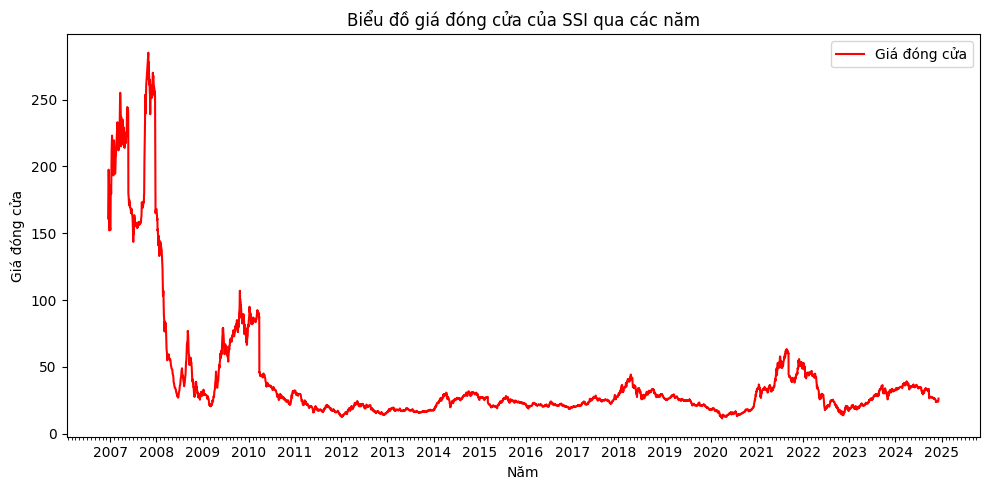

111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


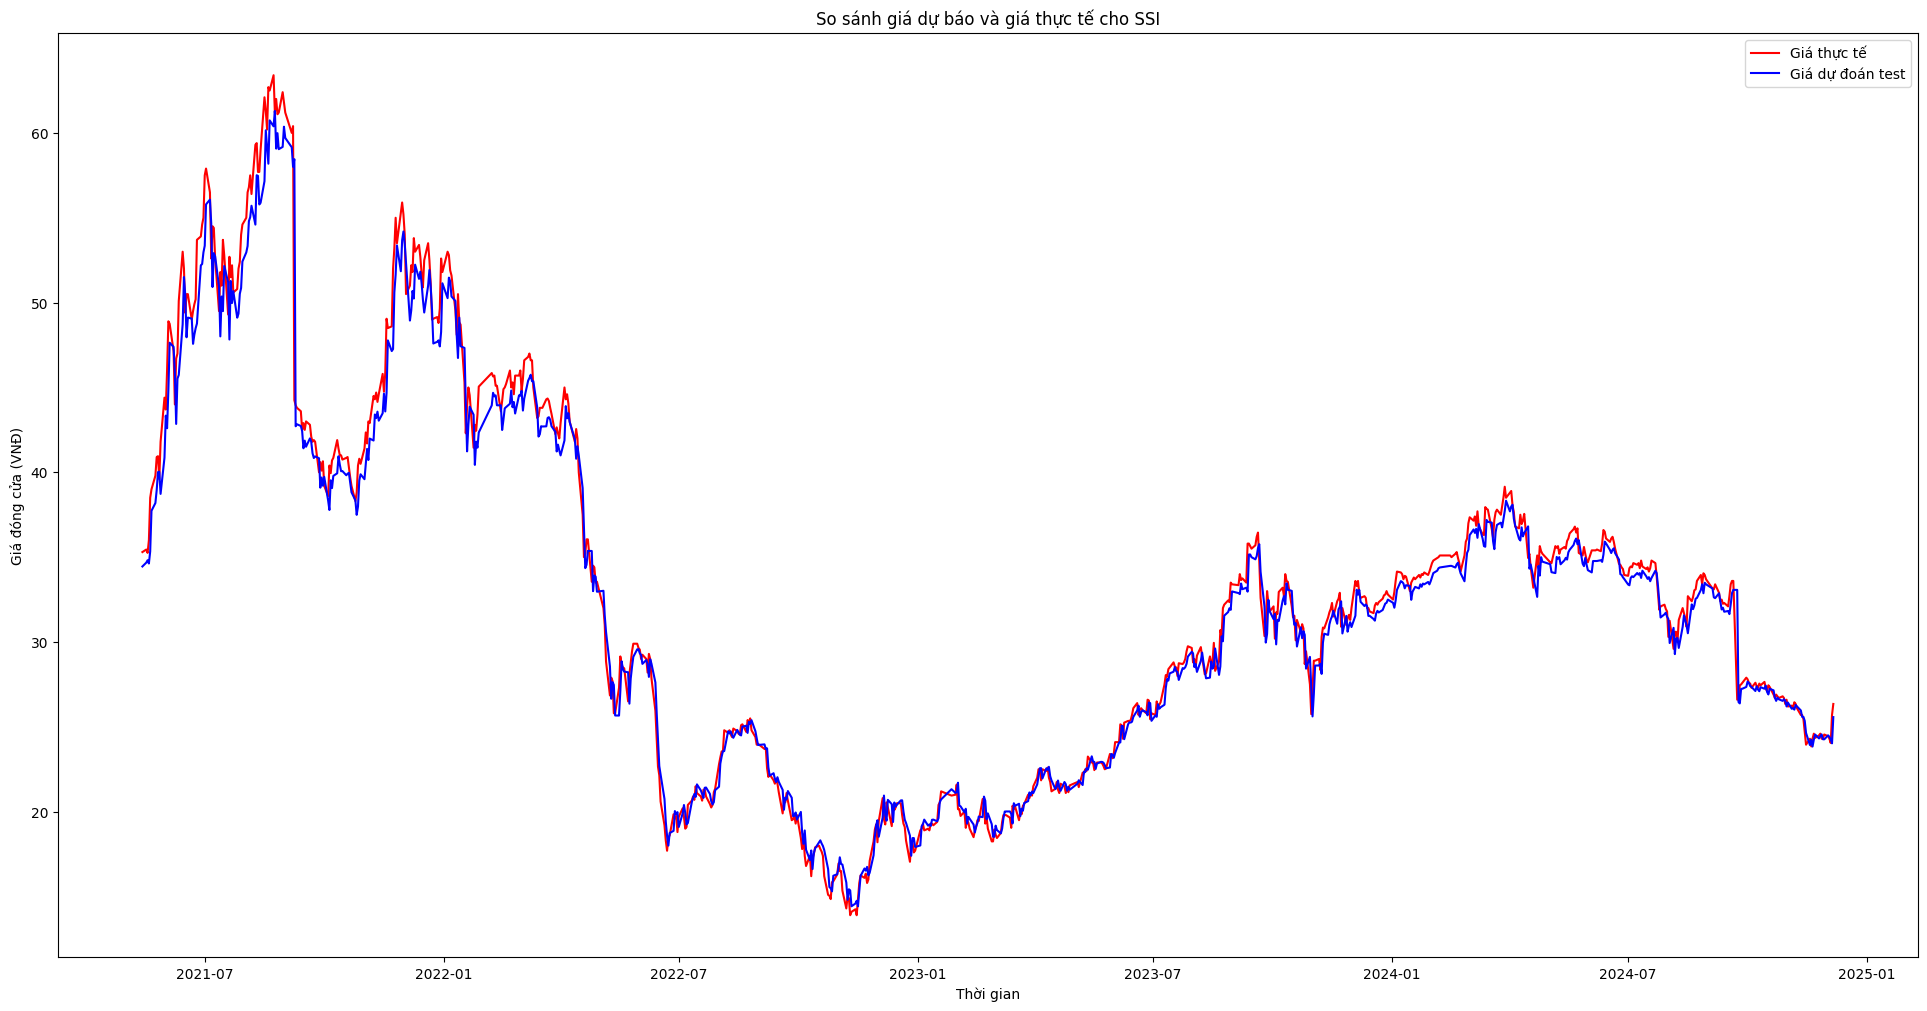

--- Kết quả cho collection: SSI ---
Độ phù hợp tập test (R2): 0.9859242306049133
Sai số tuyệt đối trung bình trên tập test (VNĐ): 0.8782763098604851
Phần trăm sai số tuyệt đối trung bình trên tập test: 0.025815692782551216
----------------------------------------------------
--- Đang xử lý collection: STB ---


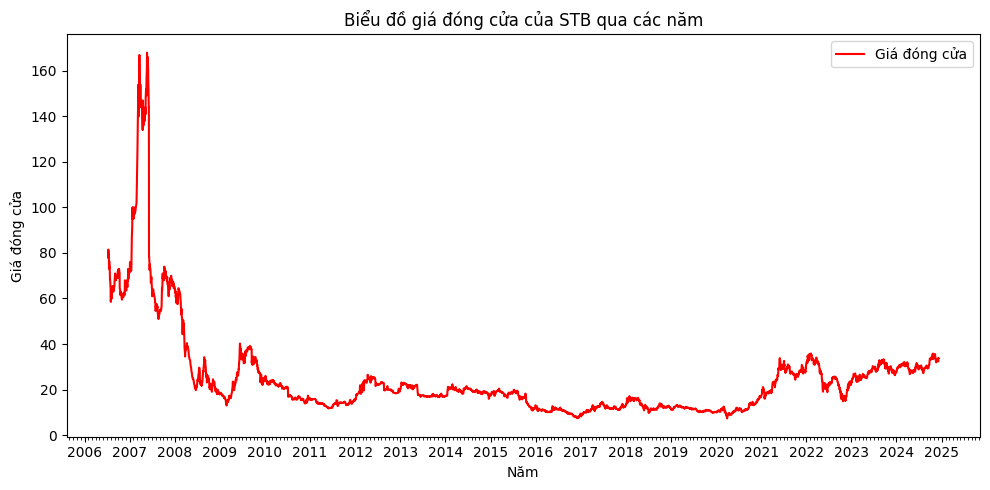

114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


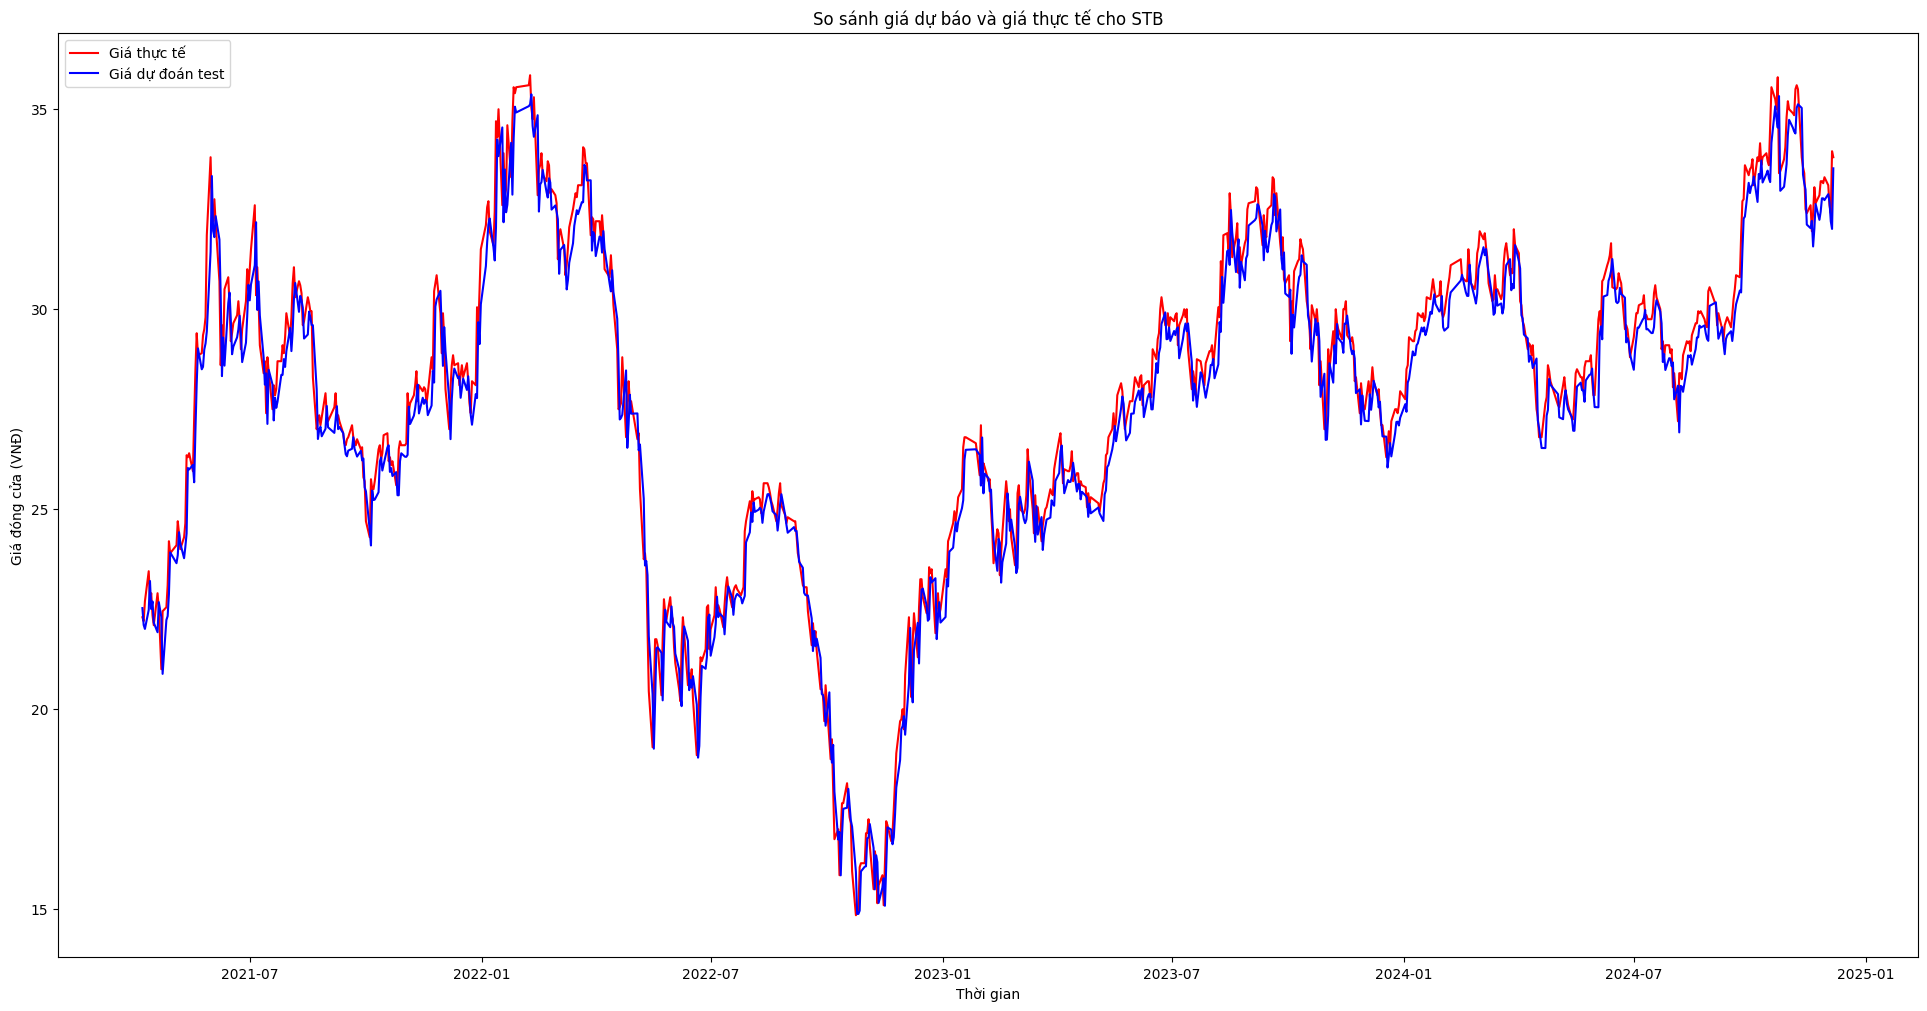

--- Kết quả cho collection: STB ---
Độ phù hợp tập test (R2): 0.9704189568475665
Sai số tuyệt đối trung bình trên tập test (VNĐ): 0.566124697738166
Phần trăm sai số tuyệt đối trung bình trên tập test: 0.020858041095464484
----------------------------------------------------


In [69]:
import pandas as pd  # Đọc dữ liệu
import numpy as np  # Xử lý dữ liệu
import matplotlib.pyplot as plt  # Vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler  # Chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint  # Lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model  # Tải mô hình

# Các lớp để xây dựng mô hình
from keras.models import Sequential  # Đầu vào
from keras.layers import LSTM  # Học phụ thuộc
from keras.layers import Dropout  # Tránh học tủ
from keras.layers import Dense  # Đầu ra

# Kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score  # Đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error  # Đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error  # Đo % sai số tuyệt đối trung bình

from pymongo import MongoClient

# Kết nối đến MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['metadata']  # Thay 'metadata' bằng tên database

# Danh sách các collections cần xử lý
collections = ["SAB", "SHB", "SSB", "SSI", "STB"]  # Thay các tên collections cần xử lý tại đây

for collection_name in collections:
    print(f"--- Đang xử lý collection: {collection_name} ---")
    
    # Lấy dữ liệu từ MongoDB
    collection = db[collection_name]
    df = pd.DataFrame(list(collection.find({}, {"_id": 0})))
    
    if df.empty:
        print(f"Collection {collection_name} không có dữ liệu.")
        continue

    # Xử lý thời gian và sắp xếp dữ liệu
    df['Ngay'] = pd.to_datetime(df['Ngay'], format='%Y-%m-%d')
    df = df.sort_values(by='Ngay')

    # Lấy thông tin năm từ cột "Ngày"
    df['Nam'] = df['Ngay'].dt.year

    # Tạo đồ thị giá đóng cửa qua các năm
    plt.figure(figsize=(10, 5))
    plt.plot(df['Ngay'], df['GiaDongCua'], label='Giá đóng cửa', color='red')
    plt.xlabel('Năm')
    plt.ylabel('Giá đóng cửa')
    plt.title(f'Biểu đồ giá đóng cửa của {collection_name} qua các năm')
    plt.legend(loc='best')

    from matplotlib.dates import YearLocator, DateFormatter, MonthLocator
    years = YearLocator()
    yearsFmt = DateFormatter('%Y')
    months = MonthLocator()
    plt.gca().xaxis.set_major_locator(years)
    plt.gca().xaxis.set_major_formatter(yearsFmt)
    plt.gca().xaxis.set_minor_locator(months)
    plt.tight_layout()
    plt.show()

    # Chuyển đổi sang chỉ số thời gian
    df1 = pd.DataFrame(df, columns=['Ngay', 'GiaDongCua'])
    df1.index = df1['Ngay']
    df1.drop('Ngay', axis=1, inplace=True)

    # Chia tập dữ liệu
    data = df1.values
    train_data = data[:int(len(df) * 0.8)]
    test_data = data[int(len(df) * 0.8):]

    # Chuẩn hóa dữ liệu
    sc = MinMaxScaler(feature_range=(0, 1))
    sc_train = sc.fit_transform(train_data)

    # Tạo cửa sổ thời gian cho tập train
    x_train, y_train = [], []
    for i in range(50, len(train_data)):
        x_train.append(sc_train[i - 50:i, 0])  # 50 giá trị trước đó
        y_train.append(sc_train[i, 0])  # Giá trị tiếp theo
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # Tải mô hình tốt nhất
    save_model_path = f"models/{collection_name}_model.keras"
    final_model = load_model(save_model_path)

    # Dự đoán trên tập train
    y_train_predict = final_model.predict(x_train)
    y_train_predict = sc.inverse_transform(y_train_predict)
    y_train = sc.inverse_transform(y_train.reshape(-1, 1))

    # Xử lý dữ liệu test
    test = df1[len(train_data) - 50:].values
    test = test.reshape(-1, 1)
    sc_test = sc.transform(test)

    x_test = []
    for i in range(50, test.shape[0]):
        x_test.append(sc_test[i - 50:i, 0])
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    # Dự đoán trên tập test
    y_test = data[-len(x_test):]  # Giá trị thực
    y_test_predict = final_model.predict(x_test)
    y_test_predict = sc.inverse_transform(y_test_predict)  # Giá dự đoán

    # So sánh giá dự báo và giá thực tế
    num_test_predictions = len(y_test_predict)
    test_data1 = df.iloc[-num_test_predictions:].copy()
    plt.figure(figsize=(24, 12))
    if 'Ngay' in test_data1.columns:
        plt.plot(test_data1['Ngay'], test_data1['GiaDongCua'], label='Giá thực tế', color='red')
    else:
        raise KeyError("Cột 'Ngay' không tồn tại trong test_data1.")

    test_data1['Dự đoán'] = y_test_predict.flatten()
    plt.plot(test_data1['Ngay'], test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')
    plt.title(f'So sánh giá dự báo và giá thực tế cho {collection_name}')
    plt.xlabel('Thời gian')
    plt.ylabel('Giá đóng cửa (VNĐ)')
    plt.legend()
    plt.show()

    # Đánh giá mô hình
    r2 = r2_score(y_test, y_test_predict)
    mae = mean_absolute_error(y_test, y_test_predict)
    mape = mean_absolute_percentage_error(y_test, y_test_predict)
    
    print(f"--- Kết quả cho collection: {collection_name} ---")
    print('Độ phù hợp tập test (R2):', r2)
    print('Sai số tuyệt đối trung bình trên tập test (VNĐ):', mae)
    print('Phần trăm sai số tuyệt đối trung bình trên tập test:', mape)
    print("----------------------------------------------------")

--- Đang xử lý collection: TCB ---


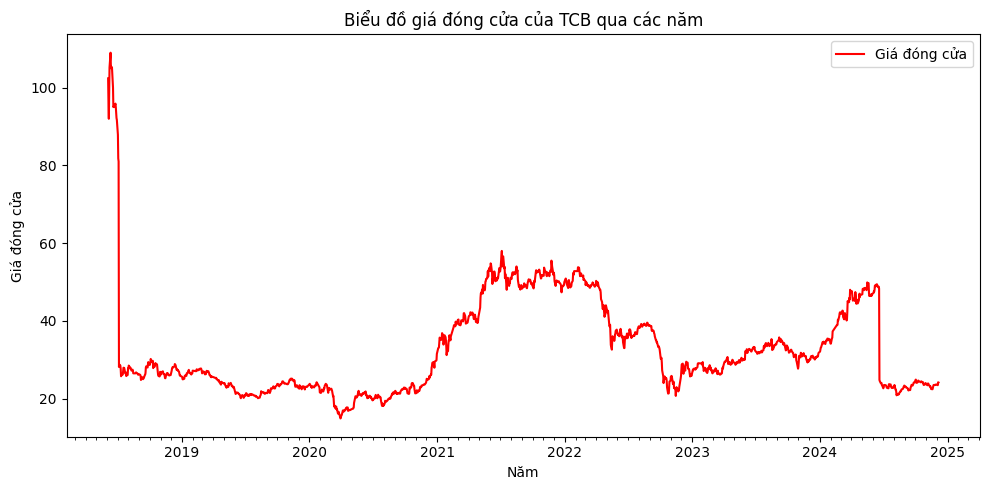

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


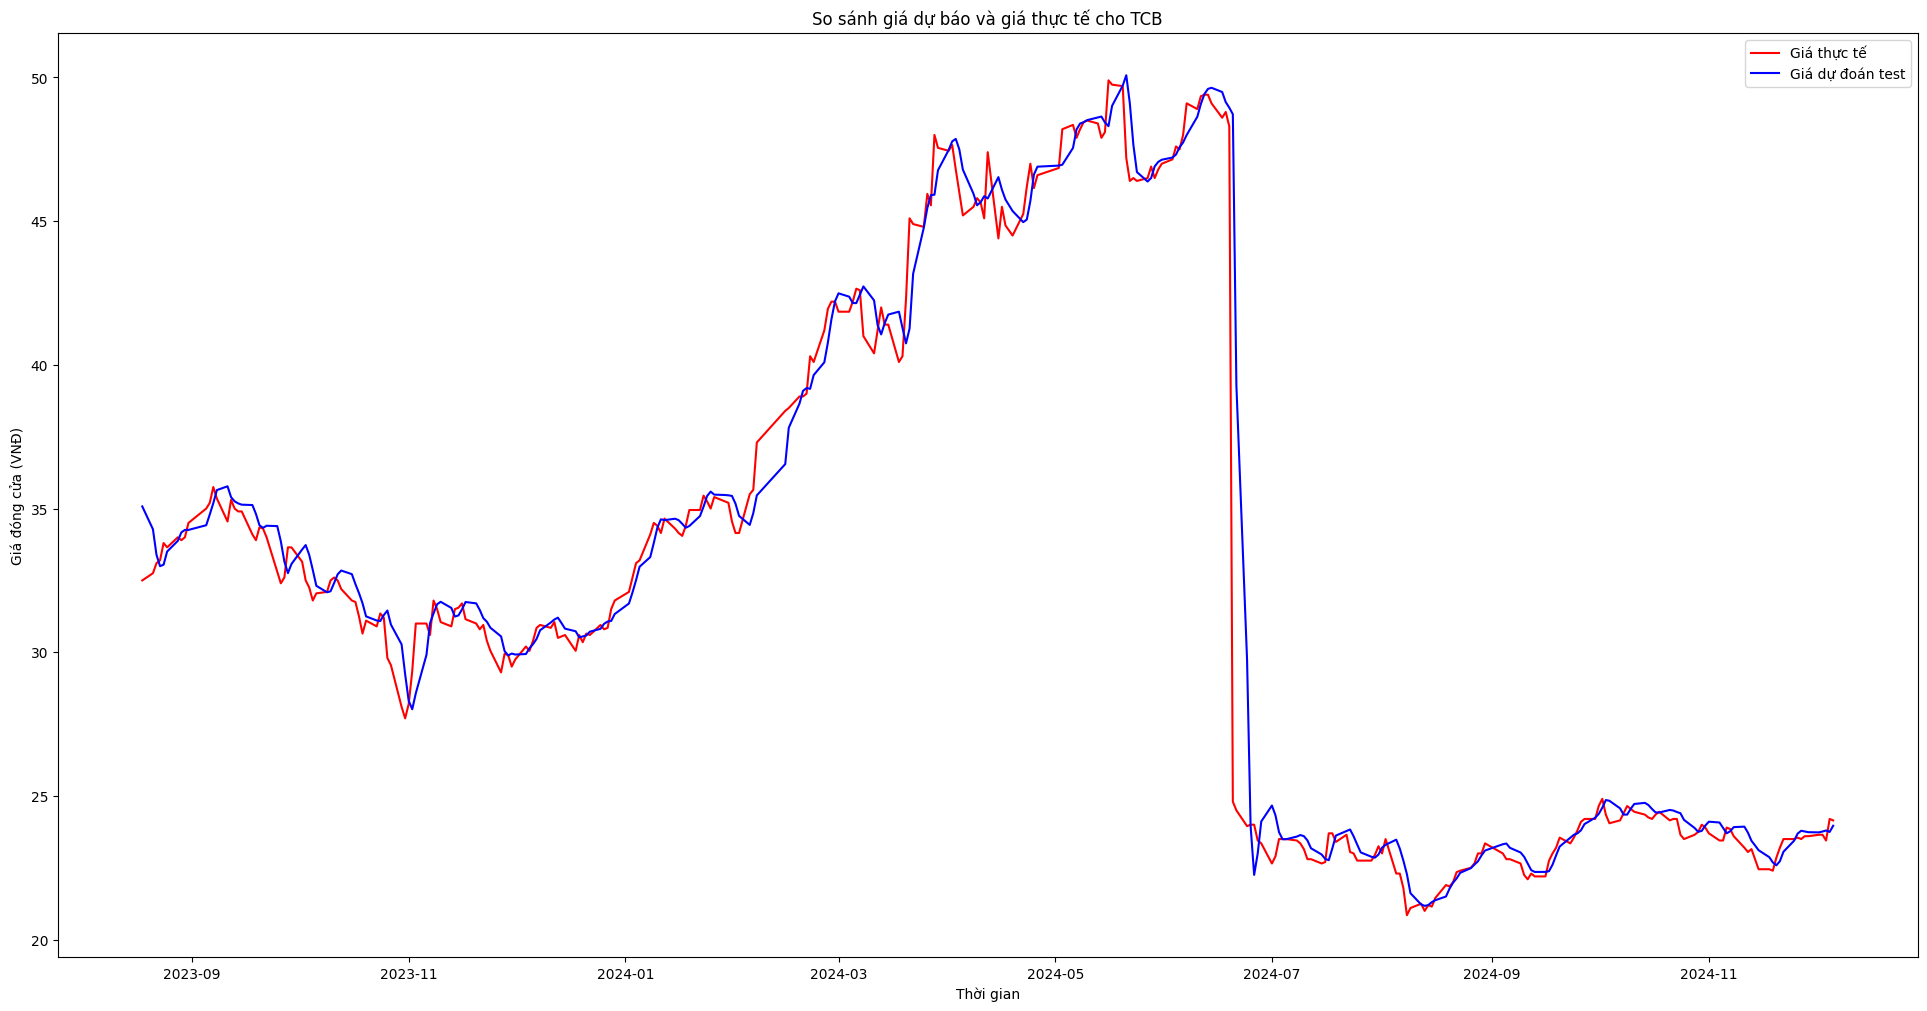

--- Kết quả cho collection: TCB ---
Độ phù hợp tập test (R2): 0.9608822445604762
Sai số tuyệt đối trung bình trên tập test (VNĐ): 0.6633361221453467
Phần trăm sai số tuyệt đối trung bình trên tập test: 0.021831965464971625
----------------------------------------------------
--- Đang xử lý collection: TPB ---


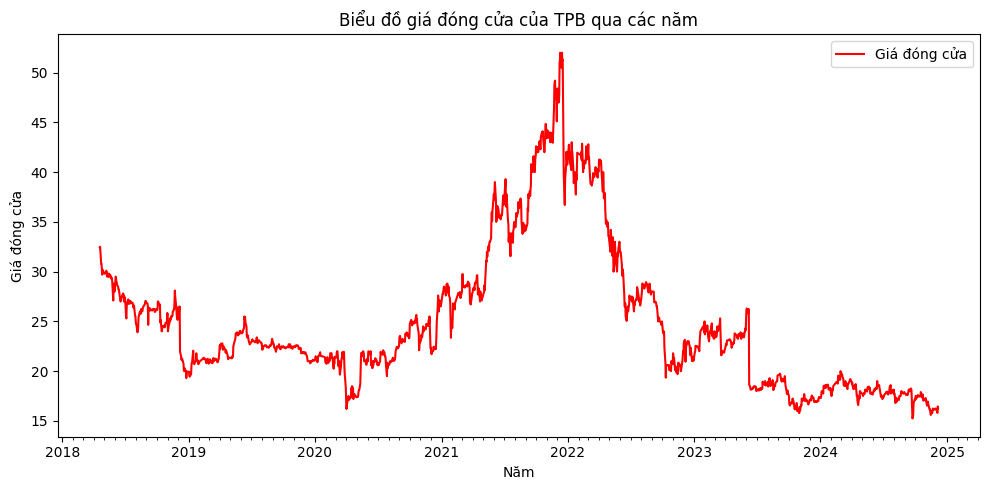

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


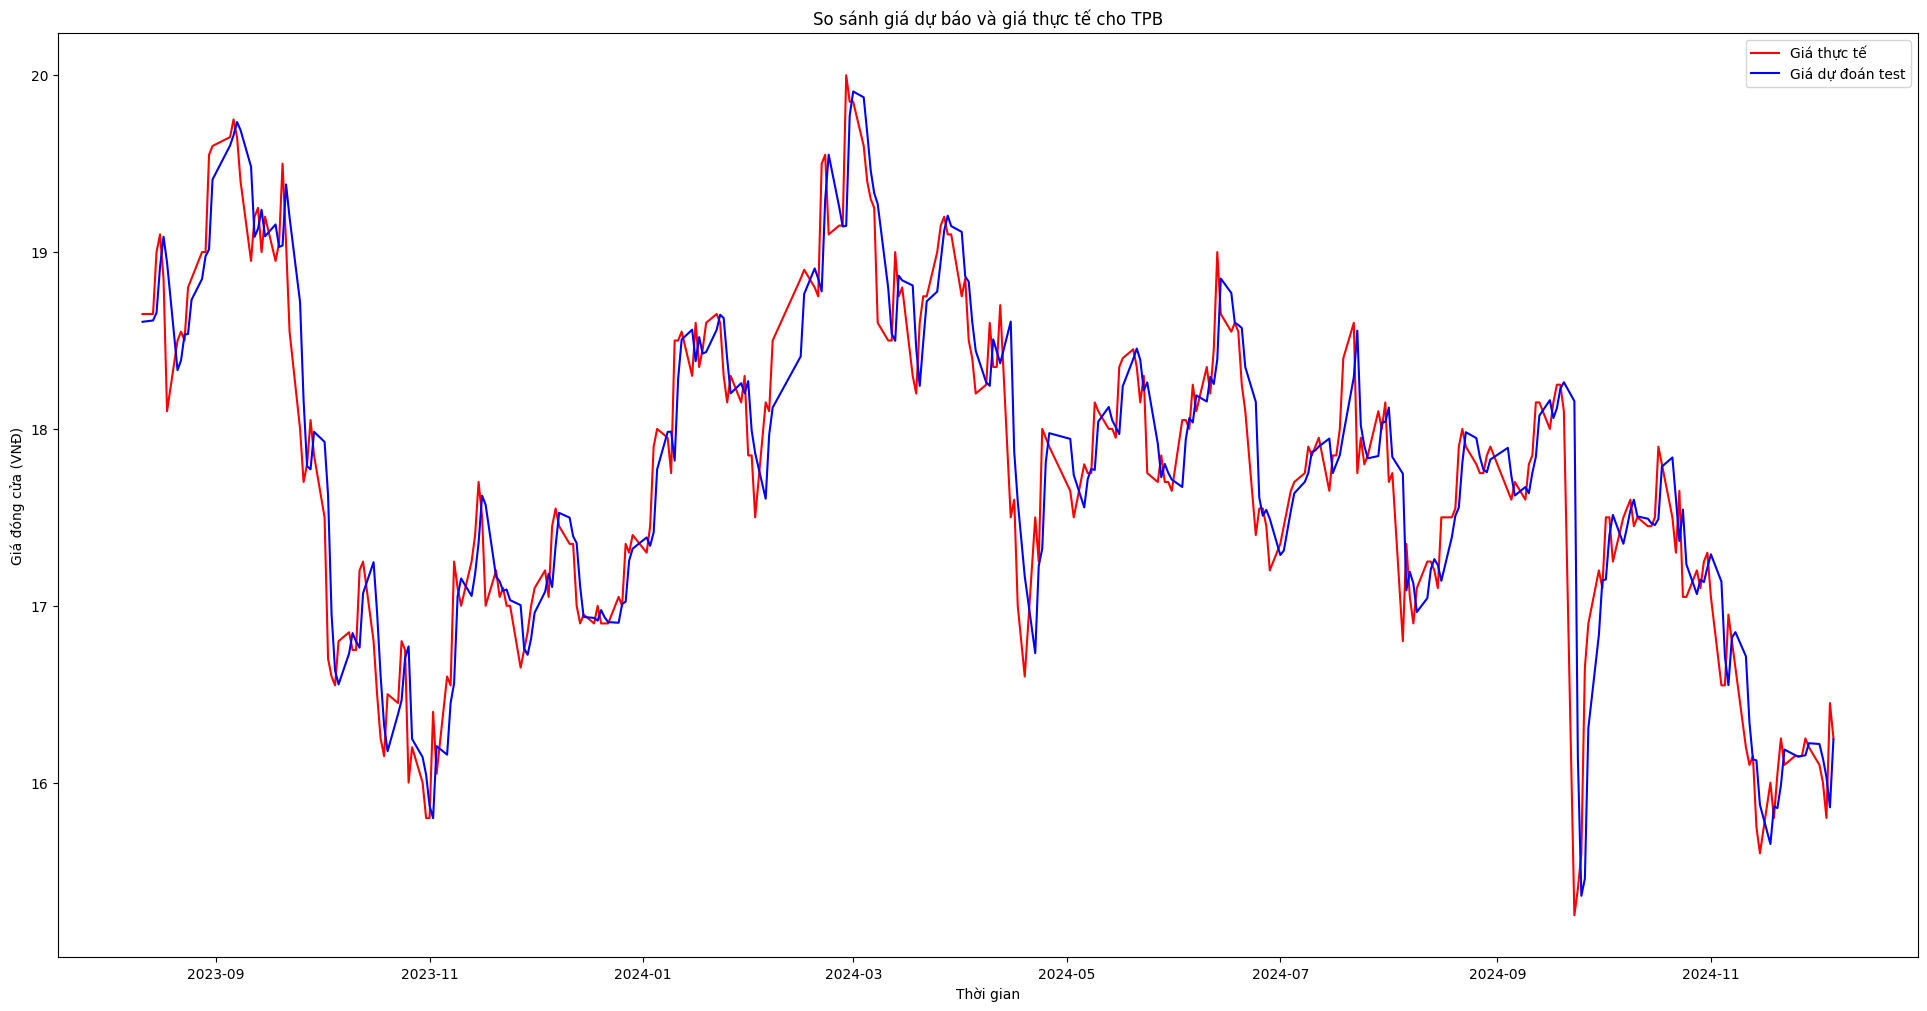

--- Kết quả cho collection: TPB ---
Độ phù hợp tập test (R2): 0.8714862617164344
Sai số tuyệt đối trung bình trên tập test (VNĐ): 0.22356537106525462
Phần trăm sai số tuyệt đối trung bình trên tập test: 0.012741901716262868
----------------------------------------------------
--- Đang xử lý collection: VCB ---


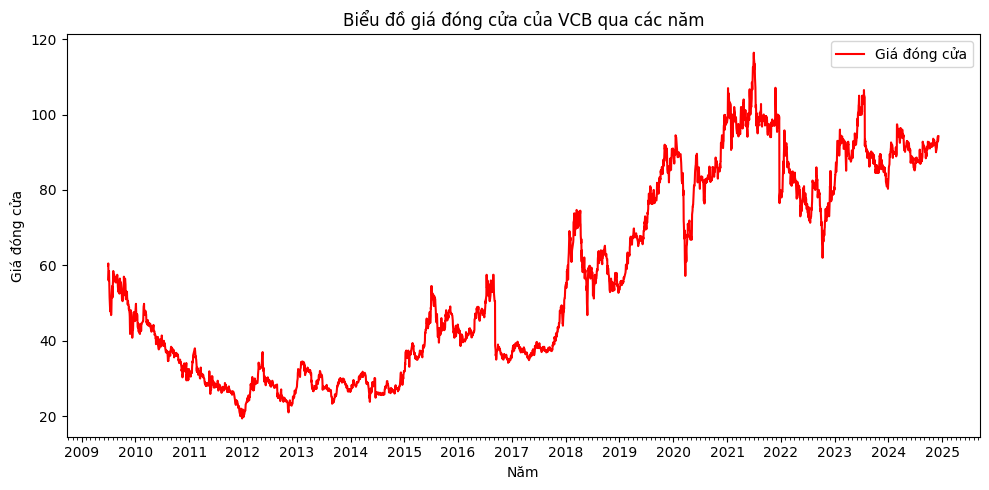

95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


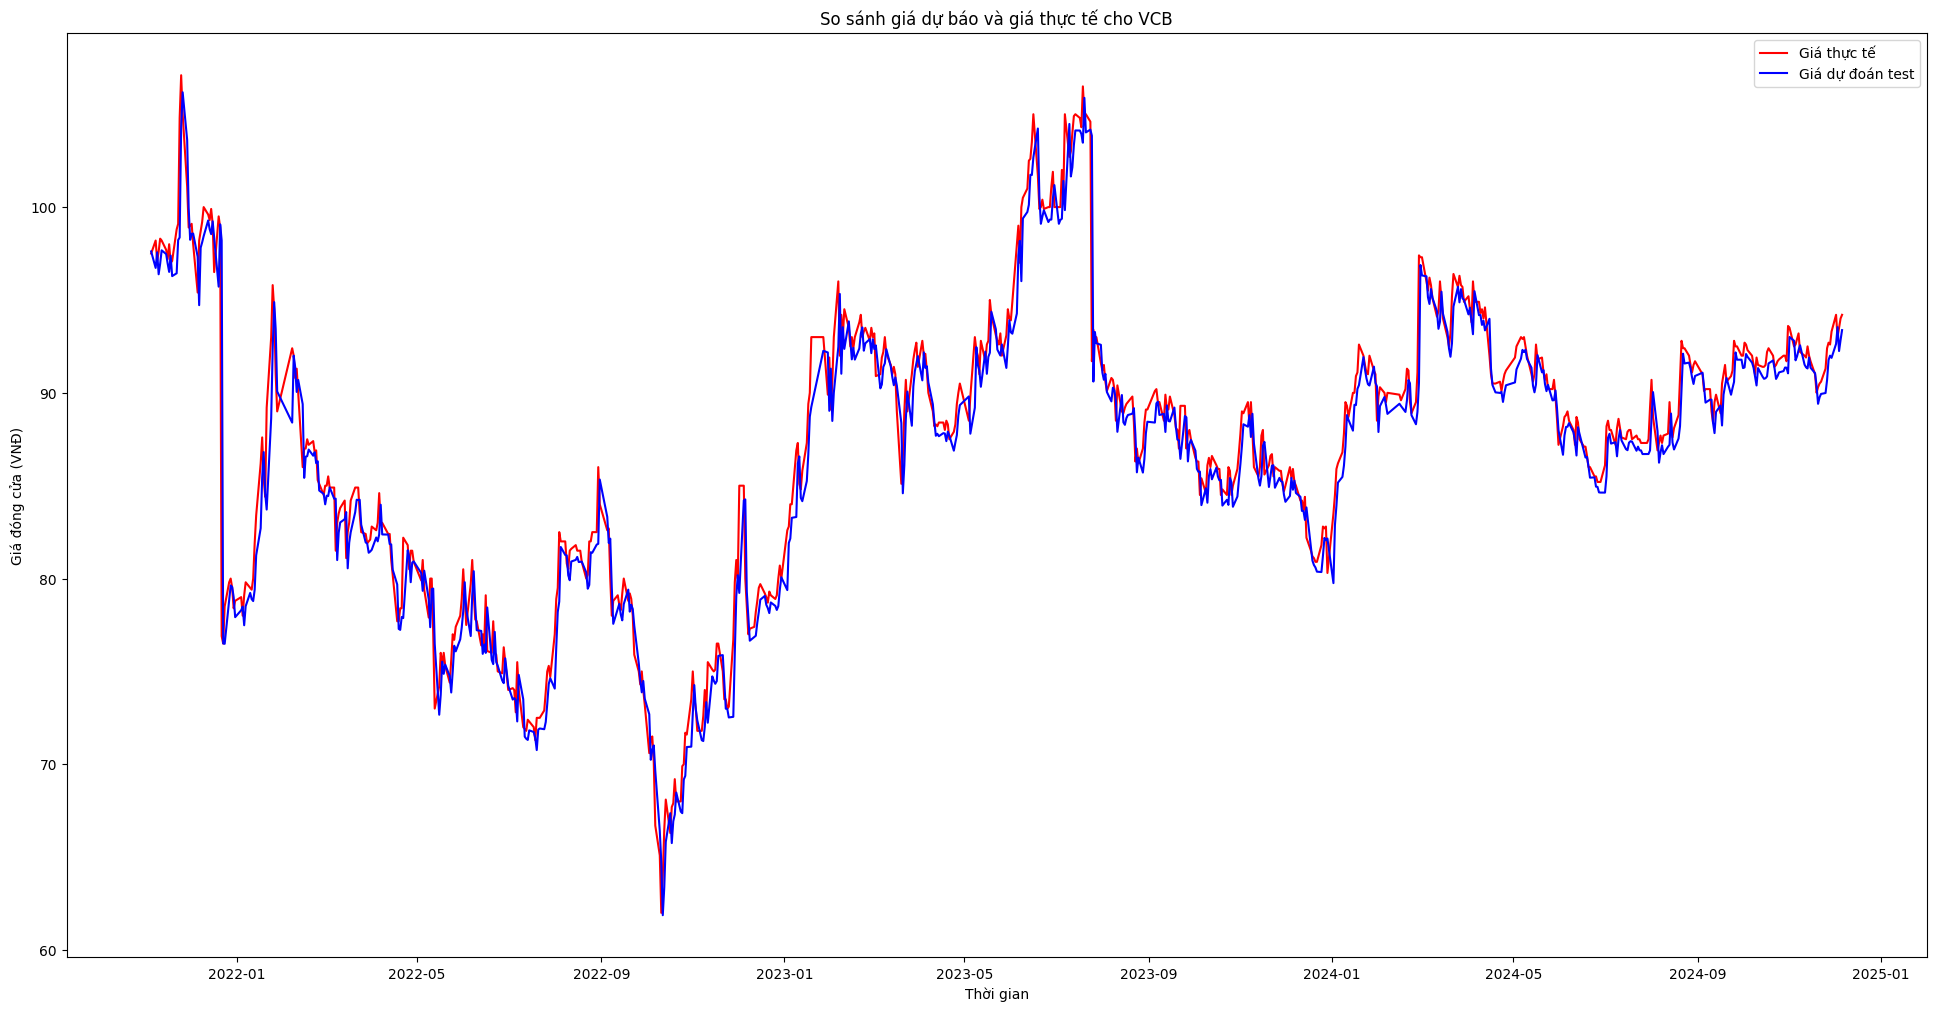

--- Kết quả cho collection: VCB ---
Độ phù hợp tập test (R2): 0.9533522770512137
Sai số tuyệt đối trung bình trên tập test (VNĐ): 1.1136848924073532
Phần trăm sai số tuyệt đối trung bình trên tập test: 0.01289549708259675
----------------------------------------------------
--- Đang xử lý collection: VIB ---


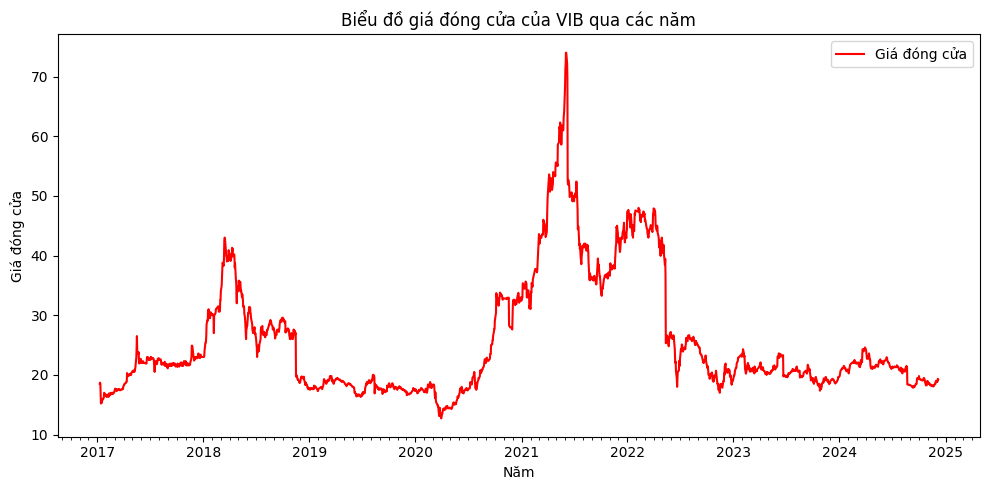

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


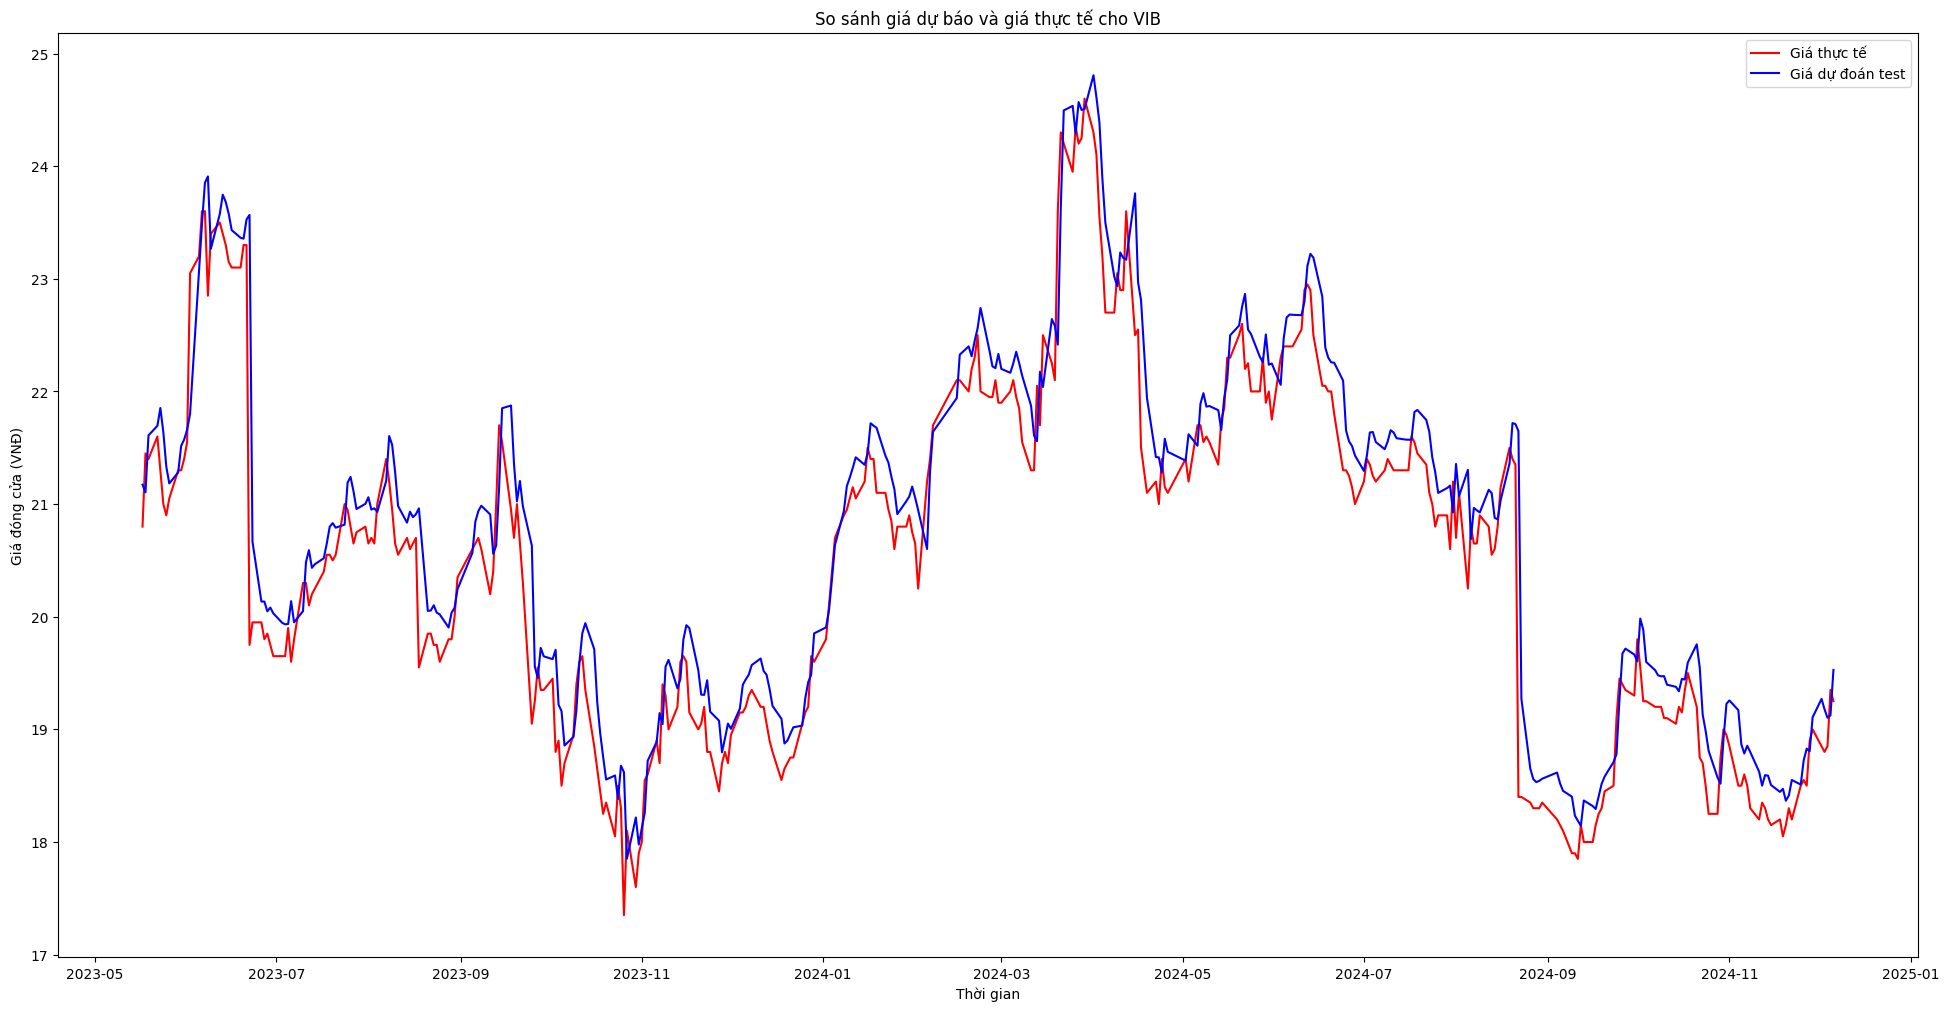

--- Kết quả cho collection: VIB ---
Độ phù hợp tập test (R2): 0.9088577518578485
Sai số tuyệt đối trung bình trên tập test (VNĐ): 0.348025918369971
Phần trăm sai số tuyệt đối trung bình trên tập test: 0.017146741726718852
----------------------------------------------------
--- Đang xử lý collection: VHM ---


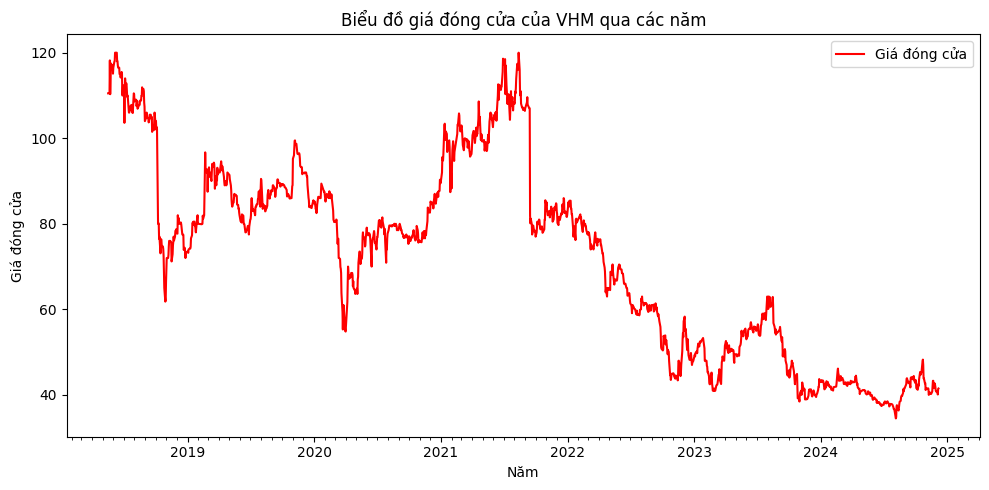

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


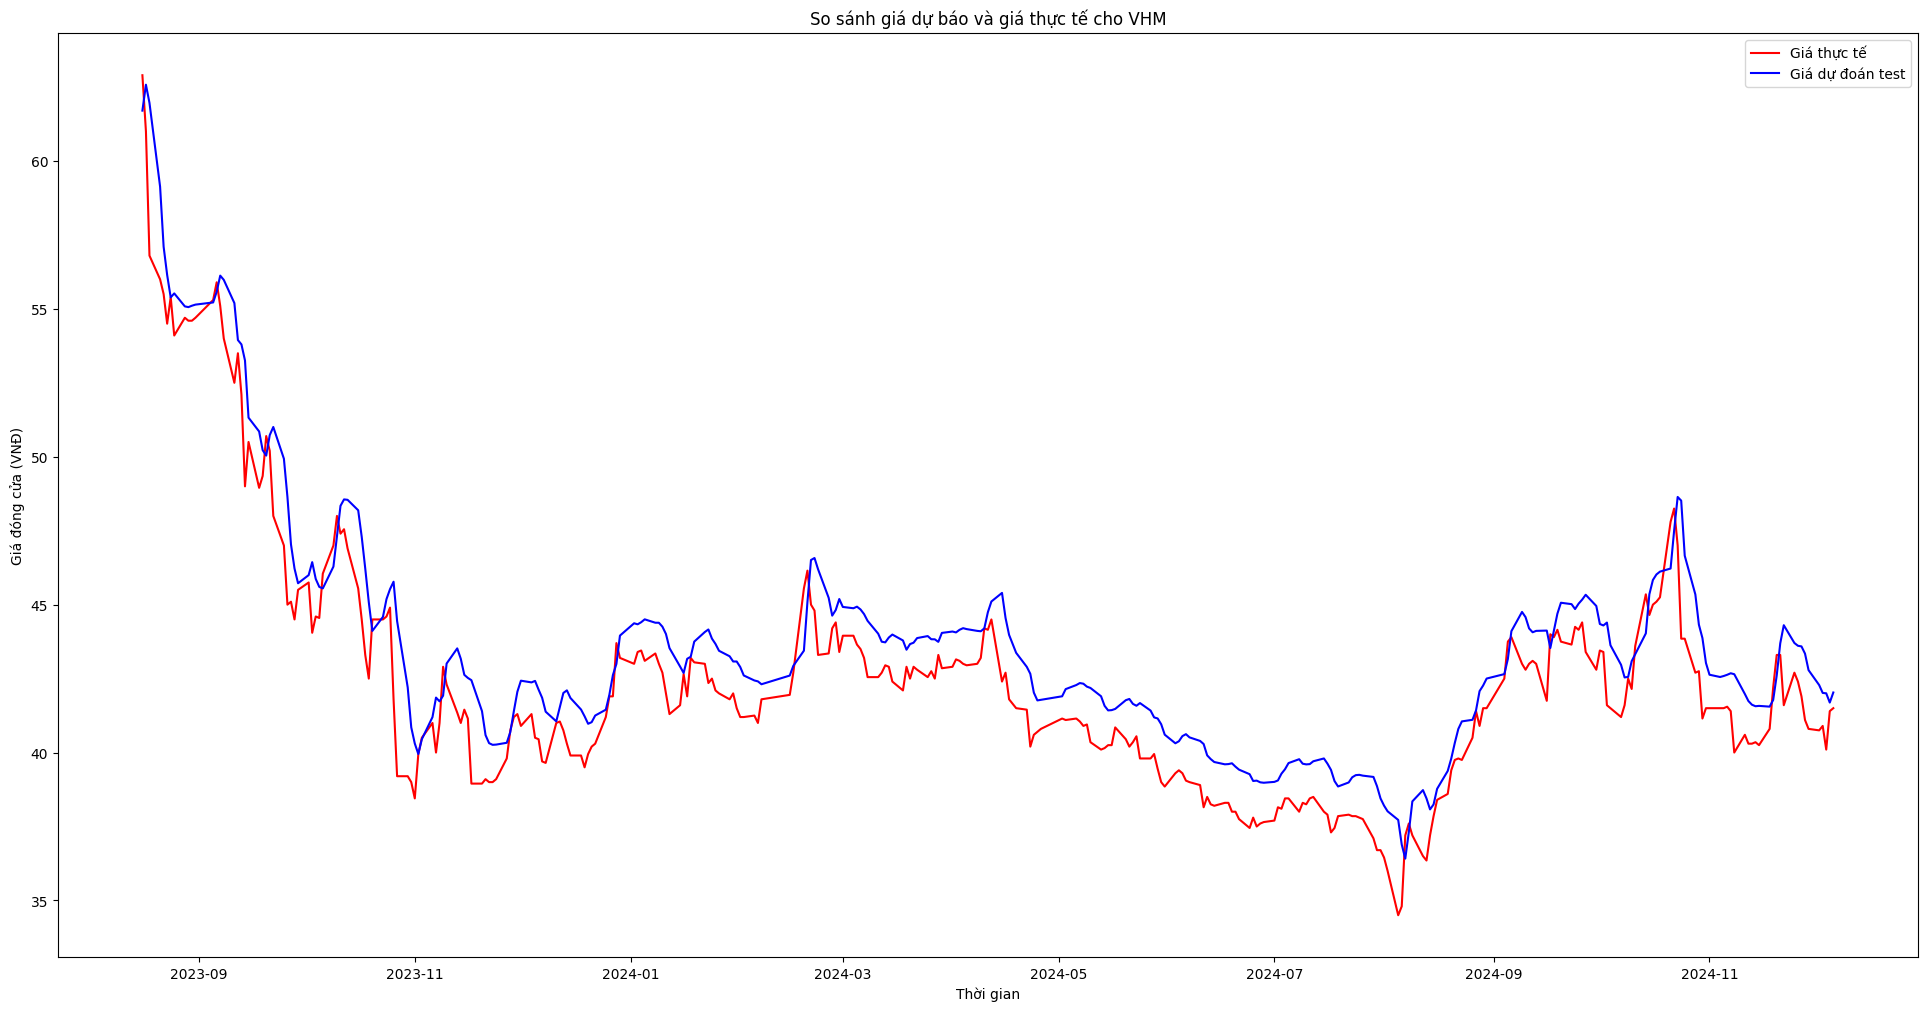

--- Kết quả cho collection: VHM ---
Độ phù hợp tập test (R2): 0.8639556641264734
Sai số tuyệt đối trung bình trên tập test (VNĐ): 1.3393439690030453
Phần trăm sai số tuyệt đối trung bình trên tập test: 0.0320128631939954
----------------------------------------------------


In [71]:
import pandas as pd  # Đọc dữ liệu
import numpy as np  # Xử lý dữ liệu
import matplotlib.pyplot as plt  # Vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler  # Chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint  # Lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model  # Tải mô hình

# Các lớp để xây dựng mô hình
from keras.models import Sequential  # Đầu vào
from keras.layers import LSTM  # Học phụ thuộc
from keras.layers import Dropout  # Tránh học tủ
from keras.layers import Dense  # Đầu ra

# Kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score  # Đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error  # Đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error  # Đo % sai số tuyệt đối trung bình

from pymongo import MongoClient

# Kết nối đến MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['metadata']  # Thay 'metadata' bằng tên database

# Danh sách các collections cần xử lý
collections = ["TCB", "TPB", "VCB", "VIB", "VHM"]  # Thay các tên collections cần xử lý tại đây

for collection_name in collections:
    print(f"--- Đang xử lý collection: {collection_name} ---")
    
    # Lấy dữ liệu từ MongoDB
    collection = db[collection_name]
    df = pd.DataFrame(list(collection.find({}, {"_id": 0})))
    
    if df.empty:
        print(f"Collection {collection_name} không có dữ liệu.")
        continue

    # Xử lý thời gian và sắp xếp dữ liệu
    df['Ngay'] = pd.to_datetime(df['Ngay'], format='%Y-%m-%d')
    df = df.sort_values(by='Ngay')

    # Lấy thông tin năm từ cột "Ngày"
    df['Nam'] = df['Ngay'].dt.year

    # Tạo đồ thị giá đóng cửa qua các năm
    plt.figure(figsize=(10, 5))
    plt.plot(df['Ngay'], df['GiaDongCua'], label='Giá đóng cửa', color='red')
    plt.xlabel('Năm')
    plt.ylabel('Giá đóng cửa')
    plt.title(f'Biểu đồ giá đóng cửa của {collection_name} qua các năm')
    plt.legend(loc='best')

    from matplotlib.dates import YearLocator, DateFormatter, MonthLocator
    years = YearLocator()
    yearsFmt = DateFormatter('%Y')
    months = MonthLocator()
    plt.gca().xaxis.set_major_locator(years)
    plt.gca().xaxis.set_major_formatter(yearsFmt)
    plt.gca().xaxis.set_minor_locator(months)
    plt.tight_layout()
    plt.show()

    # Chuyển đổi sang chỉ số thời gian
    df1 = pd.DataFrame(df, columns=['Ngay', 'GiaDongCua'])
    df1.index = df1['Ngay']
    df1.drop('Ngay', axis=1, inplace=True)

    # Chia tập dữ liệu
    data = df1.values
    train_data = data[:int(len(df) * 0.8)]
    test_data = data[int(len(df) * 0.8):]

    # Chuẩn hóa dữ liệu
    sc = MinMaxScaler(feature_range=(0, 1))
    sc_train = sc.fit_transform(train_data)

    # Tạo cửa sổ thời gian cho tập train
    x_train, y_train = [], []
    for i in range(50, len(train_data)):
        x_train.append(sc_train[i - 50:i, 0])  # 50 giá trị trước đó
        y_train.append(sc_train[i, 0])  # Giá trị tiếp theo
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # Tải mô hình tốt nhất
    save_model_path = f"models/{collection_name}_model.keras"
    final_model = load_model(save_model_path)

    # Dự đoán trên tập train
    y_train_predict = final_model.predict(x_train)
    y_train_predict = sc.inverse_transform(y_train_predict)
    y_train = sc.inverse_transform(y_train.reshape(-1, 1))

    # Xử lý dữ liệu test
    test = df1[len(train_data) - 50:].values
    test = test.reshape(-1, 1)
    sc_test = sc.transform(test)

    x_test = []
    for i in range(50, test.shape[0]):
        x_test.append(sc_test[i - 50:i, 0])
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    # Dự đoán trên tập test
    y_test = data[-len(x_test):]  # Giá trị thực
    y_test_predict = final_model.predict(x_test)
    y_test_predict = sc.inverse_transform(y_test_predict)  # Giá dự đoán

    # So sánh giá dự báo và giá thực tế
    num_test_predictions = len(y_test_predict)
    test_data1 = df.iloc[-num_test_predictions:].copy()
    plt.figure(figsize=(24, 12))
    if 'Ngay' in test_data1.columns:
        plt.plot(test_data1['Ngay'], test_data1['GiaDongCua'], label='Giá thực tế', color='red')
    else:
        raise KeyError("Cột 'Ngay' không tồn tại trong test_data1.")

    test_data1['Dự đoán'] = y_test_predict.flatten()
    plt.plot(test_data1['Ngay'], test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')
    plt.title(f'So sánh giá dự báo và giá thực tế cho {collection_name}')
    plt.xlabel('Thời gian')
    plt.ylabel('Giá đóng cửa (VNĐ)')
    plt.legend()
    plt.show()

    # Đánh giá mô hình
    r2 = r2_score(y_test, y_test_predict)
    mae = mean_absolute_error(y_test, y_test_predict)
    mape = mean_absolute_percentage_error(y_test, y_test_predict)
    
    print(f"--- Kết quả cho collection: {collection_name} ---")
    print('Độ phù hợp tập test (R2):', r2)
    print('Sai số tuyệt đối trung bình trên tập test (VNĐ):', mae)
    print('Phần trăm sai số tuyệt đối trung bình trên tập test:', mape)
    print("----------------------------------------------------")

--- Đang xử lý collection: VIC ---


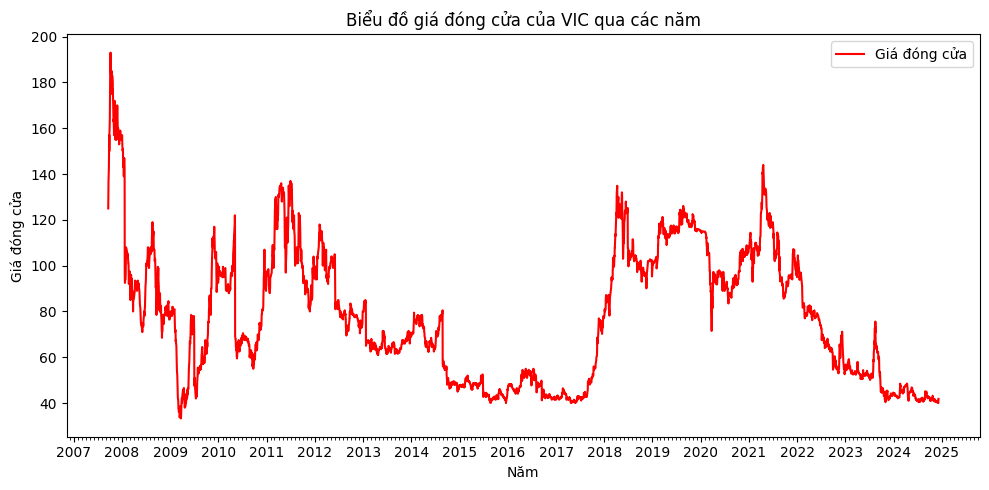

106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


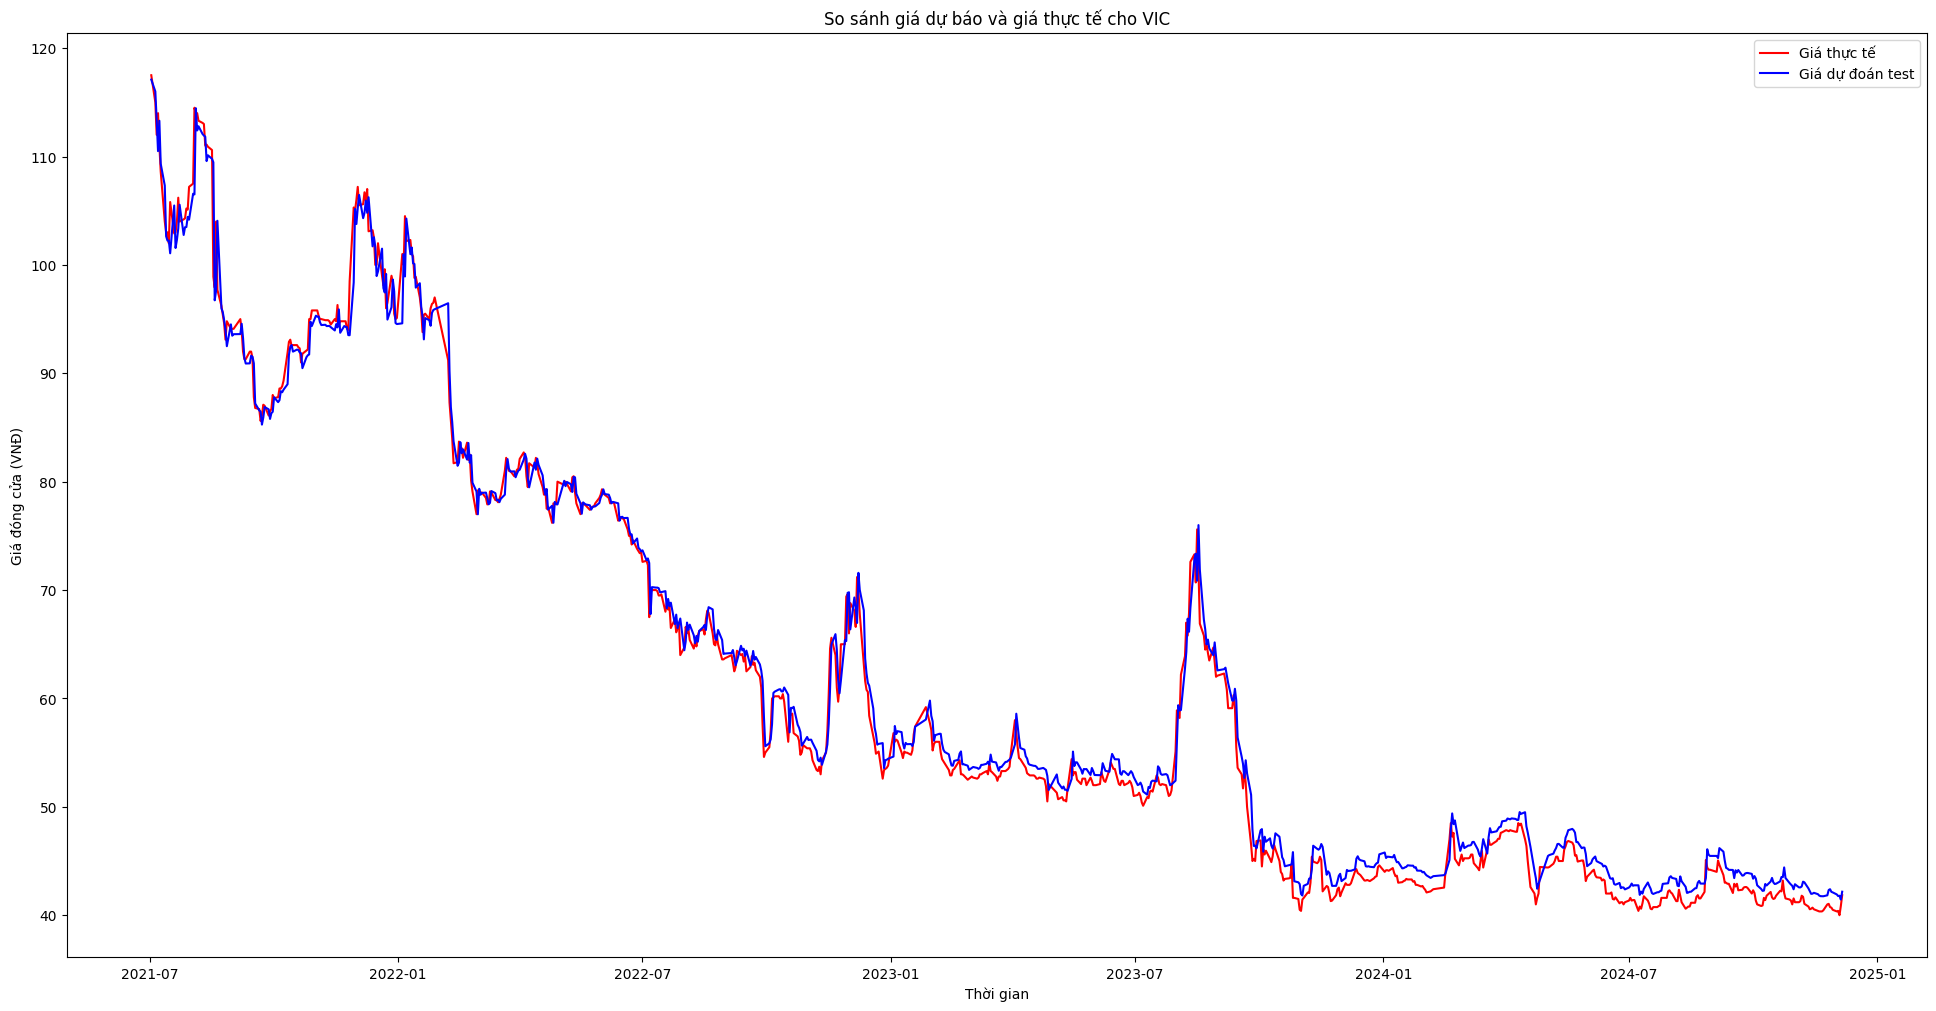

--- Kết quả cho collection: VIC ---
Độ phù hợp tập test (R2): 0.9937482788230337
Sai số tuyệt đối trung bình trên tập test (VNĐ): 1.255026231810104
Phần trăm sai số tuyệt đối trung bình trên tập test: 0.02231384545269258
----------------------------------------------------
--- Đang xử lý collection: VJC ---


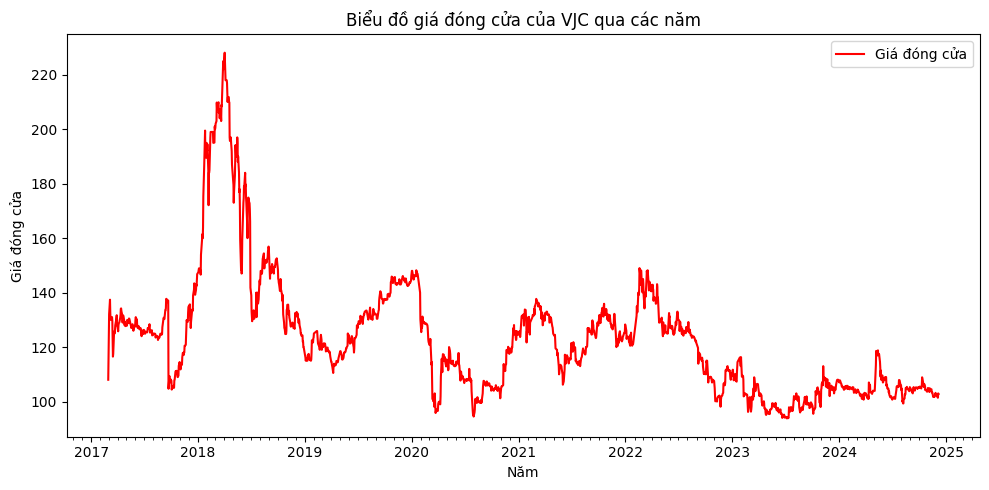

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


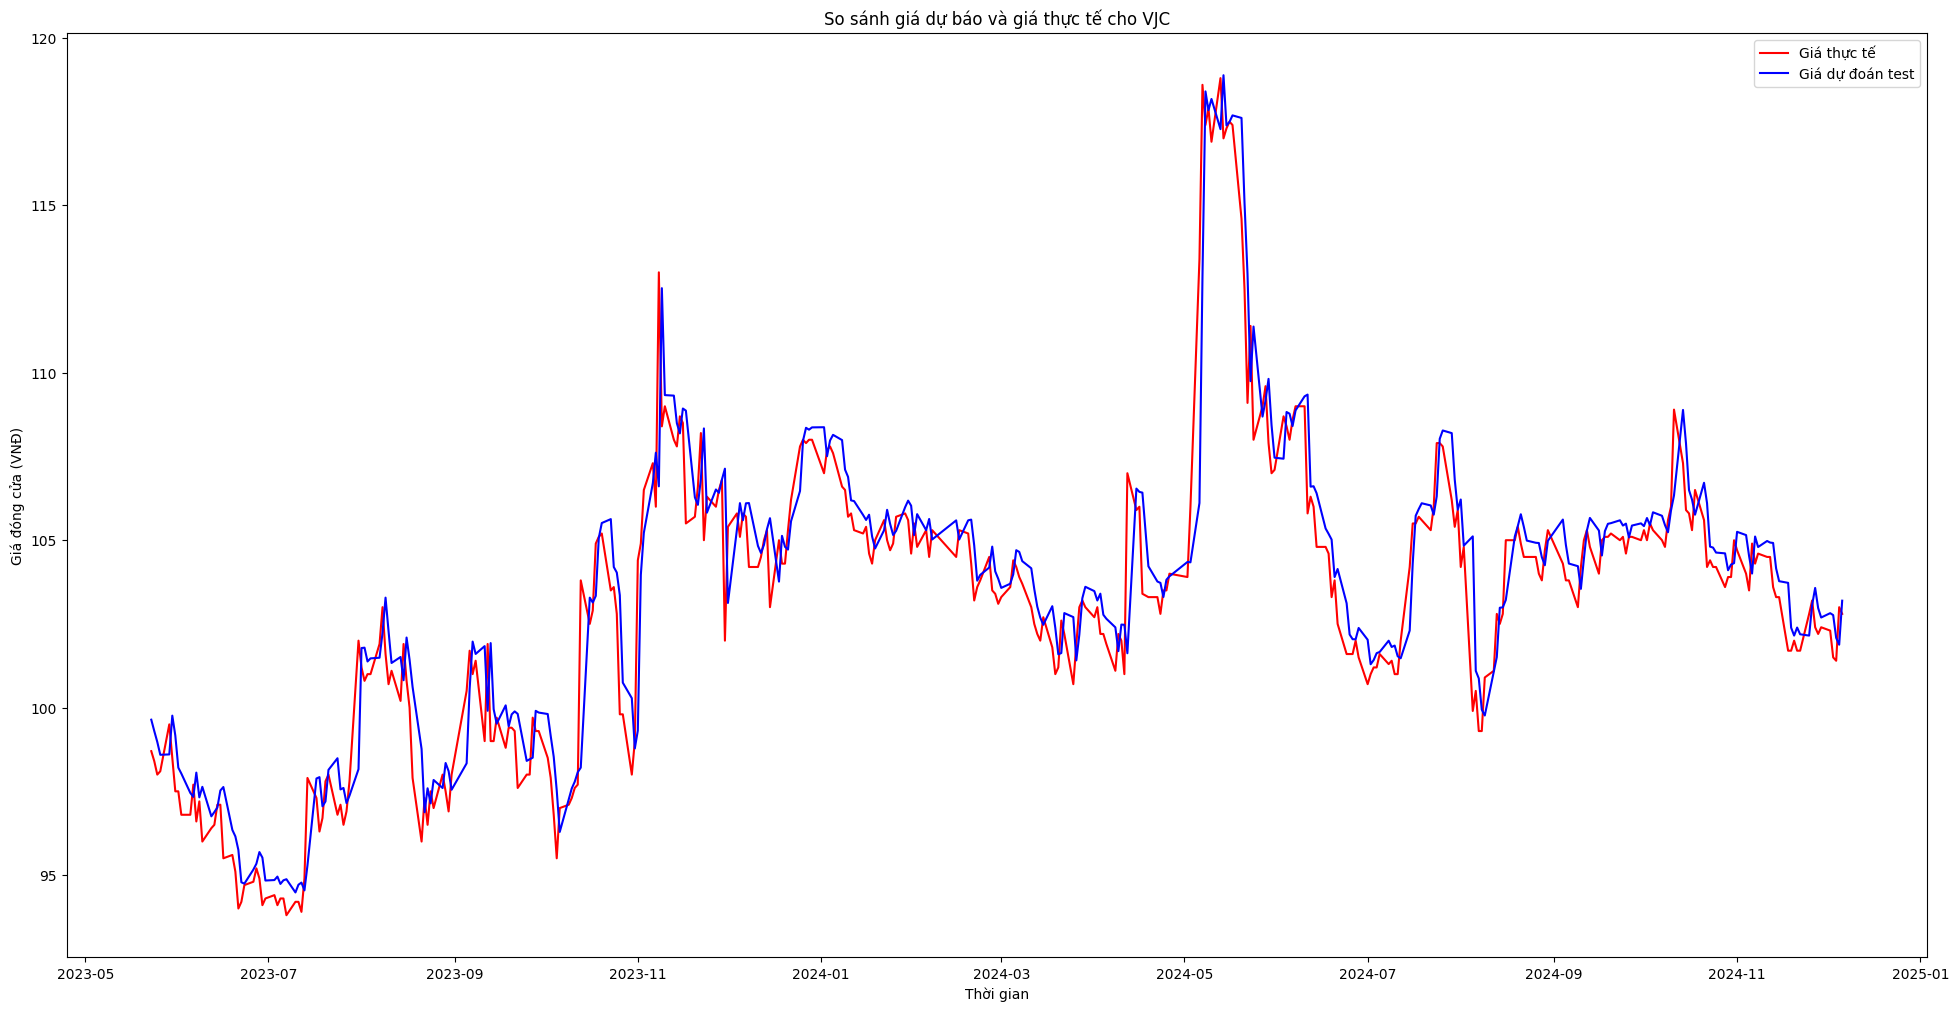

--- Kết quả cho collection: VJC ---
Độ phù hợp tập test (R2): 0.9008124461549756
Sai số tuyệt đối trung bình trên tập test (VNĐ): 0.9565009679549783
Phần trăm sai số tuyệt đối trung bình trên tập test: 0.009250646996313814
----------------------------------------------------
--- Đang xử lý collection: VNM ---


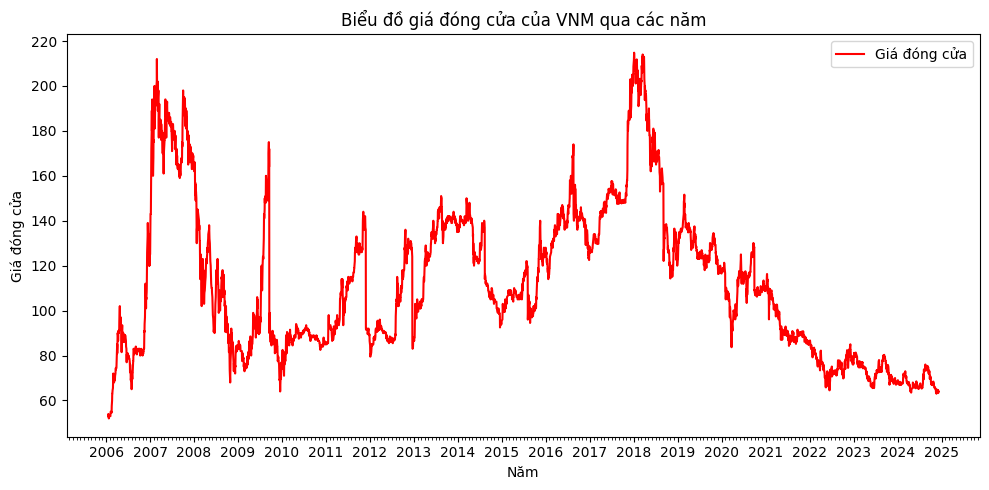

117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


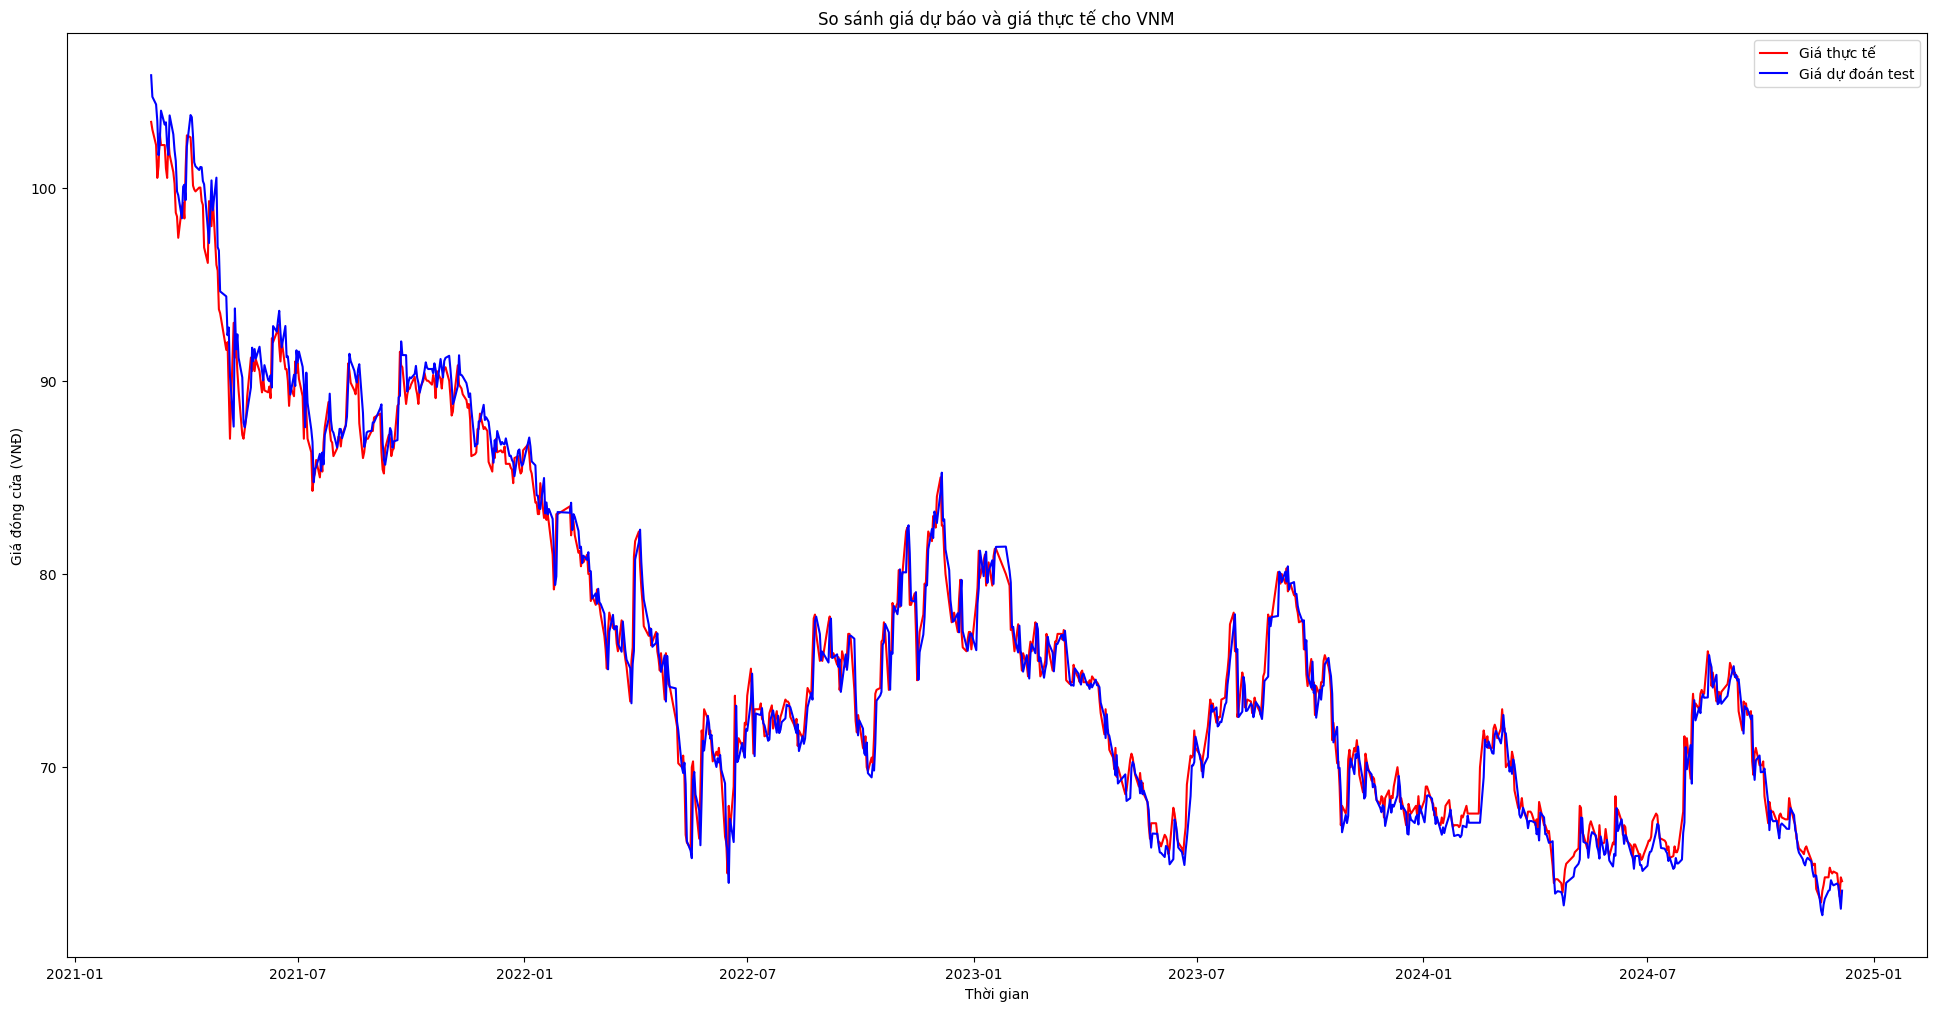

--- Kết quả cho collection: VNM ---
Độ phù hợp tập test (R2): 0.9832352681865125
Sai số tuyệt đối trung bình trên tập test (VNĐ): 0.8773734868394484
Phần trăm sai số tuyệt đối trung bình trên tập test: 0.011368967783910095
----------------------------------------------------
--- Đang xử lý collection: VPB ---


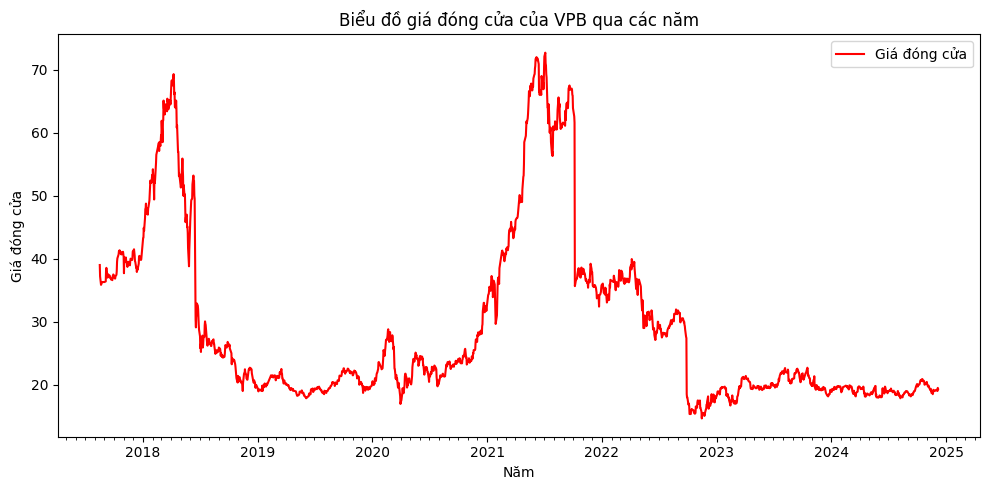

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


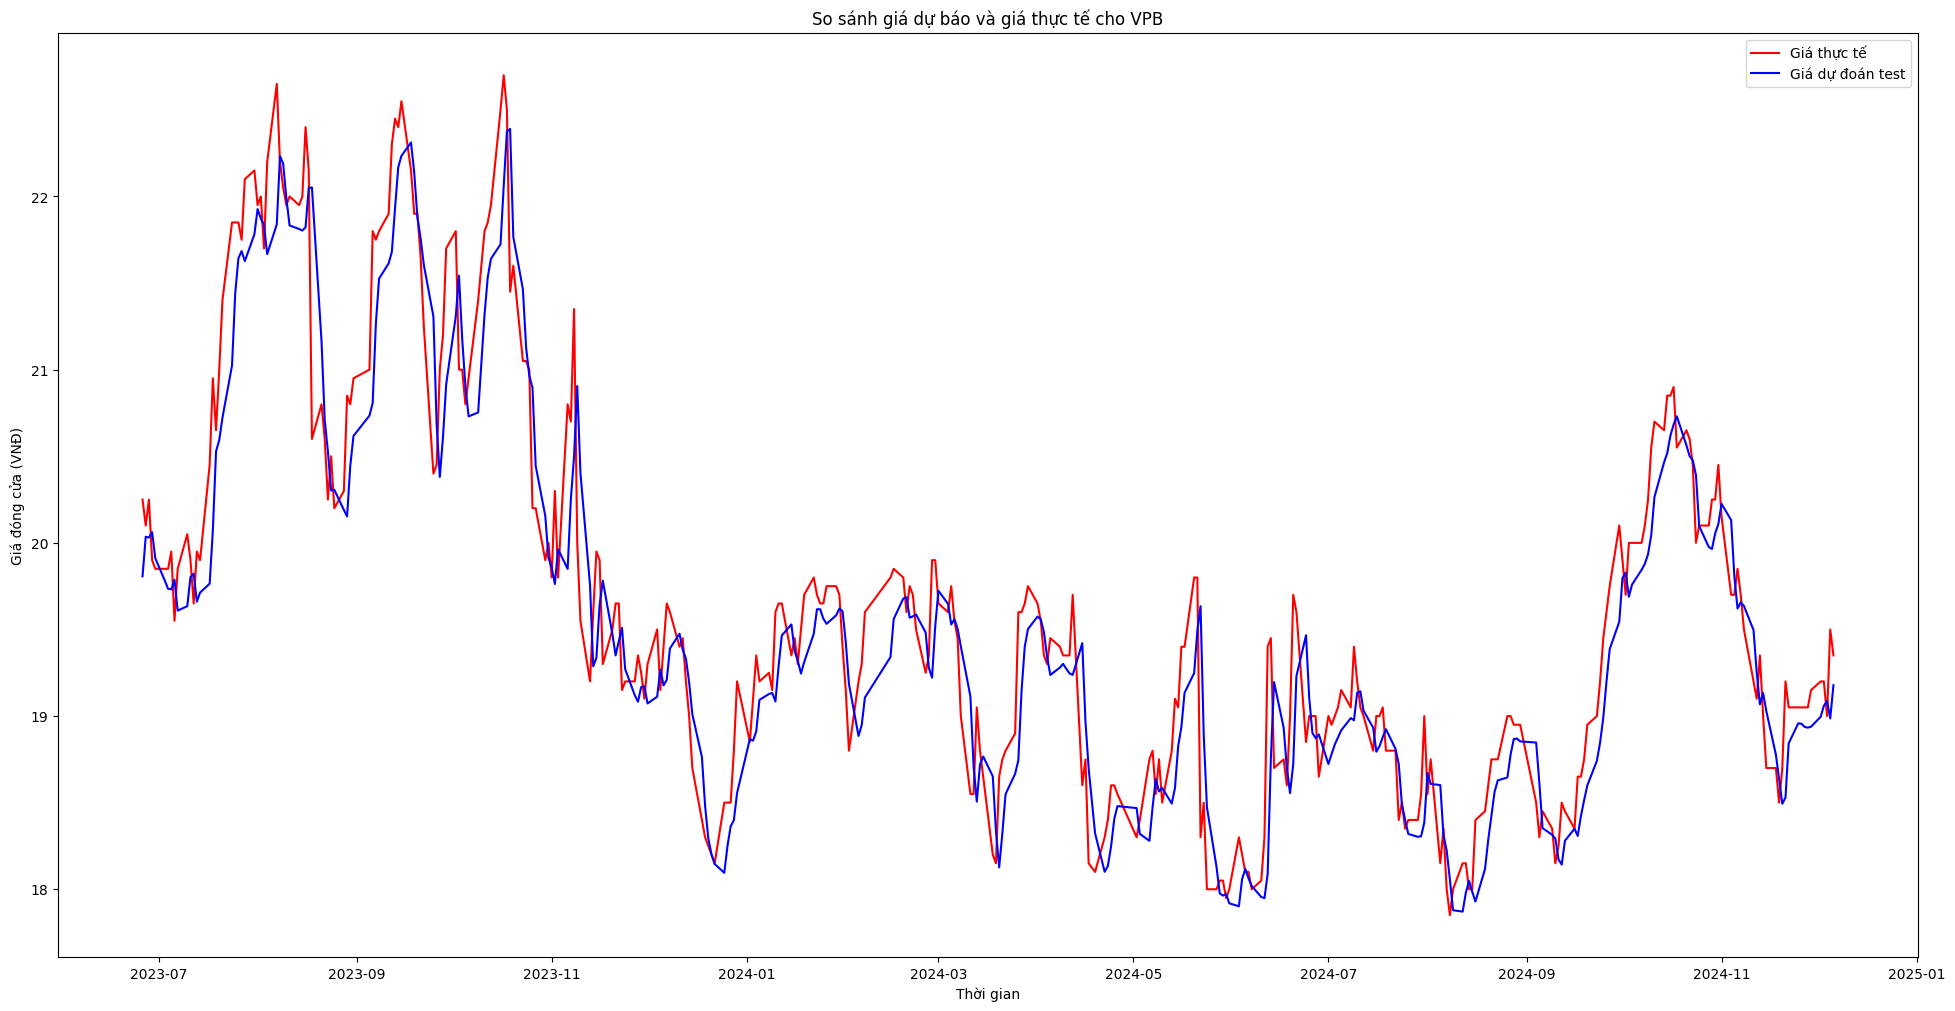

--- Kết quả cho collection: VPB ---
Độ phù hợp tập test (R2): 0.90160903066651
Sai số tuyệt đối trung bình trên tập test (VNĐ): 0.27589829450096587
Phần trăm sai số tuyệt đối trung bình trên tập test: 0.013918498938666842
----------------------------------------------------
--- Đang xử lý collection: VRE ---


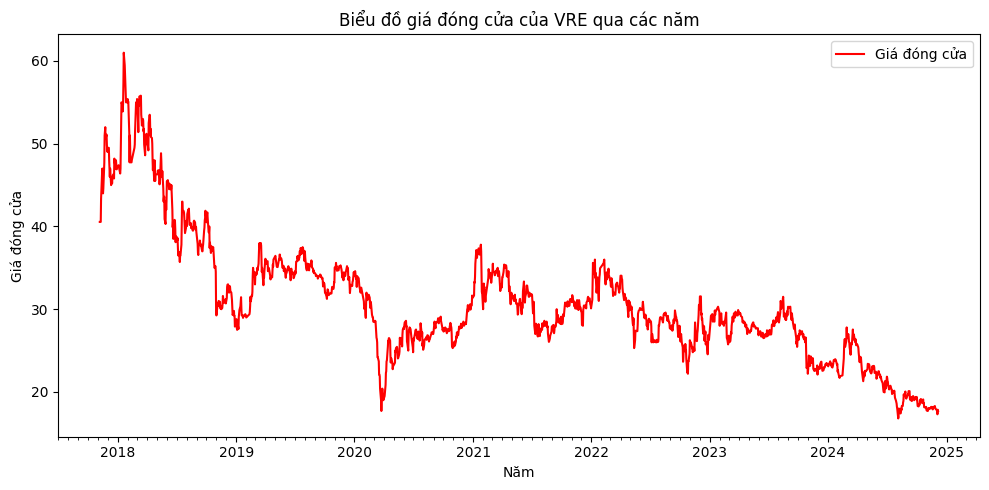

43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


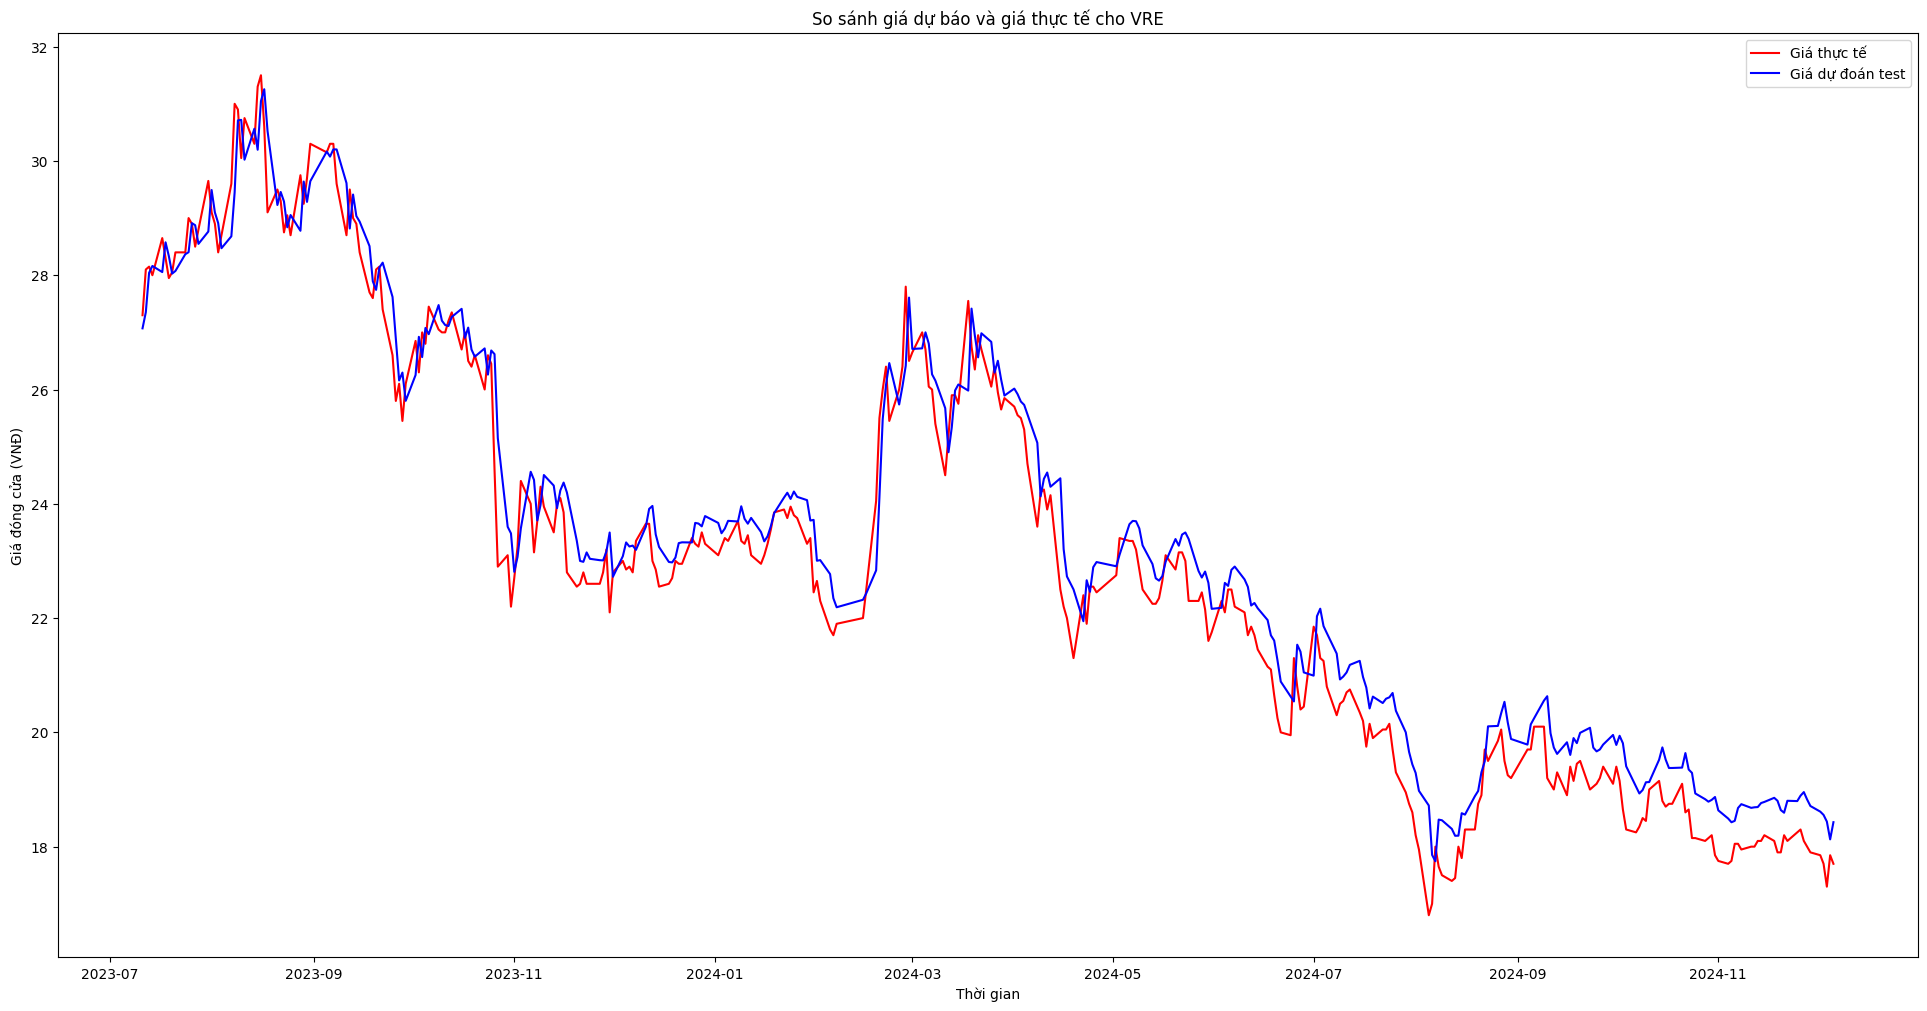

--- Kết quả cho collection: VRE ---
Độ phù hợp tập test (R2): 0.9664557756922404
Sai số tuyệt đối trung bình trên tập test (VNĐ): 0.5630677215146347
Phần trăm sai số tuyệt đối trung bình trên tập test: 0.02579698882251872
----------------------------------------------------


In [72]:
import pandas as pd  # Đọc dữ liệu
import numpy as np  # Xử lý dữ liệu
import matplotlib.pyplot as plt  # Vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler  # Chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint  # Lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model  # Tải mô hình

# Các lớp để xây dựng mô hình
from keras.models import Sequential  # Đầu vào
from keras.layers import LSTM  # Học phụ thuộc
from keras.layers import Dropout  # Tránh học tủ
from keras.layers import Dense  # Đầu ra

# Kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score  # Đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error  # Đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error  # Đo % sai số tuyệt đối trung bình

from pymongo import MongoClient

# Kết nối đến MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['metadata']  # Thay 'metadata' bằng tên database

# Danh sách các collections cần xử lý
collections = ["VIC", "VJC", "VNM", "VPB", "VRE"]  # Thay các tên collections cần xử lý tại đây

for collection_name in collections:
    print(f"--- Đang xử lý collection: {collection_name} ---")
    
    # Lấy dữ liệu từ MongoDB
    collection = db[collection_name]
    df = pd.DataFrame(list(collection.find({}, {"_id": 0})))
    
    if df.empty:
        print(f"Collection {collection_name} không có dữ liệu.")
        continue

    # Xử lý thời gian và sắp xếp dữ liệu
    df['Ngay'] = pd.to_datetime(df['Ngay'], format='%Y-%m-%d')
    df = df.sort_values(by='Ngay')

    # Lấy thông tin năm từ cột "Ngày"
    df['Nam'] = df['Ngay'].dt.year

    # Tạo đồ thị giá đóng cửa qua các năm
    plt.figure(figsize=(10, 5))
    plt.plot(df['Ngay'], df['GiaDongCua'], label='Giá đóng cửa', color='red')
    plt.xlabel('Năm')
    plt.ylabel('Giá đóng cửa')
    plt.title(f'Biểu đồ giá đóng cửa của {collection_name} qua các năm')
    plt.legend(loc='best')

    from matplotlib.dates import YearLocator, DateFormatter, MonthLocator
    years = YearLocator()
    yearsFmt = DateFormatter('%Y')
    months = MonthLocator()
    plt.gca().xaxis.set_major_locator(years)
    plt.gca().xaxis.set_major_formatter(yearsFmt)
    plt.gca().xaxis.set_minor_locator(months)
    plt.tight_layout()
    plt.show()

    # Chuyển đổi sang chỉ số thời gian
    df1 = pd.DataFrame(df, columns=['Ngay', 'GiaDongCua'])
    df1.index = df1['Ngay']
    df1.drop('Ngay', axis=1, inplace=True)

    # Chia tập dữ liệu
    data = df1.values
    train_data = data[:int(len(df) * 0.8)]
    test_data = data[int(len(df) * 0.8):]

    # Chuẩn hóa dữ liệu
    sc = MinMaxScaler(feature_range=(0, 1))
    sc_train = sc.fit_transform(train_data)

    # Tạo cửa sổ thời gian cho tập train
    x_train, y_train = [], []
    for i in range(50, len(train_data)):
        x_train.append(sc_train[i - 50:i, 0])  # 50 giá trị trước đó
        y_train.append(sc_train[i, 0])  # Giá trị tiếp theo
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # Tải mô hình tốt nhất
    save_model_path = f"models/{collection_name}_model.keras"
    final_model = load_model(save_model_path)

    # Dự đoán trên tập train
    y_train_predict = final_model.predict(x_train)
    y_train_predict = sc.inverse_transform(y_train_predict)
    y_train = sc.inverse_transform(y_train.reshape(-1, 1))

    # Xử lý dữ liệu test
    test = df1[len(train_data) - 50:].values
    test = test.reshape(-1, 1)
    sc_test = sc.transform(test)

    x_test = []
    for i in range(50, test.shape[0]):
        x_test.append(sc_test[i - 50:i, 0])
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    # Dự đoán trên tập test
    y_test = data[-len(x_test):]  # Giá trị thực
    y_test_predict = final_model.predict(x_test)
    y_test_predict = sc.inverse_transform(y_test_predict)  # Giá dự đoán

    # So sánh giá dự báo và giá thực tế
    num_test_predictions = len(y_test_predict)
    test_data1 = df.iloc[-num_test_predictions:].copy()
    plt.figure(figsize=(24, 12))
    if 'Ngay' in test_data1.columns:
        plt.plot(test_data1['Ngay'], test_data1['GiaDongCua'], label='Giá thực tế', color='red')
    else:
        raise KeyError("Cột 'Ngay' không tồn tại trong test_data1.")

    test_data1['Dự đoán'] = y_test_predict.flatten()
    plt.plot(test_data1['Ngay'], test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')
    plt.title(f'So sánh giá dự báo và giá thực tế cho {collection_name}')
    plt.xlabel('Thời gian')
    plt.ylabel('Giá đóng cửa (VNĐ)')
    plt.legend()
    plt.show()

    # Đánh giá mô hình
    r2 = r2_score(y_test, y_test_predict)
    mae = mean_absolute_error(y_test, y_test_predict)
    mape = mean_absolute_percentage_error(y_test, y_test_predict)
    
    print(f"--- Kết quả cho collection: {collection_name} ---")
    print('Độ phù hợp tập test (R2):', r2)
    print('Sai số tuyệt đối trung bình trên tập test (VNĐ):', mae)
    print('Phần trăm sai số tuyệt đối trung bình trên tập test:', mape)
    print("----------------------------------------------------")